# Forecast the Airlines Passengers data set.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf 
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Airlines+Data.xlsx')
df

Month  Passengers
0  1995-01-01         112
1  1995-02-01         118
2  1995-03-01         132
3  1995-04-01         129
4  1995-05-01         121
..        ...         ...
91 2002-08-01         405
92 2002-09-01         355
93 2002-10-01         306
94 2002-11-01         271
95 2002-12-01         306

[96 rows x 2 columns]

In [3]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

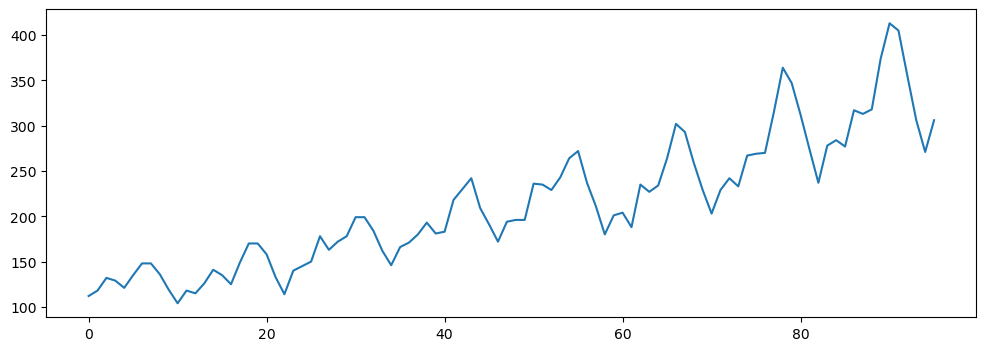

In [4]:
df.Passengers.plot(figsize=(12,4));

In [5]:
print('Shape of the data', df.shape)

Shape of the data (96, 2)


In [6]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [7]:
df.nunique()

Month         96
Passengers    80
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [9]:
df.describe()


Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

In [10]:
#Renaming the Month column into Date
df.rename({'Month':'Date'}, axis=1, inplace=True)

In [11]:
#Making the Date as DateTime index for the Dataframe
airline = df.copy()
airline.set_index('Date', inplace=True)
airline.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [12]:
airline.head()

Passengers
Date                  
1995-01-01         112
1995-02-01         118
1995-03-01         132
1995-04-01         129
1995-05-01         121

In [13]:
#Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
df["Date"]  = pd.to_datetime(df.Date, format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"]  = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

Date  Passengers month  year
0 1995-01-01         112   Jan  1995
1 1995-02-01         118   Feb  1995
2 1995-03-01         132   Mar  1995
3 1995-04-01         129   Apr  1995
4 1995-05-01         121   May  1995
5 1995-06-01         135   Jun  1995
6 1995-07-01         148   Jul  1995
7 1995-08-01         148   Aug  1995
8 1995-09-01         136   Sep  1995
9 1995-10-01         119   Oct  1995

# Data Visualization

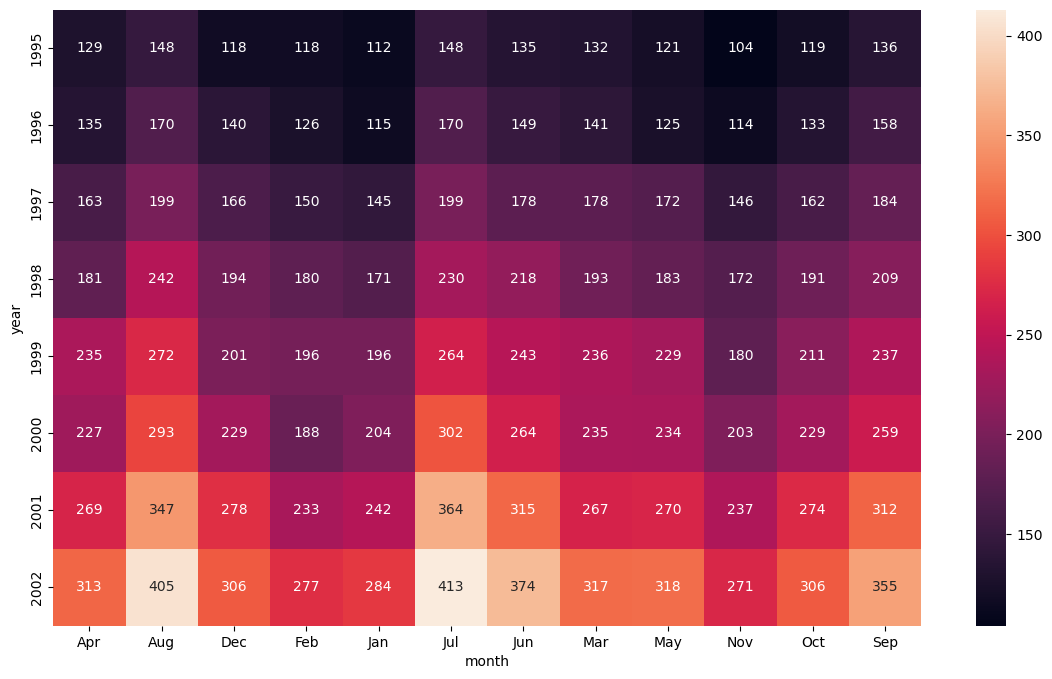

In [14]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values
plt.show()

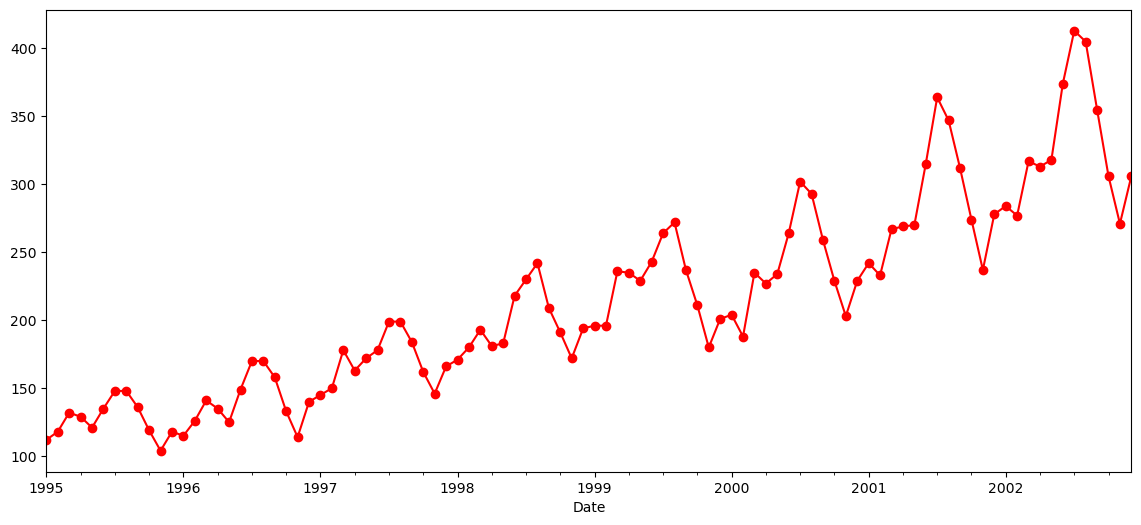

In [15]:
airline['Passengers'].plot(figsize=(14,6),color='red',marker='o')
plt.show()

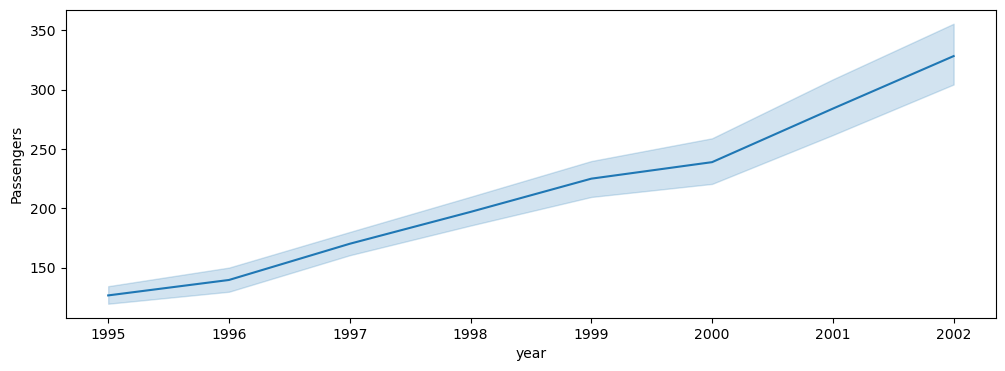

In [16]:
#Yearly Passenger Analysis
plt.figure(figsize=(12,4))
sns.lineplot(x="year", y="Passengers", data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

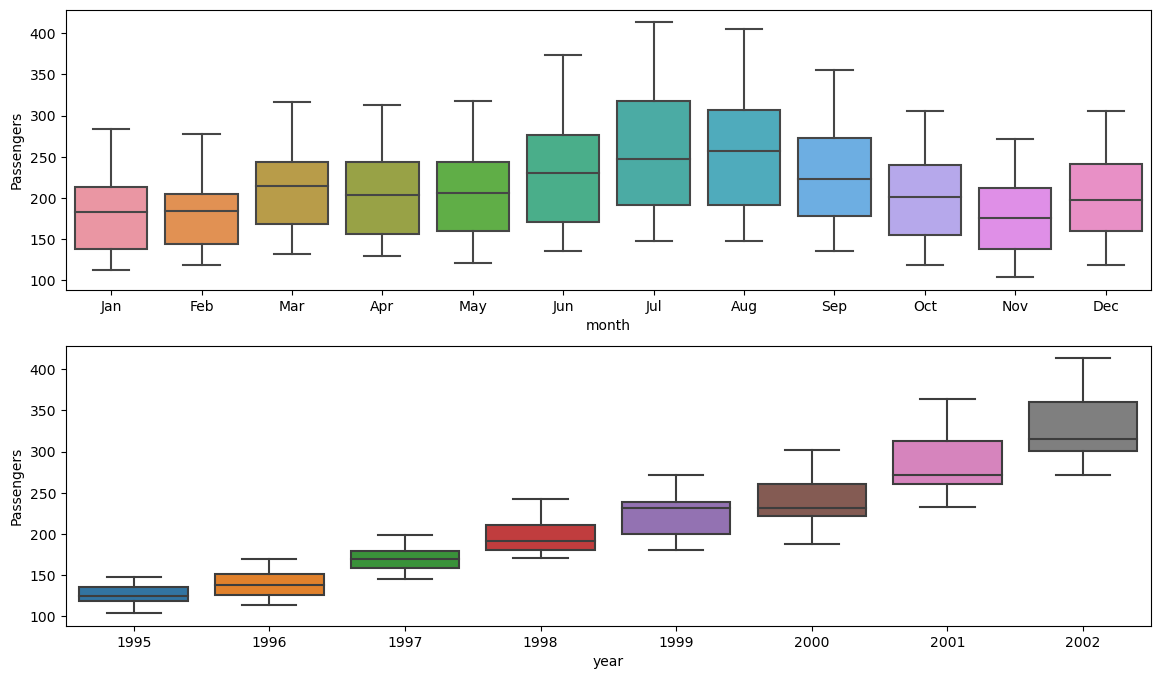

In [17]:
#Box Plot of Each Year by Monthly Intervals
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month", y="Passengers", data=df)
plt.subplot(212)
sns.boxplot(x="year", y="Passengers", data=df)
plt.show()

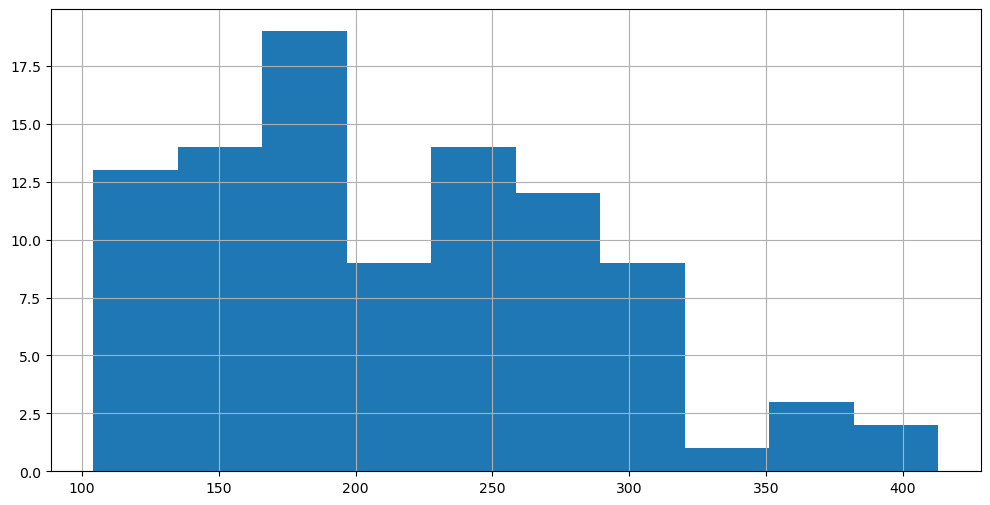

In [18]:
#Histogram and Density Plots
df.Passengers.hist(figsize=(12,6))
plt.show()

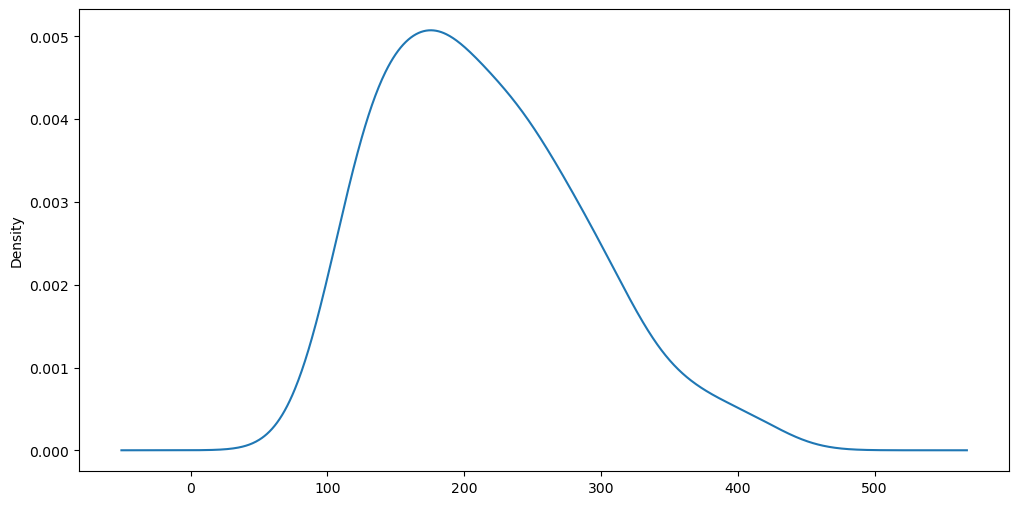

In [19]:
df.Passengers.plot(kind='kde', figsize=(12,6))
plt.show()

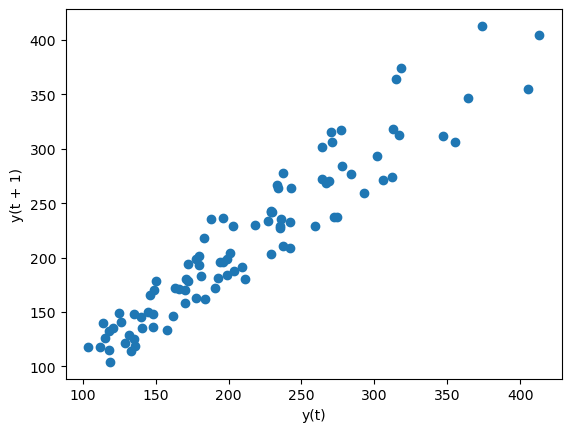

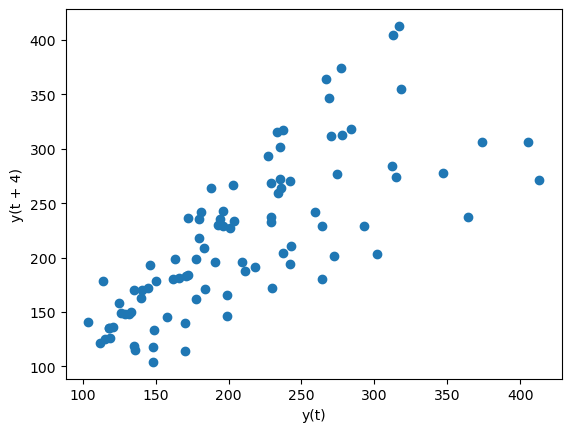

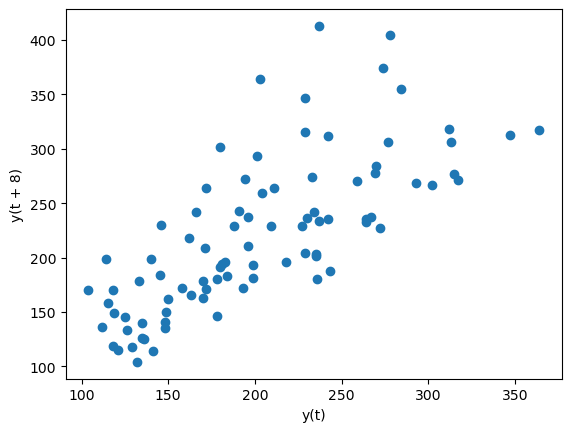

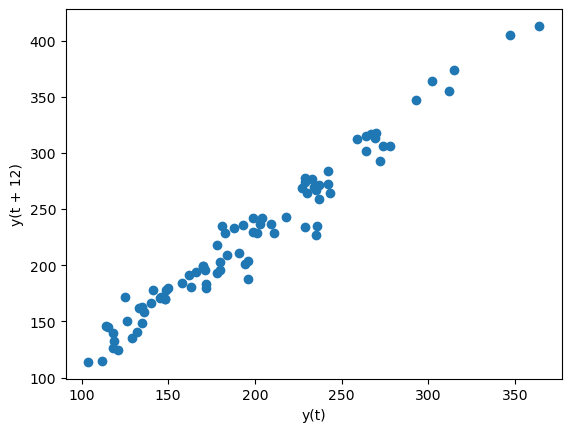

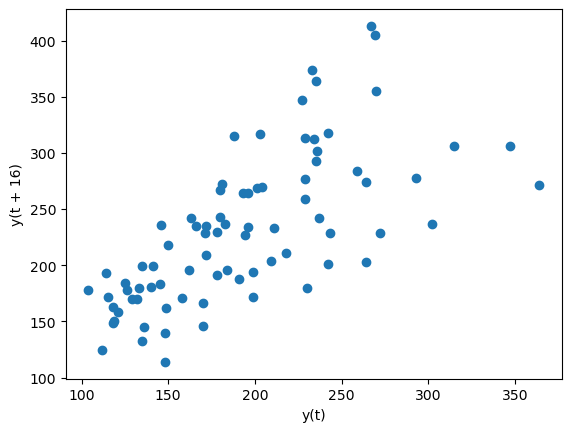

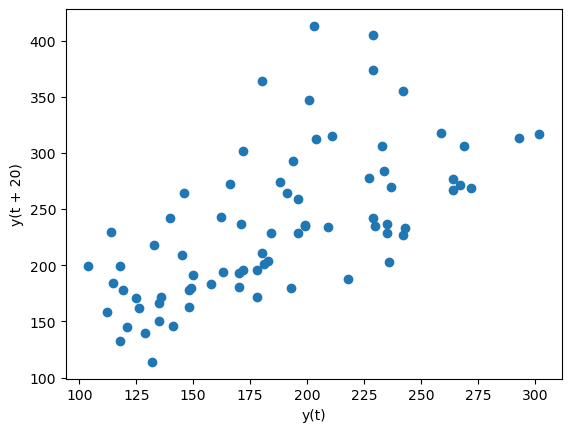

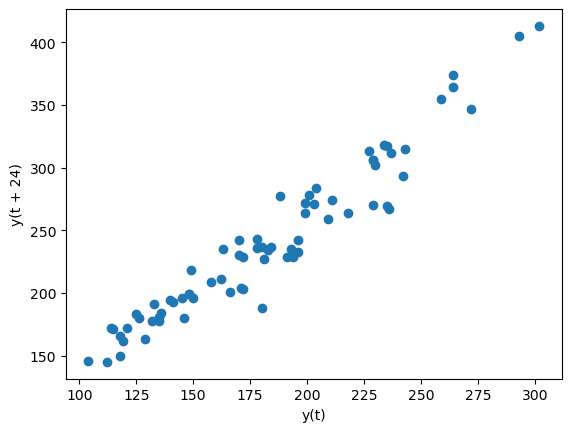

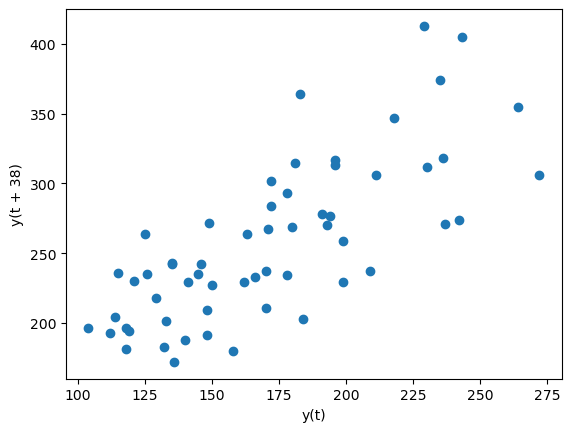

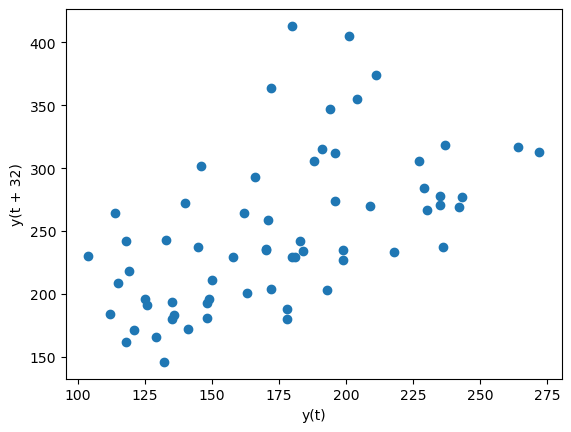

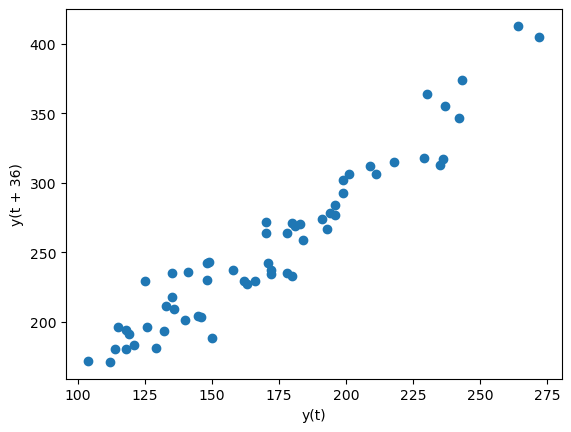

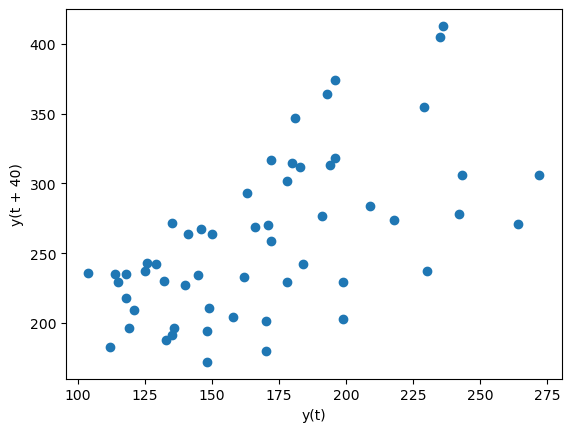

In [20]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

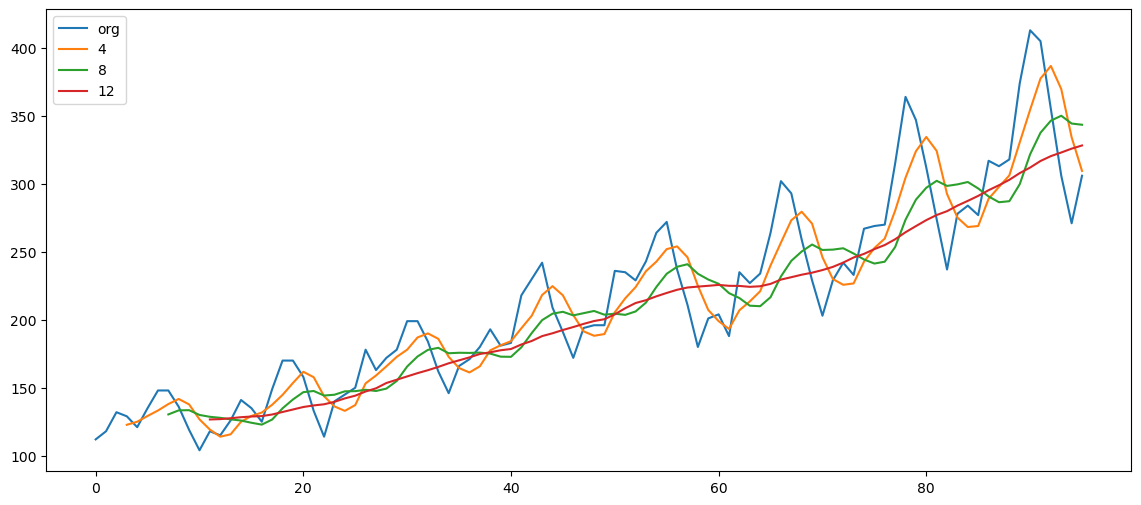

In [21]:
#Moving Average
plt.figure(figsize=(14,6))
df.Passengers.plot(label="org")
for i in range(4,13,4):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

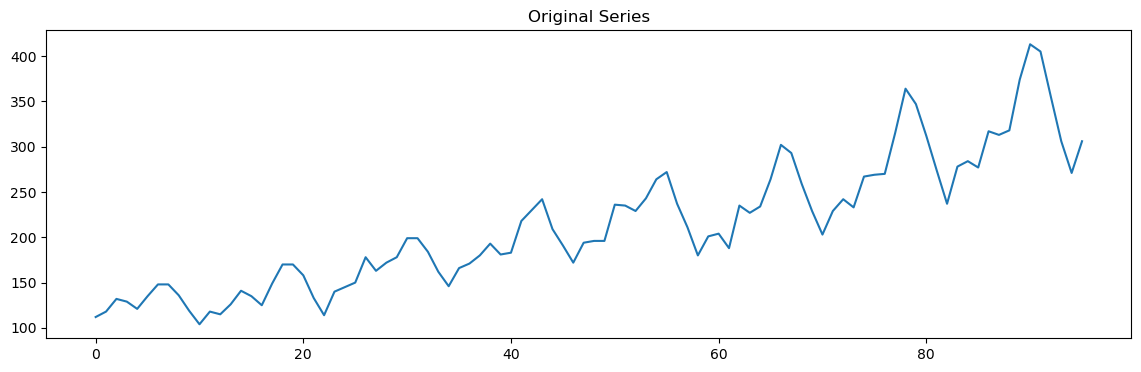

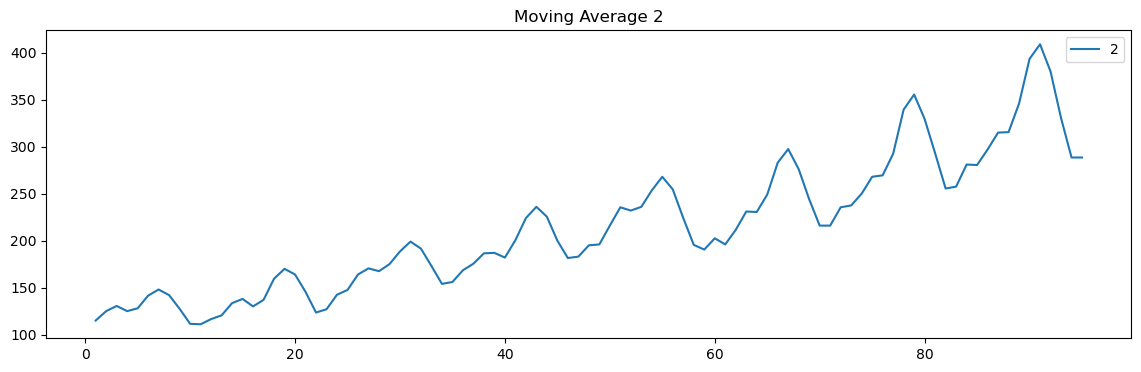

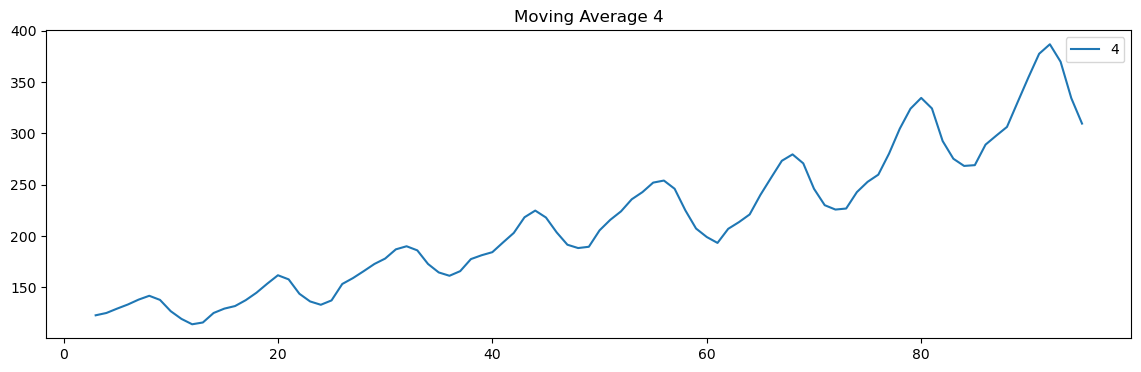

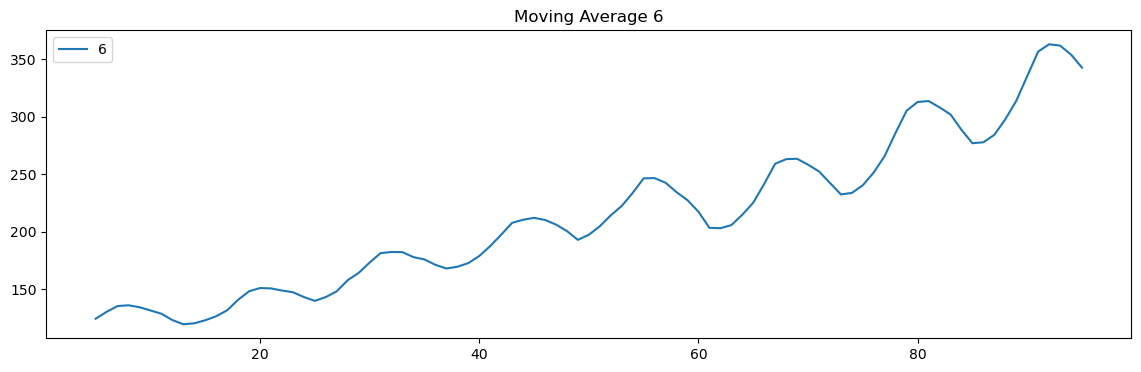

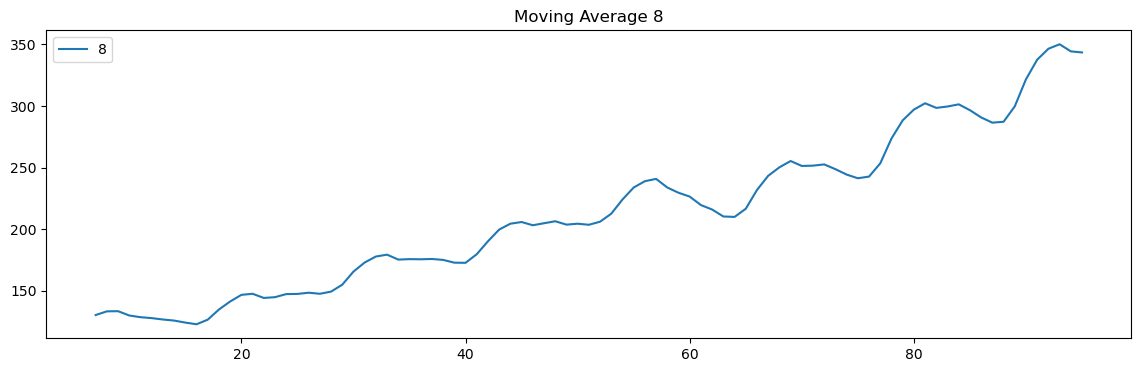

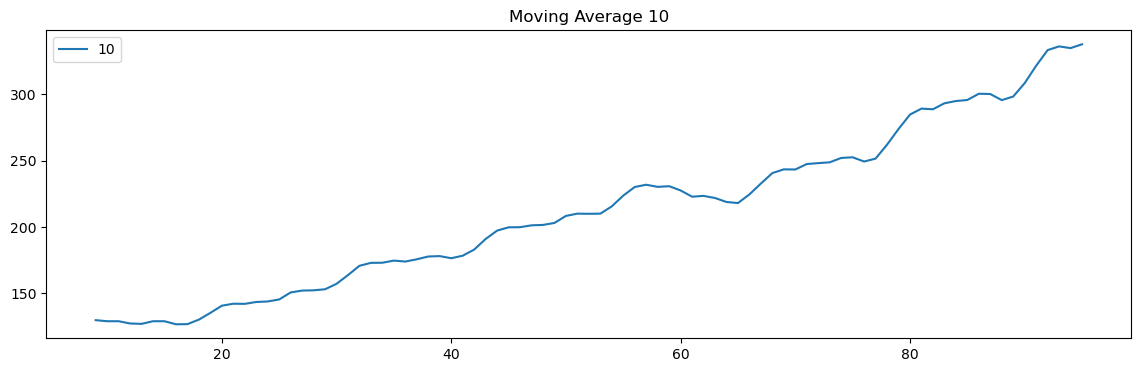

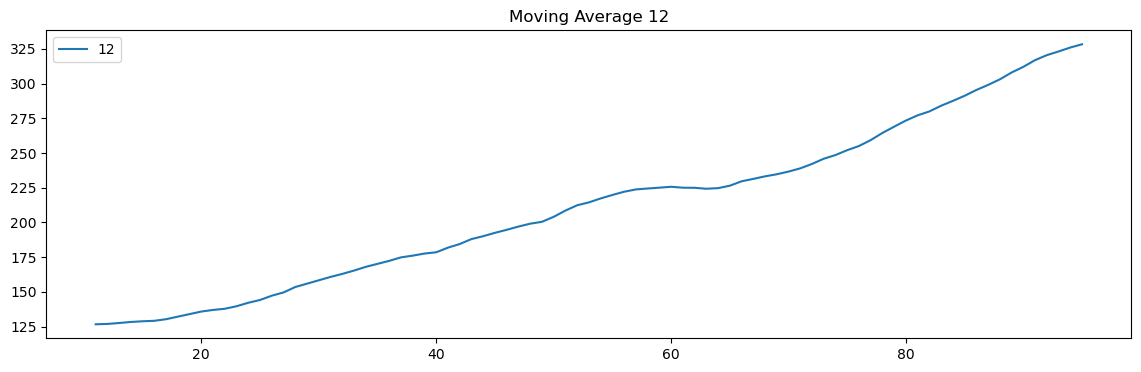

In [22]:
plt.figure(figsize=(14,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13,2):
    plt.figure(figsize=(14,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

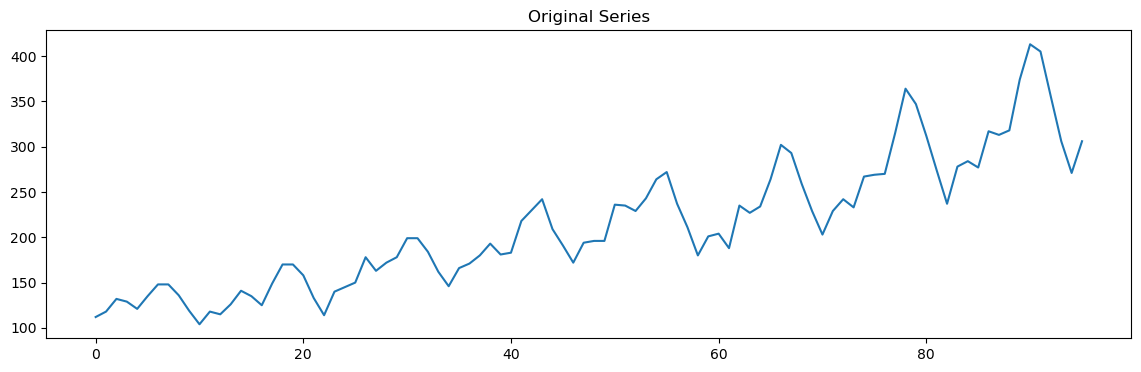

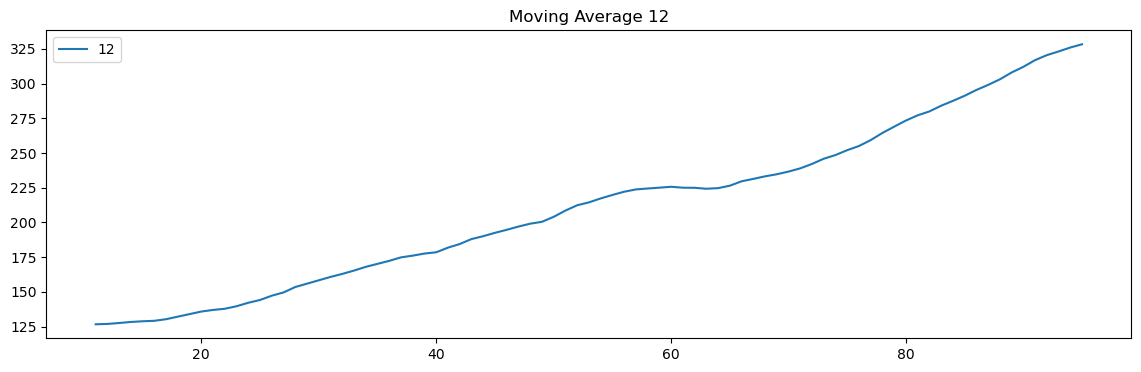

In [23]:
plt.figure(figsize=(14,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(14,4))
df["Passengers"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

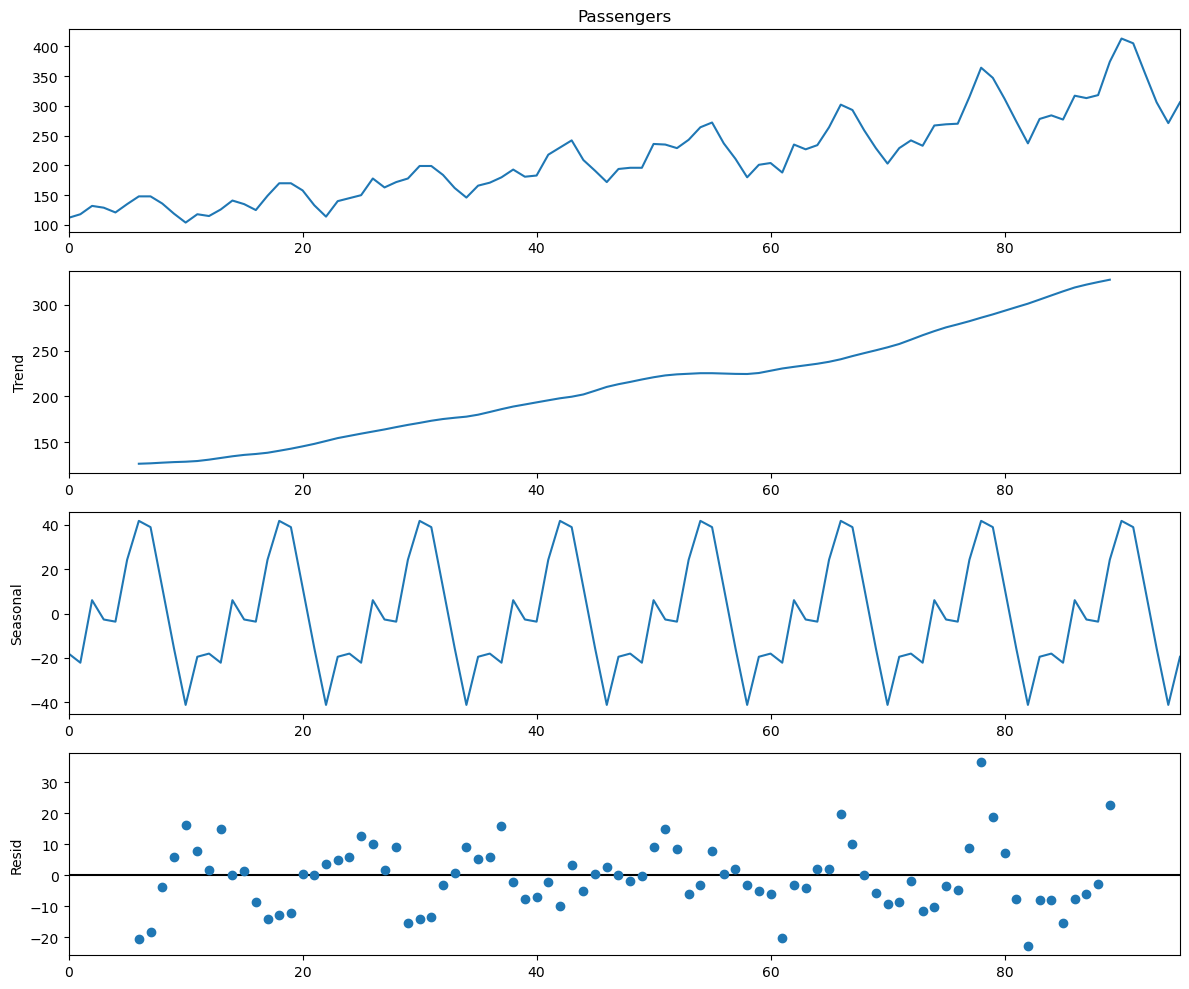

In [24]:
#Time series Decomposition plot
decompose_ts_add = seasonal_decompose(df.Passengers, period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

In [25]:
#ACF plots and PACF plots

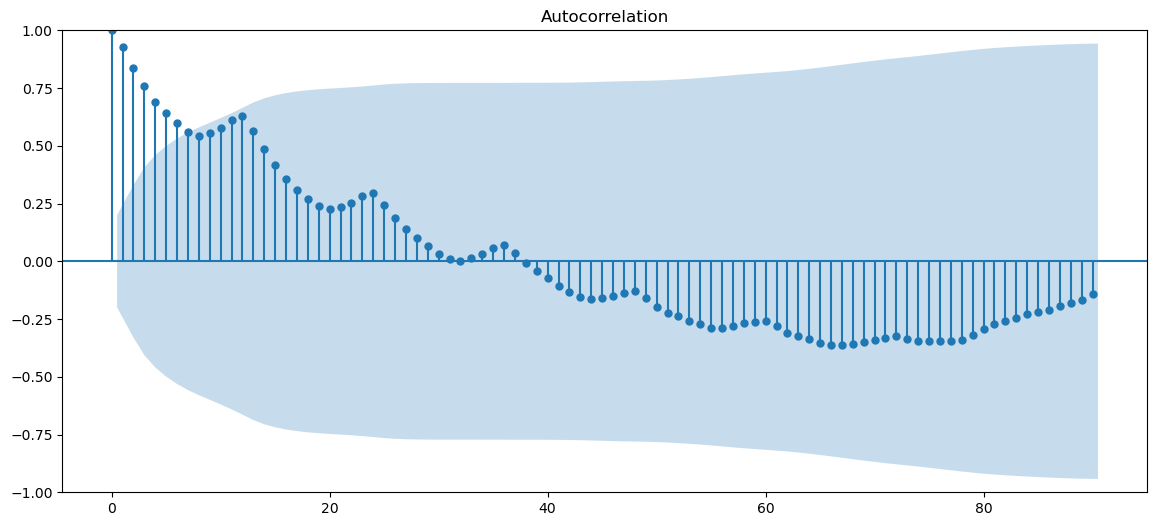

In [26]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(df.Passengers, lags=90)
    plt.show()

In [27]:
#Autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation

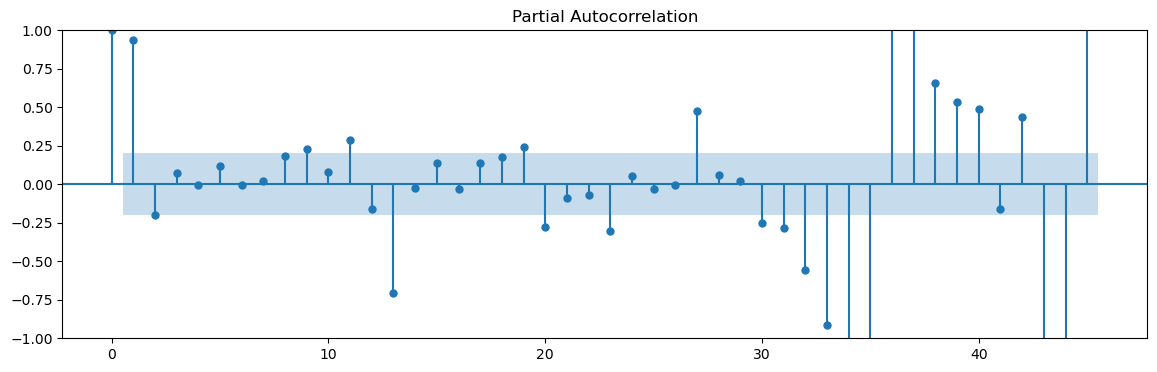

In [28]:
#Partial Autocorrelation Function (PACF)
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_pacf(df.Passengers,lags=45)
    plt.show()

In [29]:
#A partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

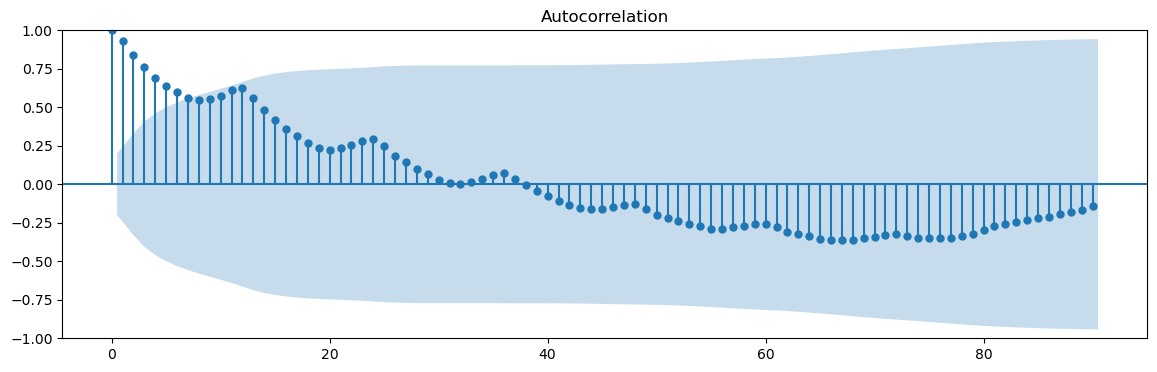

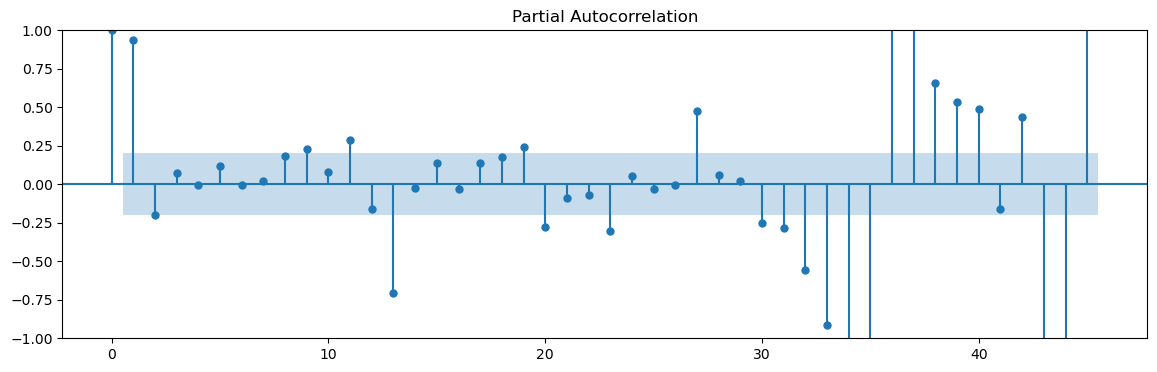

In [30]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_acf(df.Passengers,lags=90)
    tsa_plots.plot_pacf(df.Passengers,lags=45)
    plt.show()
    

In [31]:
visual = airline.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual.head(10)

Passengers       date  year  month  week  quarter day_of_week
0         112 1995-01-01  1995      1    52        1      Sunday
1         118 1995-02-01  1995      2     5        1   Wednesday
2         132 1995-03-01  1995      3     9        1   Wednesday
3         129 1995-04-01  1995      4    13        2    Saturday
4         121 1995-05-01  1995      5    18        2      Monday
5         135 1995-06-01  1995      6    22        2    Thursday
6         148 1995-07-01  1995      7    26        3    Saturday
7         148 1995-08-01  1995      8    31        3     Tuesday
8         136 1995-09-01  1995      9    35        3      Friday
9         119 1995-10-01  1995     10    39        4      Sunday

In [32]:
visual.year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002], dtype=int64)

# Time Series Decomposition
1. Seasonality
2. Trend

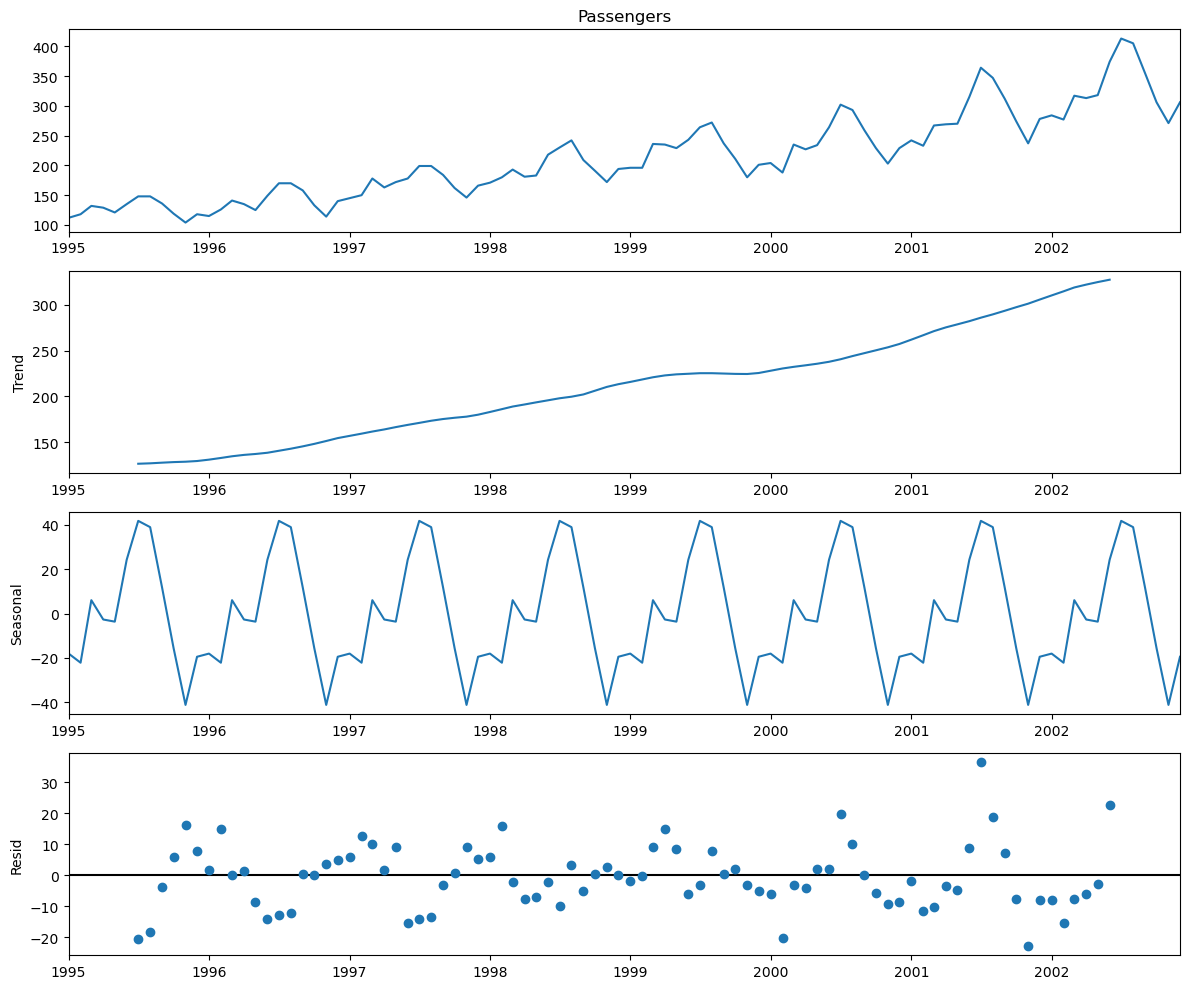

In [33]:
#Additive Seasonal Decomposition
decompose_ts_add = seasonal_decompose(airline.Passengers, period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

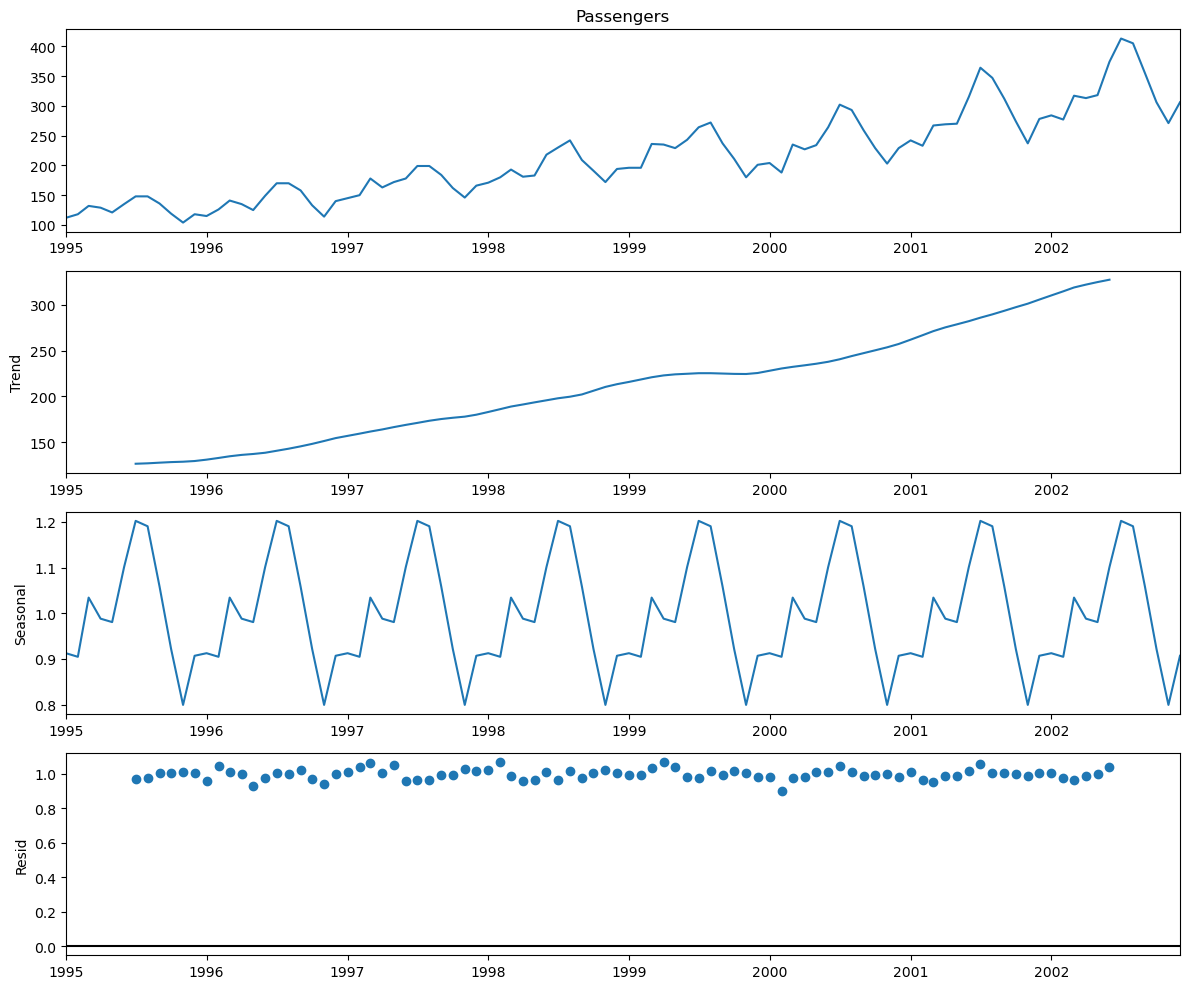

In [34]:
#Multiplicative Seasonal Decomposition
decompose_ts_add = seasonal_decompose(airline.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

In [35]:
#Splitting Train and Test Data
size = 72
train_data = airline[:size]
test_data = airline[size:]

In [36]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


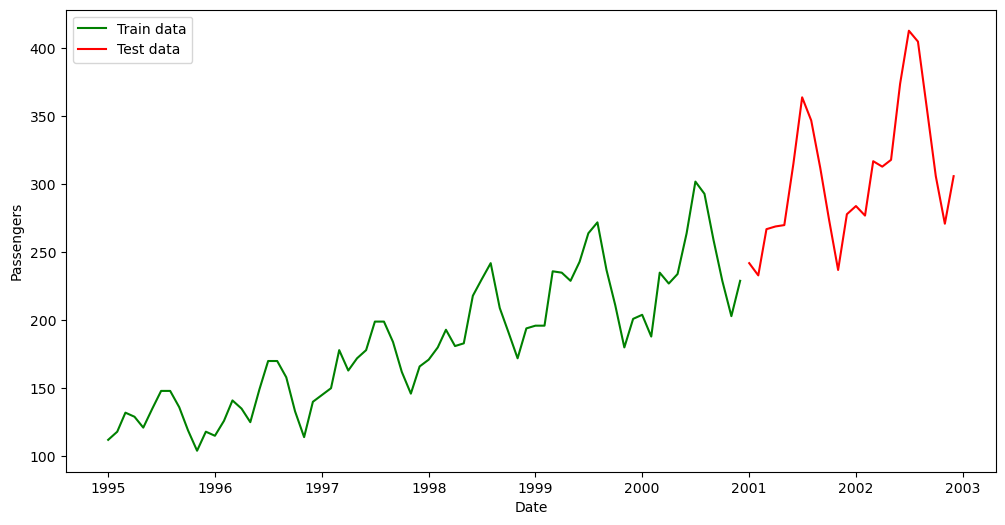

In [37]:
#We are going to forecast for the last two years. 2001 and 2002.
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.show()

In [38]:
#Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Exponential Methods

In [39]:
#Simple Exponential Method
#Using Forecast Attribute

In [40]:
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 23.38228335004472 
 Train Root Mean Squared Error = 19.031771730910982 
 Test Root Mean Squared Error  = 91.11325402904403


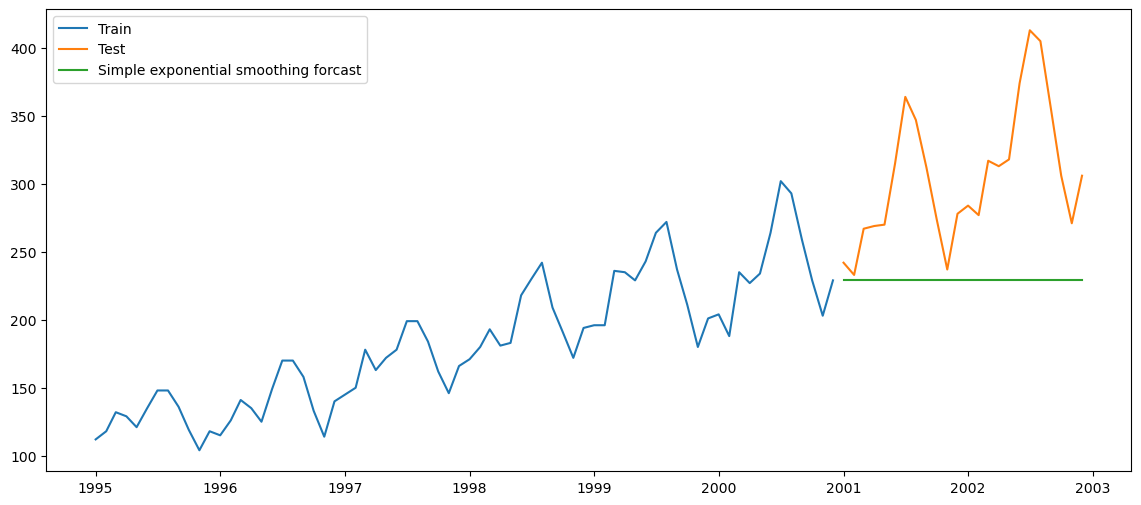

In [41]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [42]:
#No seasonality captures.
#Most recent observation gets higher weightages than the older ones for forecasting.

In [43]:
#Holt method (Double Exponential)
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 17.148981696358685 
 Train Root Mean Squared Error = 18.96128999459111 
 Test Root Mean Squared Error  = 71.63464300883933


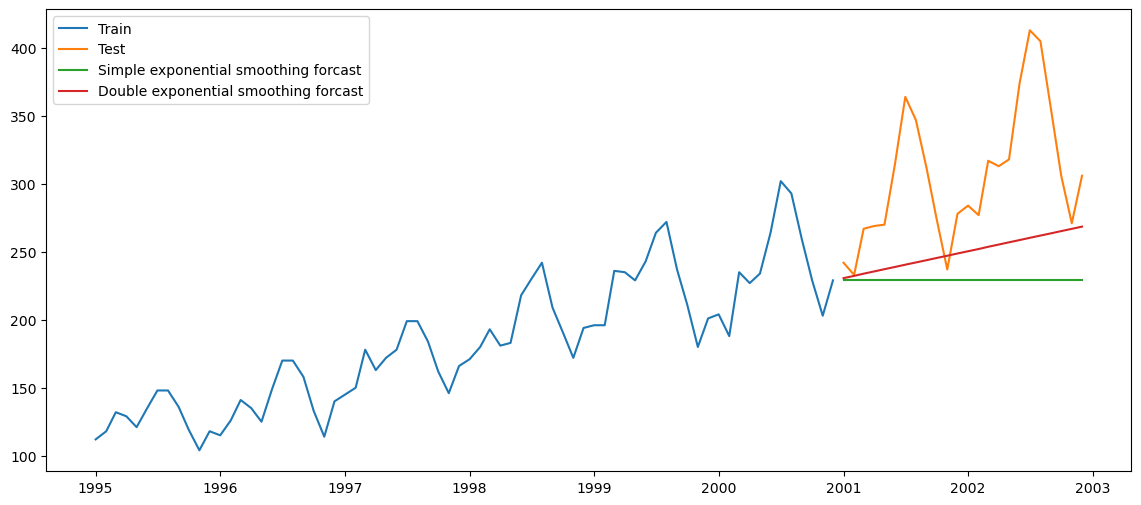

In [44]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [45]:
#We can see that we are able to capture the trend of the data.
#We were not able to capture the seasonality.

In [46]:
#Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

In [47]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 12.084508619943344 
 Train Root Mean Squared Error = 7.75130351137479 
 Test Root Mean Squared Error  = 47.5692832638379


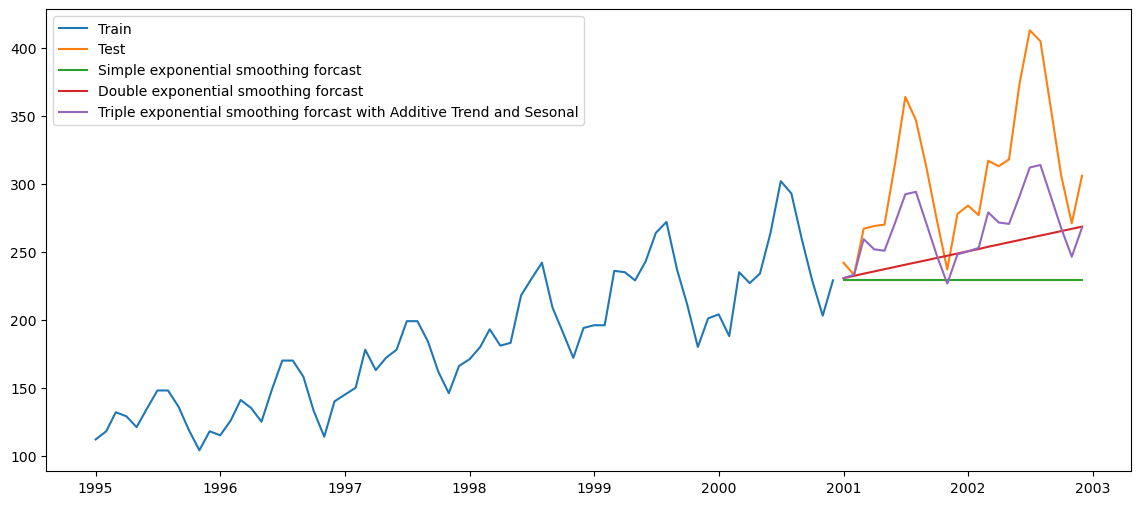

In [48]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

In [49]:
#It captures the trend, which we can see that the forecasted values are lower level than the test level.
#It also captures the seasonality.
#The peak of the forecasted value is lower than the actual.

In [50]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [51]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error   = 9.368354573562142 
 Train Root Mean Squared Error = 6.386634437793857 
 Test Root Mean Squared Error  = 34.989365374325125


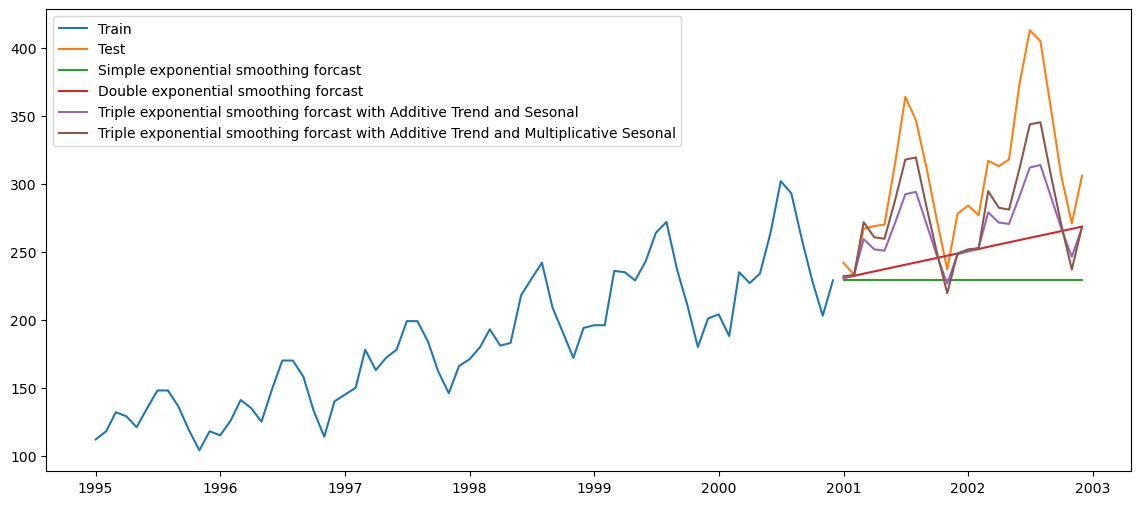

In [52]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

In [53]:
#e can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

In [54]:
#Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [55]:
texp_ad_mul_model = ExponentialSmoothing(train_data,seasonal="add",trend="mul",
                    seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Passengers))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Passengers)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error   = 12.932828408981294 
 Train Root Mean Squared Error = 12.749205006763182 
 Test Root Mean Squared Error  = 46.72864658311806


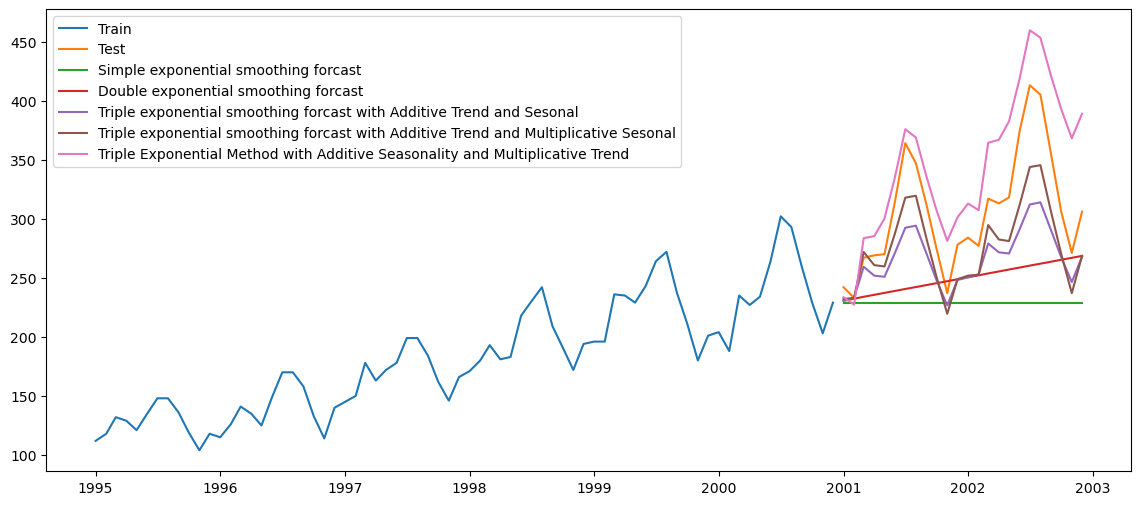

In [56]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

In [57]:
#It captures the trend, which we can see that the forecasted values are higher level than the test level.
#It also captures the seasonality.
#The peak of the forecasted value is higher than the actual.

In [58]:
#Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [59]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Passengers))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Passengers)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error   = 6.034483884370215 
 Train Root Mean Squared Error = 6.3967514247667365 
 Test Root Mean Squared Error  = 23.05679851513917


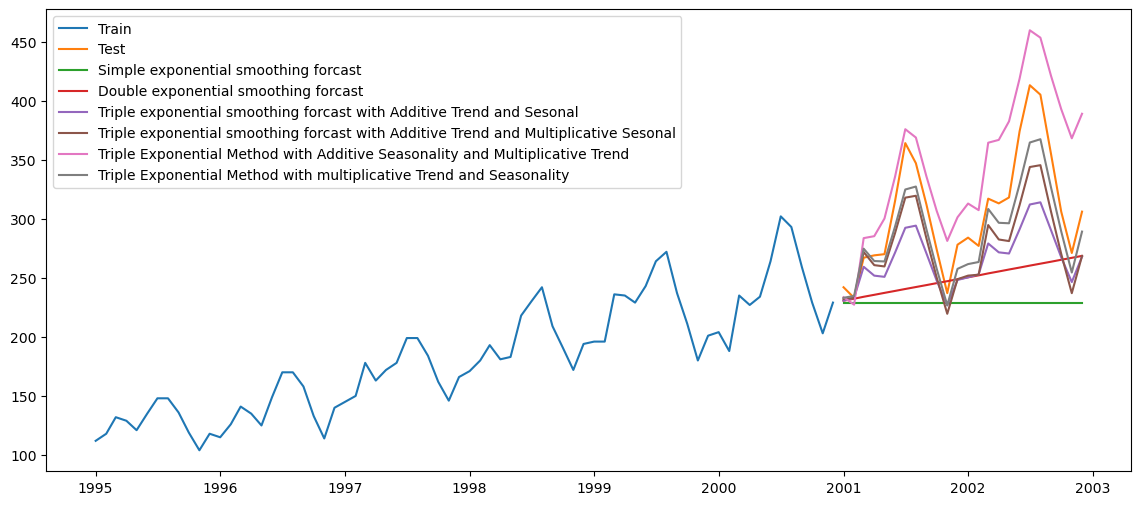

In [60]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [62]:
#Comparing the results
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul"]),
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation = pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0      Triple_Exp_Mul    6.396751      6.034484         23.056799
1  Triple_Exp_Mul_Add    6.386634      9.368355         34.989365
2      Triple_Exp_Add    7.751304     12.084509         47.569283
3  Triple_Exp_Add_Mul   12.749205     12.932828         46.728647
4          Double_Exp   18.961290     17.148982         71.634643
5          Simple_Exp   19.031772     23.382283         91.113254

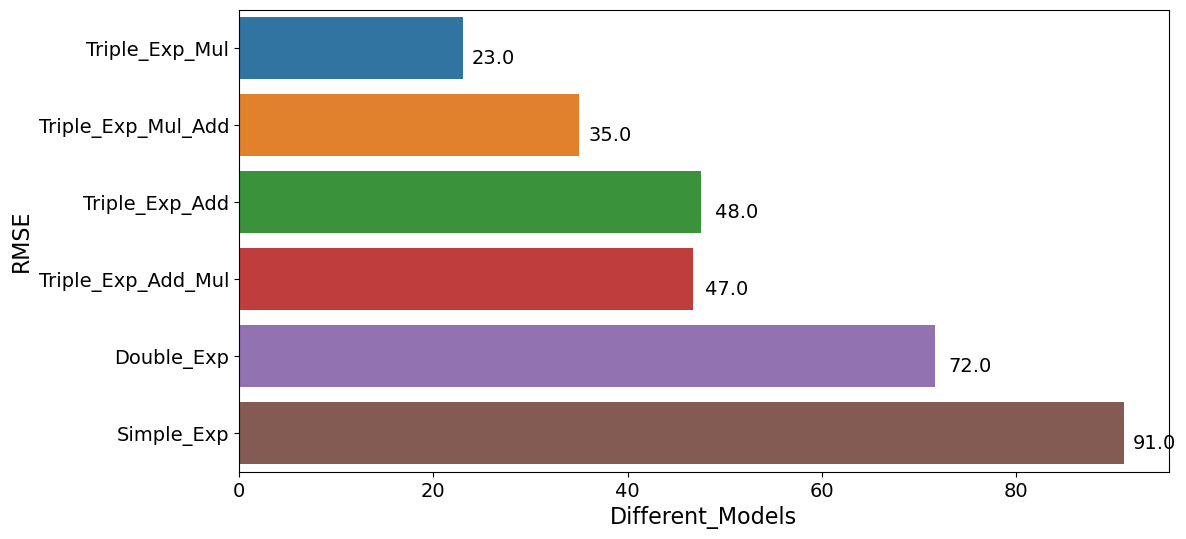

In [63]:
#Visualizing Models Performance
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x= 'Test_RMSE_Values', y= 'Models', data= table_evaluation, ax= axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize= 14)
plt.xticks(fontsize= 14)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontsize= 14)
plt.show()

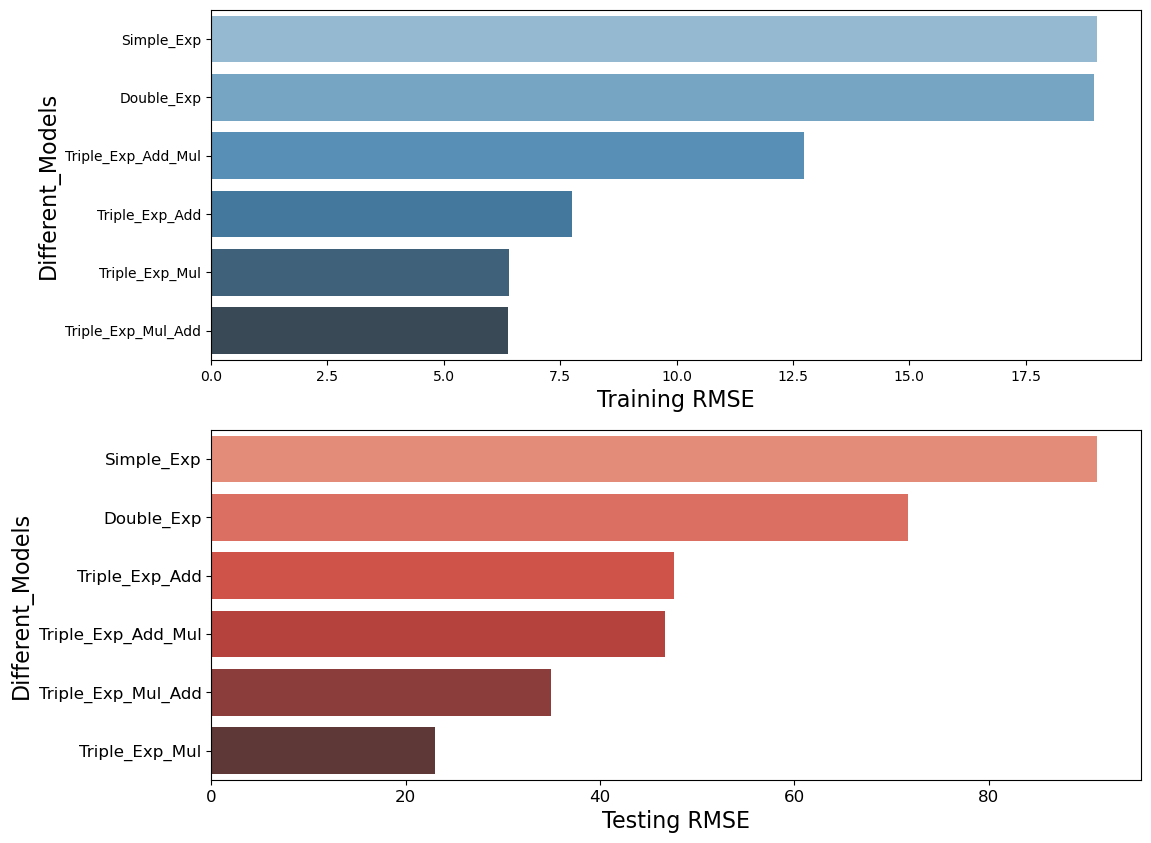

In [64]:
f, axes = plt.subplots(2,1, figsize=(12,10))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models', size=16)

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models', size=16)

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

In [65]:
#Stationary vs Non-stationary Time Series
 #Test of Stationarity

In [66]:
def test_stationarity(timeseries):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

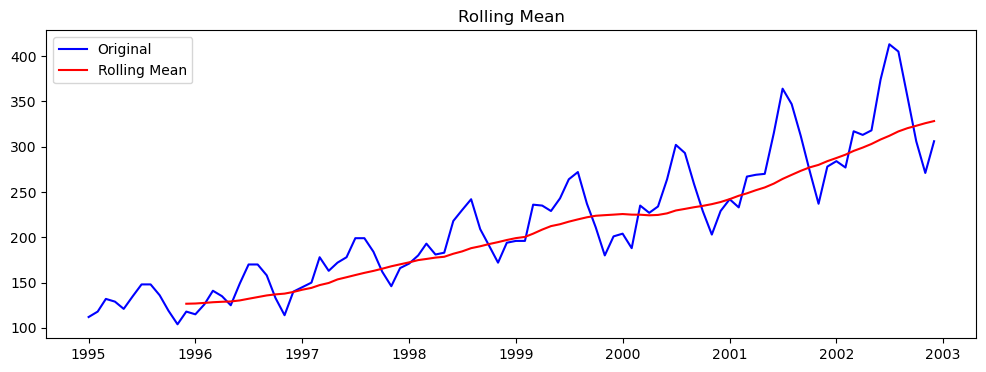

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [67]:
plt.figure(figsize=(12,4))
sales= pd.DataFrame()
sales['Passengers'] = airline[['Passengers']]
test_stationarity(sales)

In [68]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [69]:
adf_test(sales)

Fail to reject the null hypothesis
Data is non-stationary


# Feature Scaling

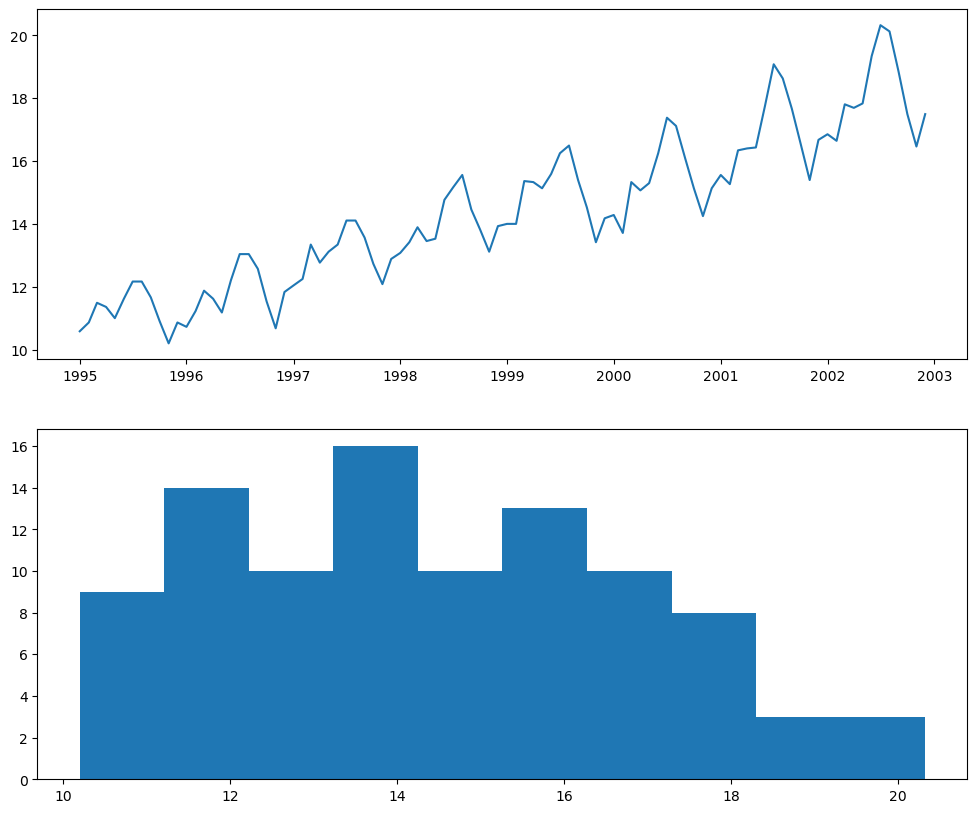

In [70]:
# 1. Square Root Transform


square_root= pd.DataFrame()
square_root = airline[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

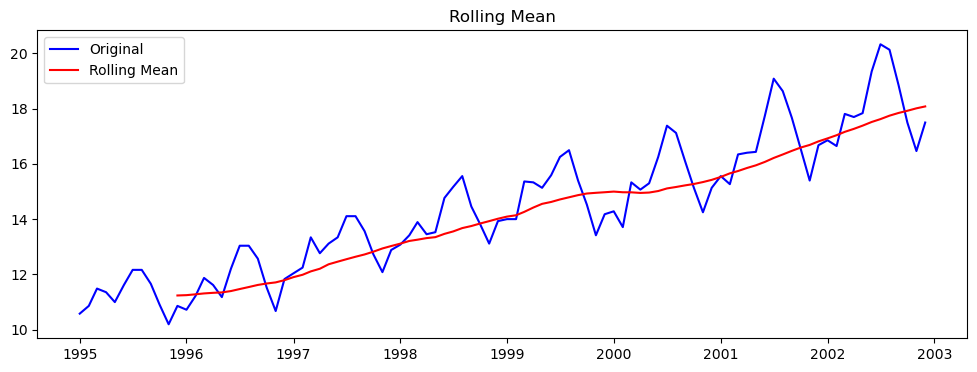

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [71]:
plt.figure(figsize=(12,4))
test_stationarity(square_root)

In [72]:
adf_test(square_root)

Fail to reject the null hypothesis
Data is non-stationary


In [73]:
# 2. Log Transform

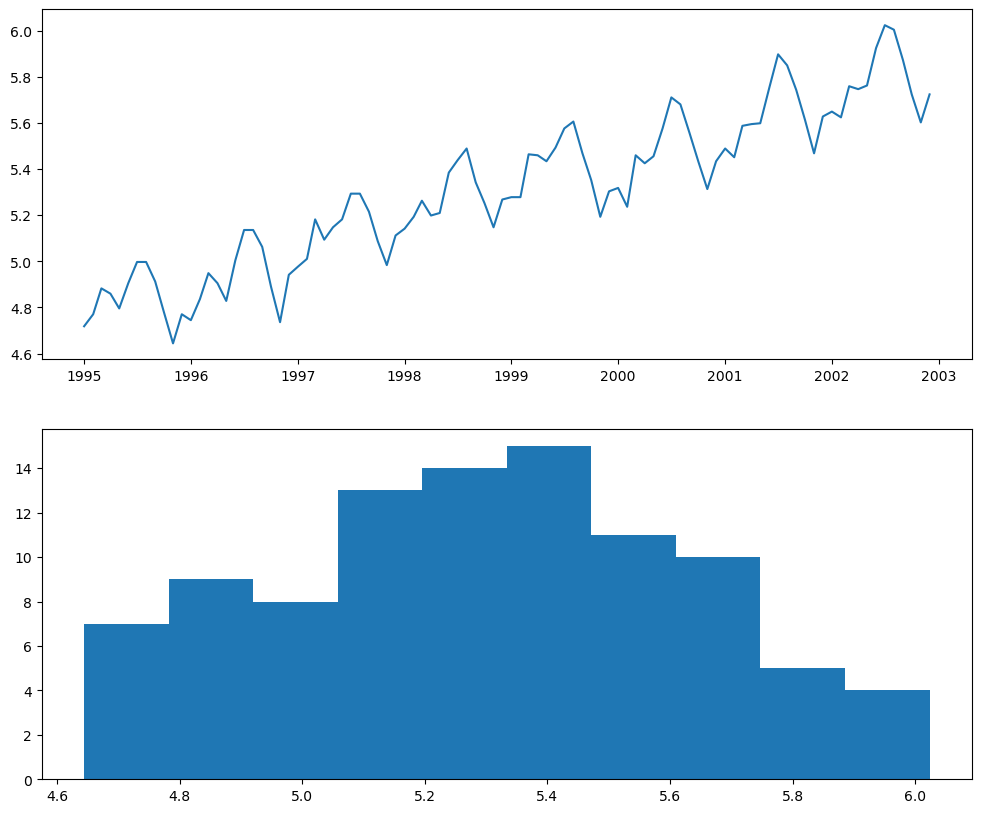

In [74]:
log = pd.DataFrame()
log = airline[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig = plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])

# Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

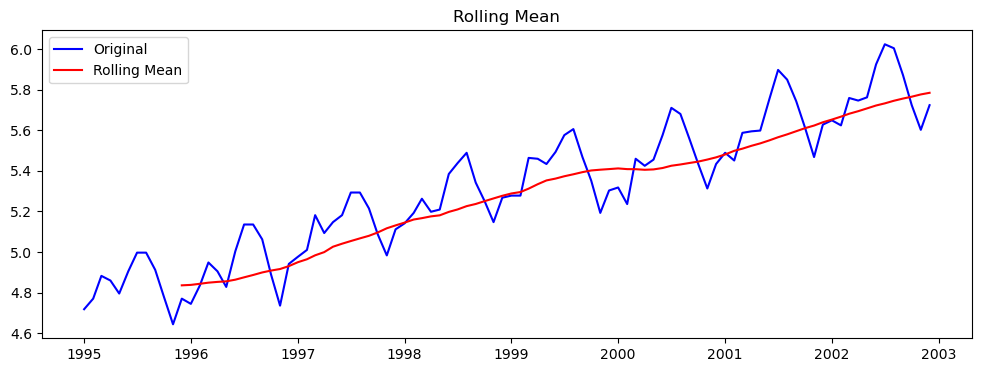

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [75]:
plt.figure(figsize=(12,4))
test_stationarity(log)

In [76]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


In [77]:
#Hence, the Time series data is Non-Stationary

In [78]:
# 3. Converting Non-Stationary Time Series into Stationary

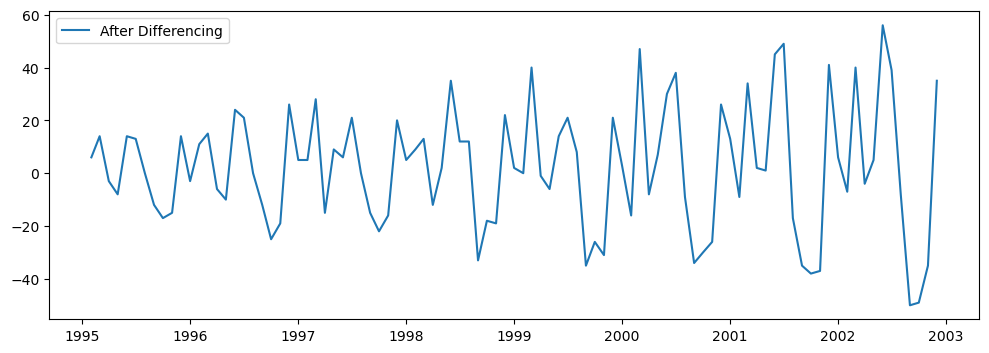

In [86]:
#Differencing
differencing = airline - airline.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

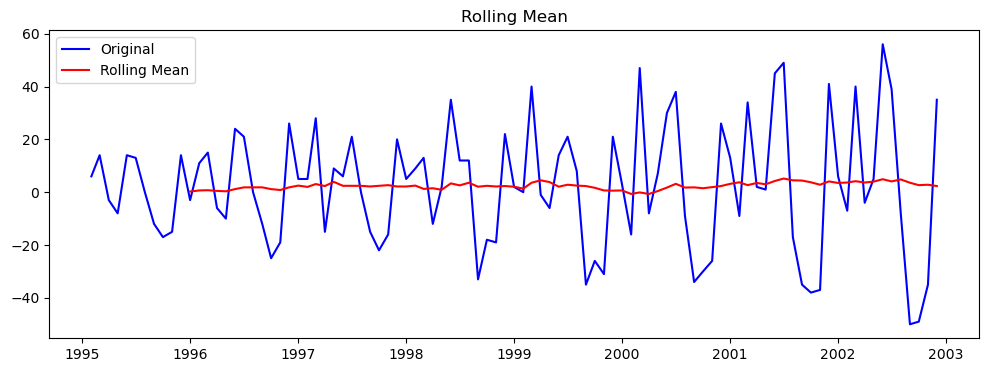

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [80]:
plt.figure(figsize=(12,4))
test_stationarity(differencing)


In [81]:
adf_test(differencing)

Fail to reject the null hypothesis
Data is non-stationary


In [82]:
#Seasonal Differencing

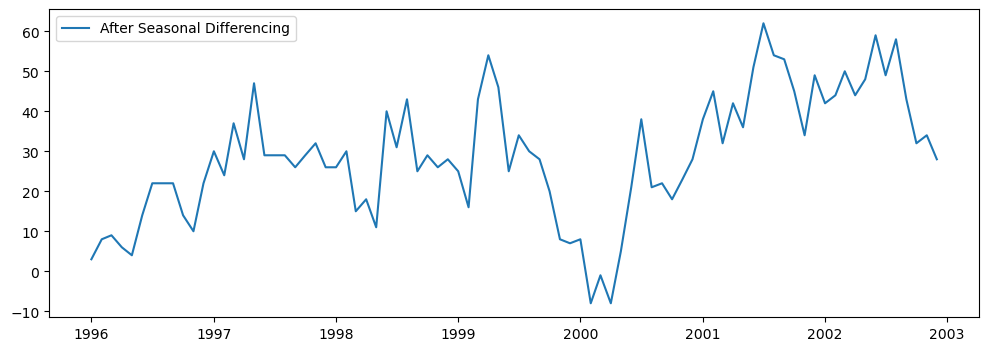

In [83]:
seasonal_differencing = airline - airline.shift(12)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

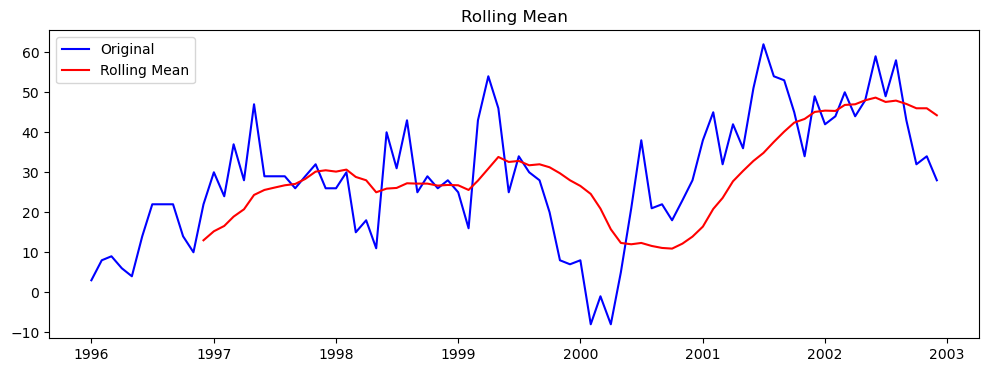

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [84]:
plt.figure(figsize=(12,4))
test_stationarity(seasonal_differencing)

In [85]:
adf_test(seasonal_differencing)

Fail to reject the null hypothesis
Data is non-stationary


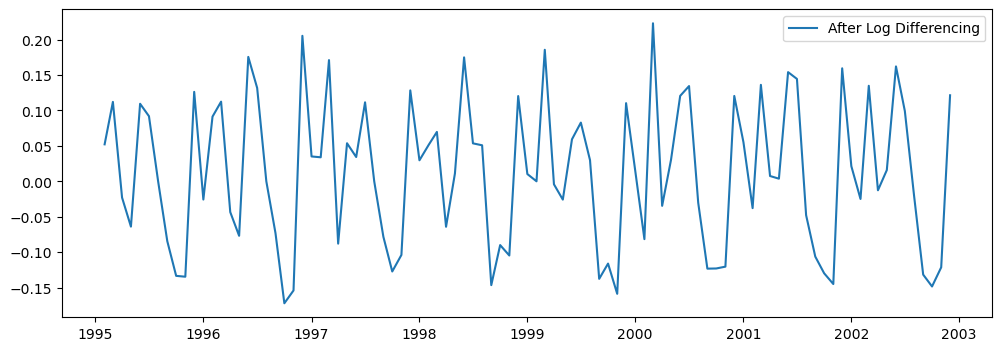

In [87]:
#Transformation
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

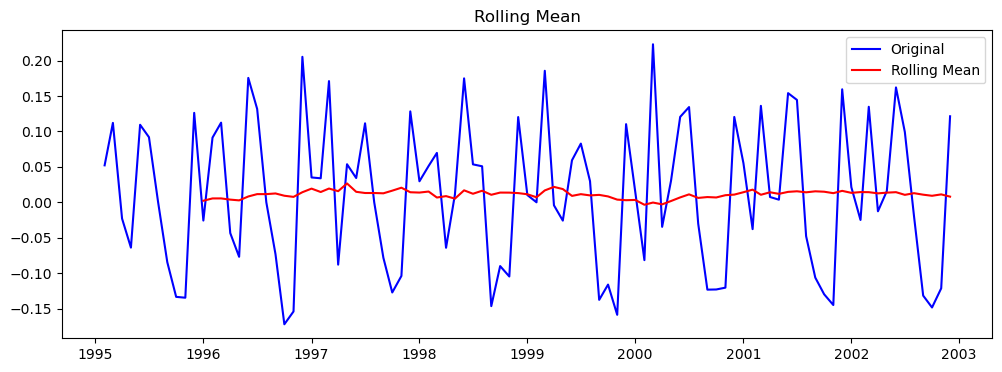

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [88]:
plt.figure(figsize=(12,4))
test_stationarity(log_diff)

In [89]:
adf_test(log_diff)

Fail to reject the null hypothesis
Data is non-stationary


Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791

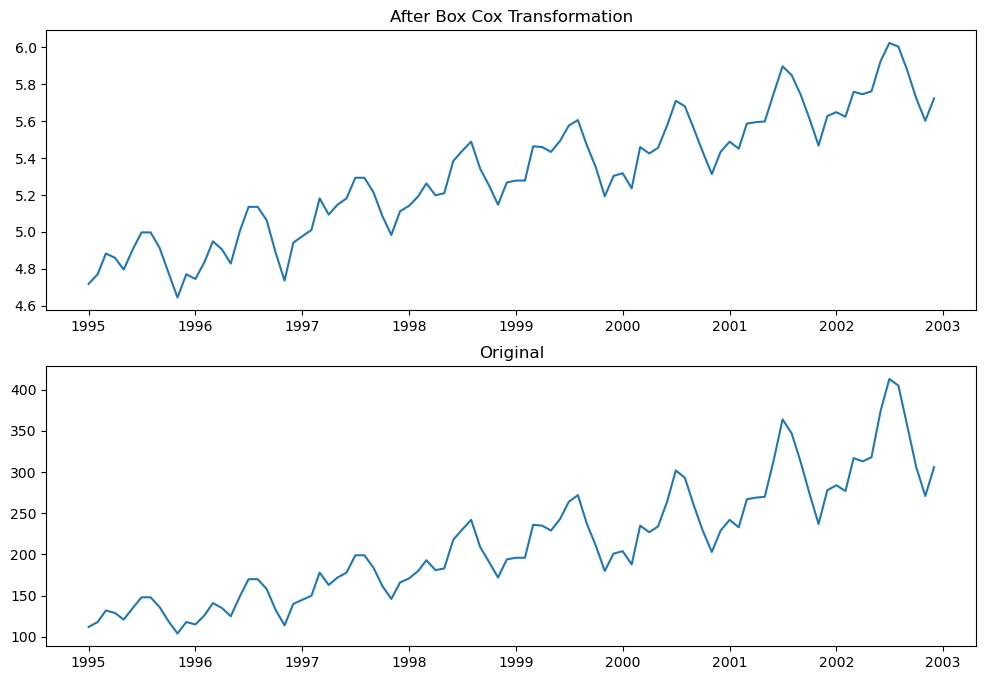

In [90]:
#Box Cox Transformation
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(airline['Passengers'], lmbda=0), airline.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(12,8),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(airline, label='original')
axis[1].set_title('Original')
plt.show()

In [91]:
#We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
#But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing for making the mean constant.

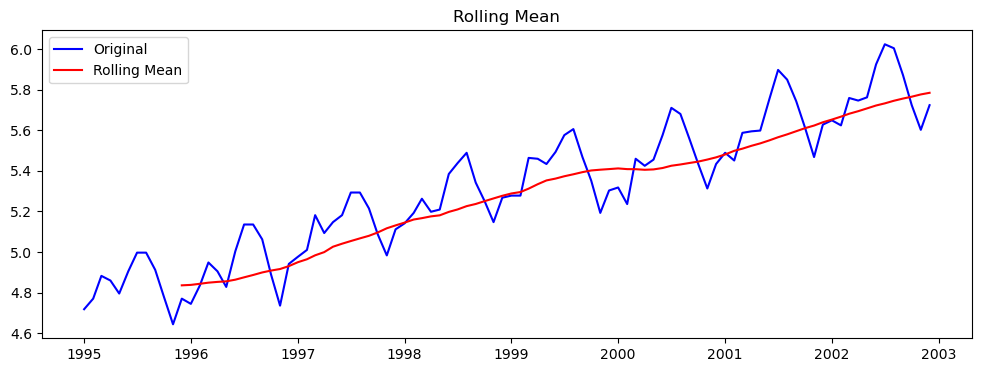

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [92]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox)

In [93]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


# Differencing of the Box-Cox Transformation

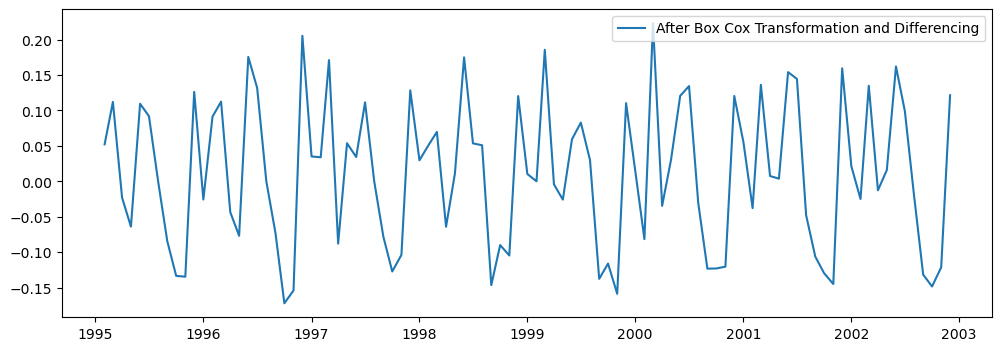

In [94]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

In [95]:
#We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation.
#It is a horizontal trend.
#The mean became constant. The mean is zero.
#Also, the variance is almost constant.

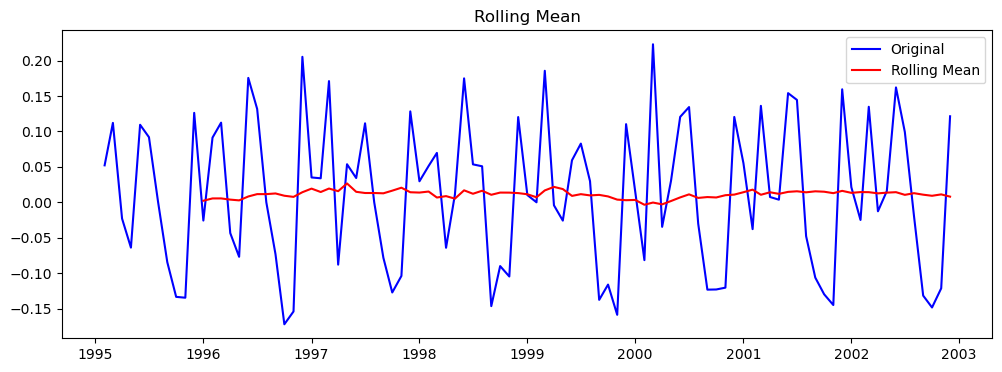

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [96]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox_diff)

In [97]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


In [98]:
#Building The Time Series Forecasting with Optimal Value using ARIMA

In [99]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

In [100]:
#ARIMA Hyperparameter Tuning
# Grid search ARIMA parameters for a time series
# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [103]:
# Evaluate parameters
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Passengers, p_values, d_values, q_values)

Best ARIMA(4, 1, 4) RMSE=0.093


In [104]:
#Inverse transformation of the Box-Cox Differencing

In [105]:
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()

# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])

# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

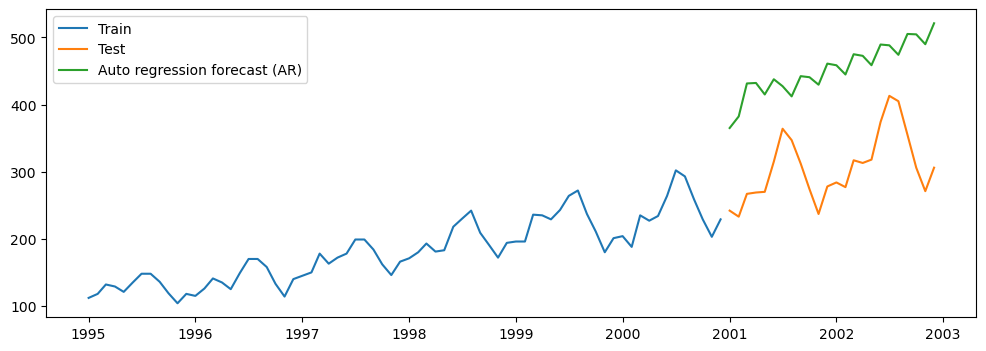

In [106]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [107]:
#We can see that we have done moderately well.
#No Seasonality captured. Only Trend has been captured

# Model Evaluation

In [108]:
#RMSE
rmse_arima = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

152.69

In [109]:
#MAPE
mape_arima = round(np.mean(np.abs((test_data.Passengers - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_arima

50.3

In [110]:
#We can see that AR model has done reasonably good job but not better than Holt's method.
#We souldn't compare it with Holt's method. Because Holt's method captures seasonality

# Analysing the Residuals

In [111]:
#The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

-0.005710495061703933

In [112]:
#Residuals must be stationary
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


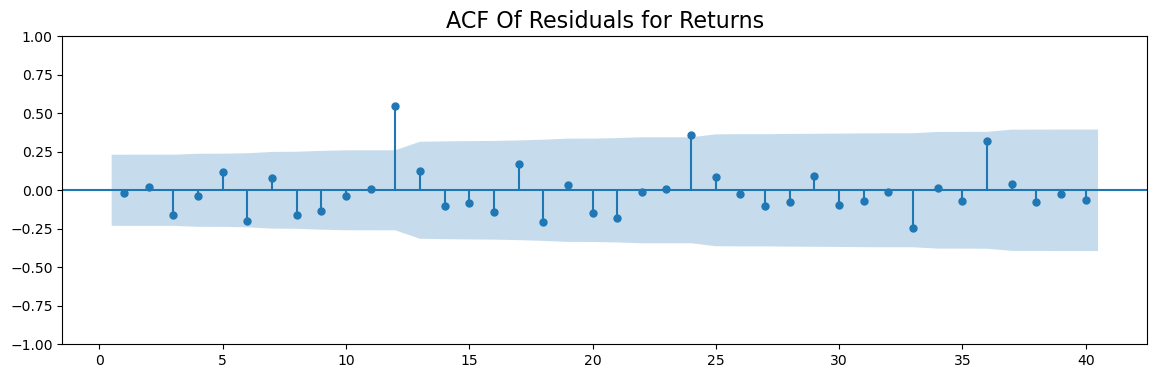

In [113]:
#No autocorrelation between Residuals
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

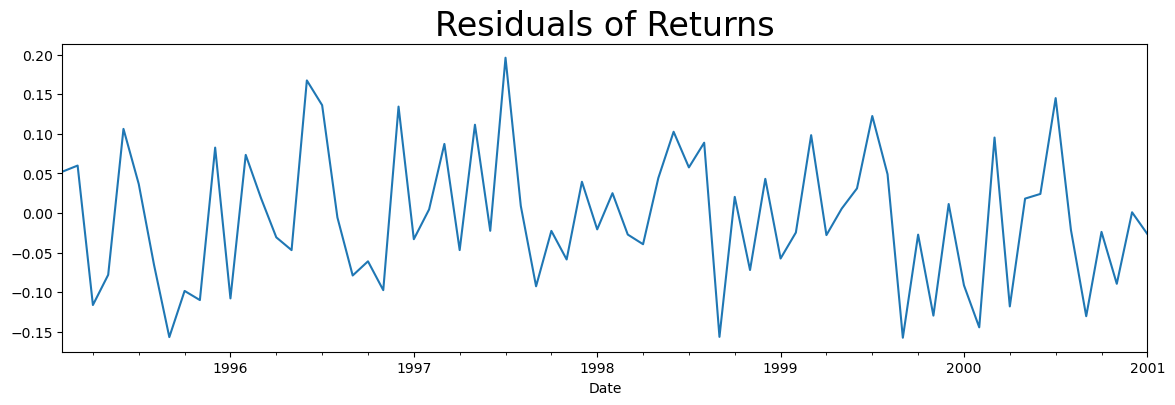

In [114]:
#Residuals must be Random
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

In [115]:
#Seasonal Auto Regressive Integrated Moving Average (SARIMA)
#We are only passing the Box Cox because the ARIMAX will perform the differencing internally
#seasonal_order P=1, Q=1, D=1 and m=12 || m=12 . Because the seasonality is monthly.

In [116]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [117]:
#Inverse Transformation of the Differencing Box-Cox Transformation

In [118]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

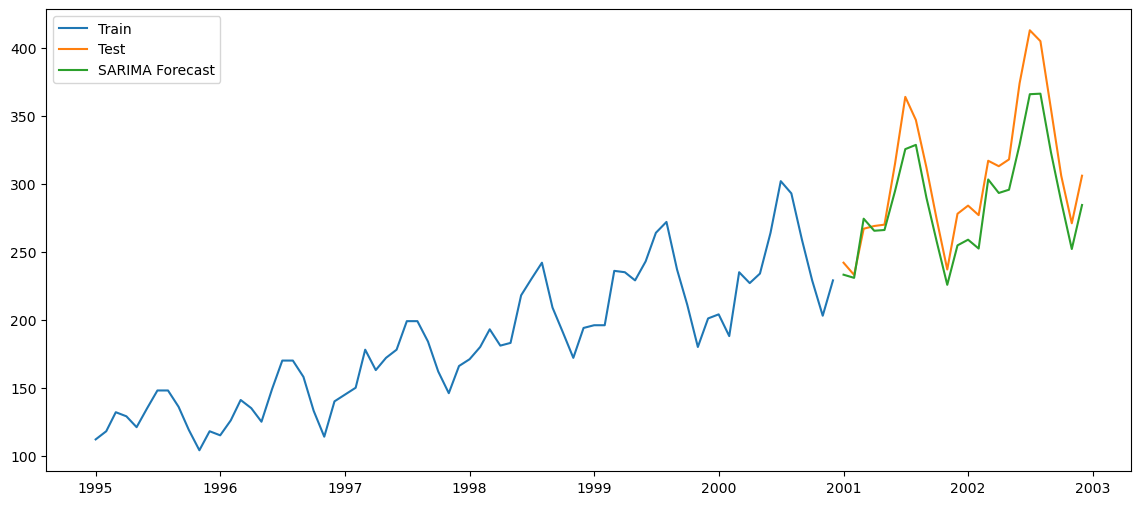

In [119]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [120]:
#We can see that we are able to capture the trend and seasonality both.

# Model Evaluation

In [121]:
#RMSE
rmse_sarima = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_sarima

24.2

In [122]:
#MAPE
mape_sarima = round(np.mean(np.abs((test_data.Passengers - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_sarima

6.5

In [123]:
#SARIMA method has done reasonably well as it captures seasonality.
#The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality.

In [124]:
#Analysing Residuals
model_residual = model_fit.resid
model_residual.mean()

0.03583653482734888

In [125]:
#Residuals must be stationary
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


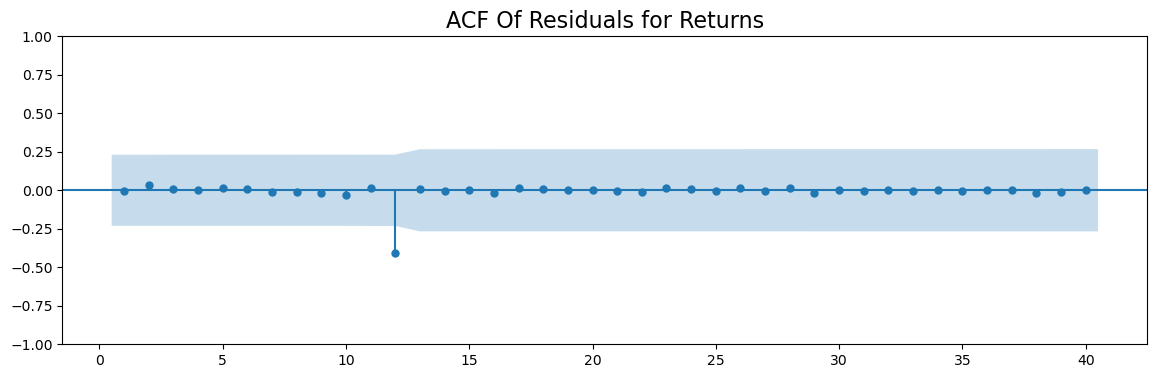

In [126]:
#No autocorrelation b/w residuals
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size= 16)
plt.show()

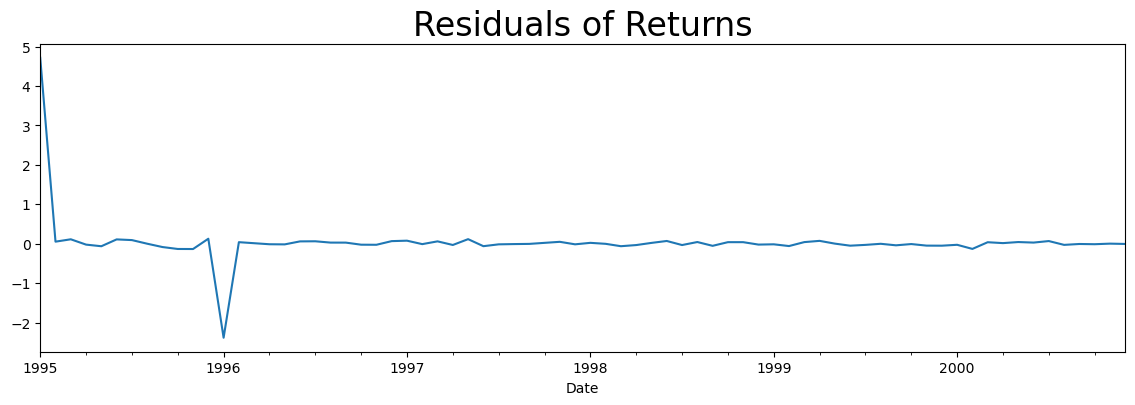

In [127]:
#Residuals must be random
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

# Creating model with differente Transformation Technique

In [128]:
#Comparing the results
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_Additive","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Multiplicative","ARIMA","SARIMA"]),
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_arima,rmse_sarima])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models    MAPE(%)  RMSE_Values
0  Triple_Exp_Multiplicative   6.034484    23.056799
1                     SARIMA   6.500000    24.200000
2         Triple_Exp_Mul_Add   9.368355    34.989365
3         Triple_Exp_Add_Mul  12.932828    46.728647
4        Triple_Exp_Additive  12.084509    47.569283
5         Double_Exponential  17.148982    71.634643
6         Simple_Exponential  23.382283    91.113254
7                      ARIMA  50.300000   152.690000

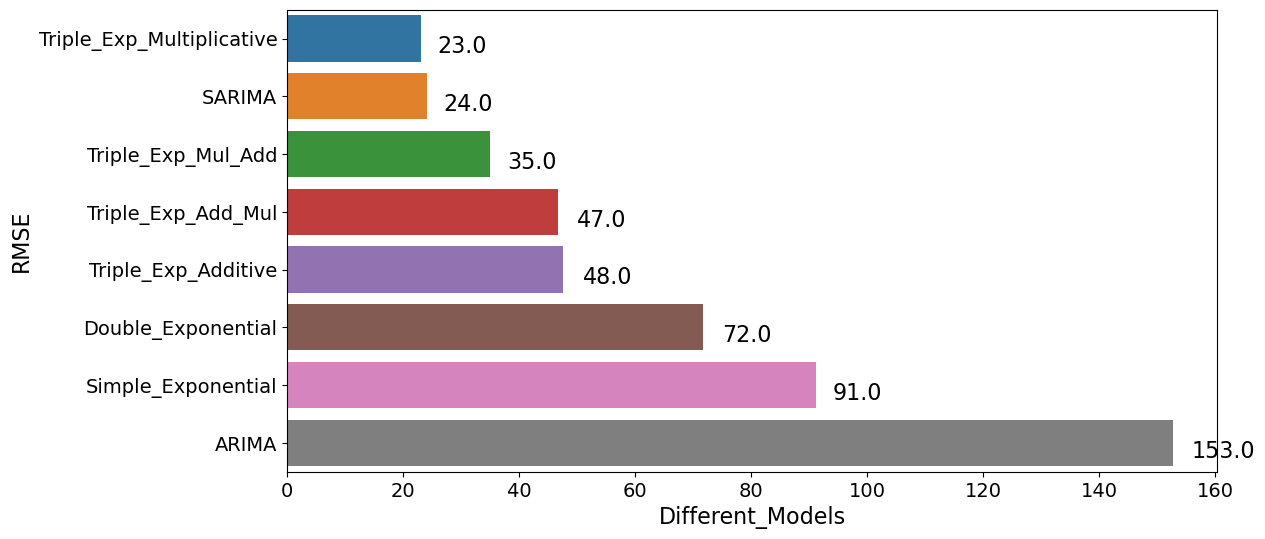

In [129]:
f, axe = plt.subplots(1,1, figsize=(12,6))
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 16)

plt.show()

# Data Pre-processing for Model Driven Techniques

In [130]:
#Creating Dummy Variables of the Categorical Feature Month of Date Time feature
cocacola = airline.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y")  # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
0  1995-01-01         112   1          1   Jan  1995    1    0    0    0    0   
1  1995-02-01         118   2          4   Feb  1995    0    1    0    0    0   
2  1995-03-01         132   3          9   Mar  1995    0    0    1    0    0   
3  1995-04-01         129   4         16   Apr  1995    0    0    0    1    0   
4  1995-05-01         121   5         25   May  1995    0    0    0    0    1   
..        ...         ...  ..        ...   ...   ...  ...  ...  ...  ...  ...   
91 2002-08-01         405  92       8464   Aug  2002    0    0    0    0    0   
92 2002-09-01         355  93       8649   Sep  2002    0    0    0    0    0   
93 2002-10-01         306  94       8836   Oct  2002    0    0    0    0    0   
94 2002-11-01         271  95       9025   Nov  2002    0    0    0    0    0   
95 2002-12-01         306  96       9216   Dec  2002    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
0     0    0    0    0    0    0    0        4.718499  
1     0    0    0    0    0    0    0        4.770685  
2     0    0    0    0    0    0    0        4.882802  
3     0    0    0    0    0    0    0        4.859812  
4     0    0    0    0    0    0    0        4.795791  
..  ...  ...  ...  ...  ...  ...  ...             ...  
91    0    0    1    0    0    0    0        6.003887  
92    0    0    0    1    0    0    0        5.872118  
93    0    0    0    0    1    0    0        5.723585  
94    0    0    0    0    0    1    0        5.602119  
95    0    0    0    0    0    0    1        5.723585  

[96 rows x 19 columns]

In [131]:
#Splitting data into Train and Test
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [132]:
train_data

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
0  1995-01-01         112   1          1   Jan  1995    1    0    0    0    0   
1  1995-02-01         118   2          4   Feb  1995    0    1    0    0    0   
2  1995-03-01         132   3          9   Mar  1995    0    0    1    0    0   
3  1995-04-01         129   4         16   Apr  1995    0    0    0    1    0   
4  1995-05-01         121   5         25   May  1995    0    0    0    0    1   
..        ...         ...  ..        ...   ...   ...  ...  ...  ...  ...  ...   
67 2000-08-01         293  68       4624   Aug  2000    0    0    0    0    0   
68 2000-09-01         259  69       4761   Sep  2000    0    0    0    0    0   
69 2000-10-01         229  70       4900   Oct  2000    0    0    0    0    0   
70 2000-11-01         203  71       5041   Nov  2000    0    0    0    0    0   
71 2000-12-01         229  72       5184   Dec  2000    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
0     0    0    0    0    0    0    0        4.718499  
1     0    0    0    0    0    0    0        4.770685  
2     0    0    0    0    0    0    0        4.882802  
3     0    0    0    0    0    0    0        4.859812  
4     0    0    0    0    0    0    0        4.795791  
..  ...  ...  ...  ...  ...  ...  ...             ...  
67    0    0    1    0    0    0    0        5.680173  
68    0    0    0    1    0    0    0        5.556828  
69    0    0    0    0    1    0    0        5.433722  
70    0    0    0    0    0    1    0        5.313206  
71    0    0    0    0    0    0    1        5.433722  

[72 rows x 19 columns]

In [133]:
test_data

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
72 2001-01-01         242  73       5329   Jan  2001    1    0    0    0    0   
73 2001-02-01         233  74       5476   Feb  2001    0    1    0    0    0   
74 2001-03-01         267  75       5625   Mar  2001    0    0    1    0    0   
75 2001-04-01         269  76       5776   Apr  2001    0    0    0    1    0   
76 2001-05-01         270  77       5929   May  2001    0    0    0    0    1   
77 2001-06-01         315  78       6084   Jun  2001    0    0    0    0    0   
78 2001-07-01         364  79       6241   Jul  2001    0    0    0    0    0   
79 2001-08-01         347  80       6400   Aug  2001    0    0    0    0    0   
80 2001-09-01         312  81       6561   Sep  2001    0    0    0    0    0   
81 2001-10-01         274  82       6724   Oct  2001    0    0    0    0    0   
82 2001-11-01         237  83       6889   Nov  2001    0    0    0    0    0   
83 2001-12-01         278  84       7056   Dec  2001    0    0    0    0    0   
84 2002-01-01         284  85       7225   Jan  2002    1    0    0    0    0   
85 2002-02-01         277  86       7396   Feb  2002    0    1    0    0    0   
86 2002-03-01         317  87       7569   Mar  2002    0    0    1    0    0   
87 2002-04-01         313  88       7744   Apr  2002    0    0    0    1    0   
88 2002-05-01         318  89       7921   May  2002    0    0    0    0    1   
89 2002-06-01         374  90       8100   Jun  2002    0    0    0    0    0   
90 2002-07-01         413  91       8281   Jul  2002    0    0    0    0    0   
91 2002-08-01         405  92       8464   Aug  2002    0    0    0    0    0   
92 2002-09-01         355  93       8649   Sep  2002    0    0    0    0    0   
93 2002-10-01         306  94       8836   Oct  2002    0    0    0    0    0   
94 2002-11-01         271  95       9025   Nov  2002    0    0    0    0    0   
95 2002-12-01         306  96       9216   Dec  2002    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
72    0    0    0    0    0    0    0        5.488938  
73    0    0    0    0    0    0    0        5.451038  
74    0    0    0    0    0    0    0        5.587249  
75    0    0    0    0    0    0    0        5.594711  
76    0    0    0    0    0    0    0        5.598422  
77    1    0    0    0    0    0    0        5.752573  
78    0    1    0    0    0    0    0        5.897154  
79    0    0    1    0    0    0    0        5.849325  
80    0    0    0    1    0    0    0        5.743003  
81    0    0    0    0    1    0    0        5.613128  
82    0    0    0    0    0    1    0        5.468060  
83    0    0    0    0    0    0    1        5.627621  
84    0    0    0    0    0    0    0        5.648974  
85    0    0    0    0    0    0    0        5.624018  
86    0    0    0    0    0    0    0        5.758902  
87    0    0    0    0    0    0    0        5.746203  
88    0    0    0    0    0    0    0        5.762051  
89    1    0    0    0    0    0    0        5.924256  
90    0    1    0    0    0    0    0        6.023448  
91    0    0    1    0    0    0    0        6.003887  
92    0    0    0    1    0    0    0        5.872118  
93    0    0    0    0    1    0    0        5.723585  
94    0    0    0    0    0    1    0        5.602119  
95    0    0    0    0    0    0    1        5.723585

# Building Ordinary Square Model

In [134]:
#1. Linear Model
linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.6677929956463

In [135]:
#2. Exponential Model
exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

42.55232894600458

In [136]:
#3. Quadratic Model
quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_quad))**2))
rmse_quad

51.990736401554834

In [137]:
#4. Additive seasonality
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.26451565320338

In [138]:
#5. Additive seasonality quadratic
add_sea_quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848593321

In [139]:
#6. Multiplicative seasonality
mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

132.18762800263437

In [140]:
#7. Multiplicative Additive seasonality
mul_add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(test_data))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea

11.714670246780539

In [141]:
np.exp(pred_mult_add_sea)

72    245.378110
73    251.466317
74    290.915247
75    278.690401
76    275.377947
77    308.136092
78    340.898573
79    343.777446
80    308.799188
81    271.947832
82    238.912819
83    273.505888
84    280.894281
85    287.863698
86    333.022490
87    319.028212
88    315.236312
89    352.735890
90    390.240432
91    393.535995
92    353.494963
93    311.309720
94    273.493201
95    313.093291
dtype: float64

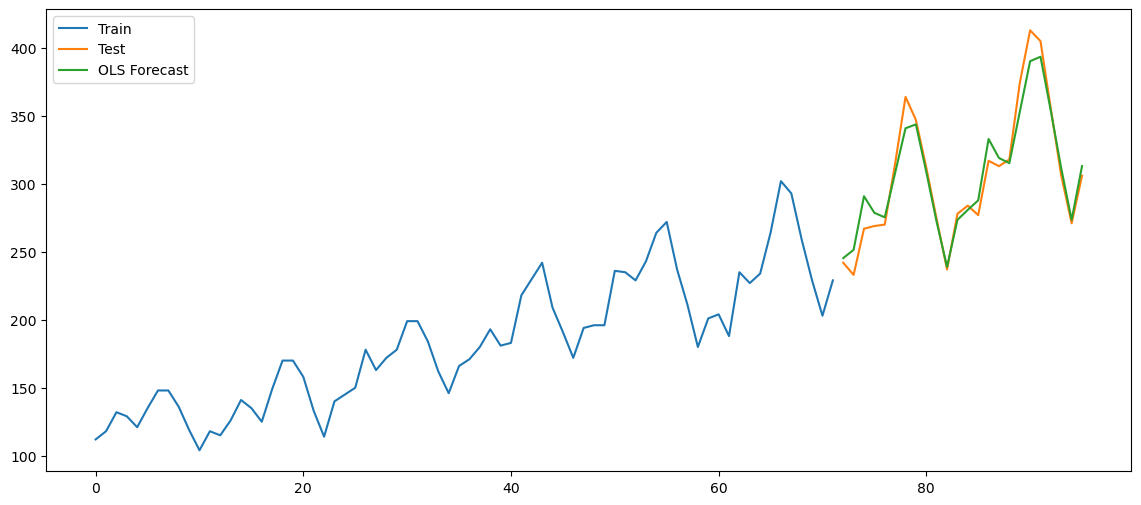

In [142]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data['Passengers'], label='Test')
plt.plot(np.exp(pred_mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

In [143]:
#Compare the Results
data = {"Models":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad","RMSE_Add_Sea","RMSE_Add_Sea_Quad","RMSE_Mult_Sea","RMSE_Mult_Add_Sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [144]:
e = table_rmse.append(table_evaluation)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)


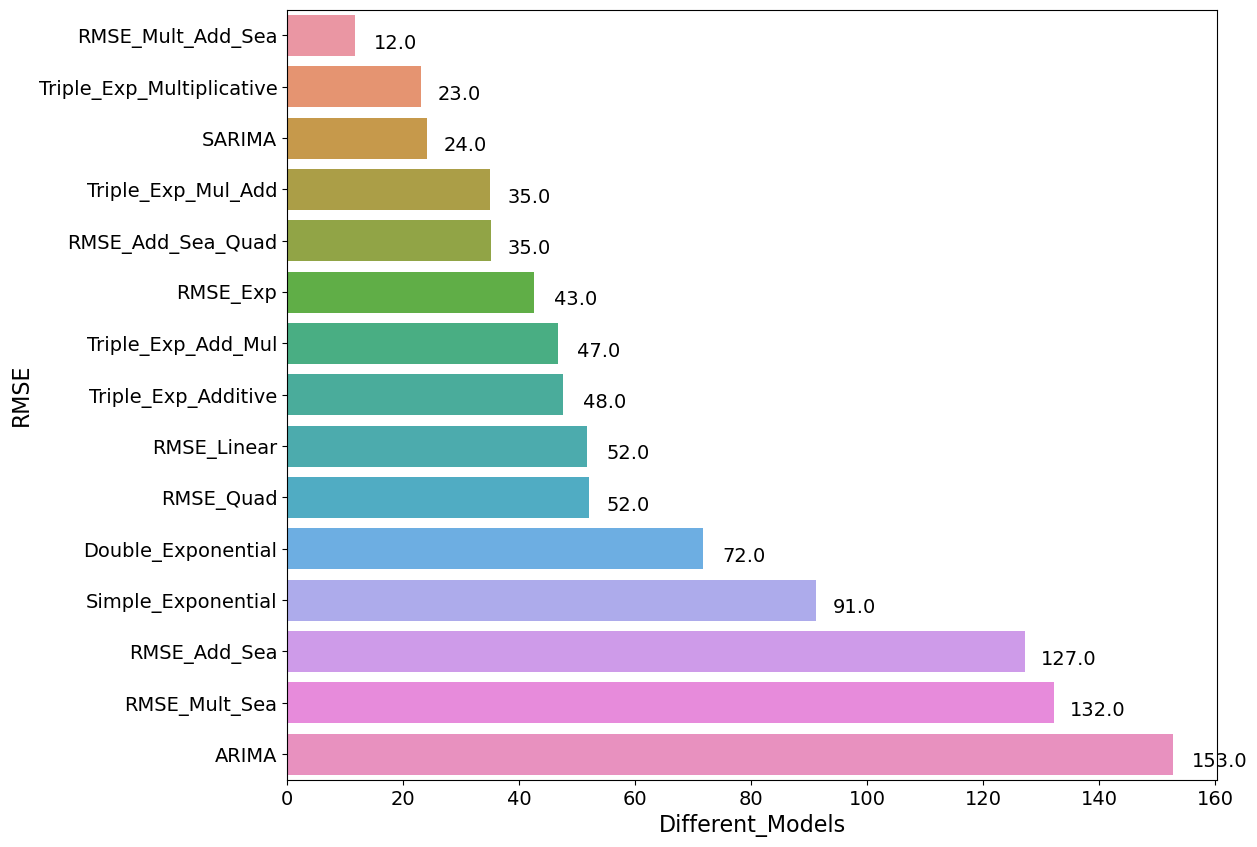

In [145]:
f, axe = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)

plt.show()

In [288]:
#Ordinary Least Squared with Multiplicative Additive Seasonality:
#The best model we have got so far with the lowest RMSE and lowest MAPE.

# Forecast the CocaCola prices

In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import calendar
from math import sqrt
from pandas import datetime
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf 
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [148]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df.head(10)

Quarter        Sales
0   Q1_86  1734.827000
1   Q2_86  2244.960999
2   Q3_86  2533.804993
3   Q4_86  2154.962997
4   Q1_87  1547.818996
5   Q2_87  2104.411995
6   Q3_87  2014.362999
7   Q4_87  1991.746998
8   Q1_88  1869.049999
9   Q2_88  2313.631996

In [149]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [151]:
df.shape

(42, 2)

In [152]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [153]:
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [155]:
df.describe()

Sales
count    42.000000
mean   2994.353308
std     977.930896
min    1547.818996
25%    2159.714247
50%    2782.376999
75%    3609.250000
max    5253.000000

In [156]:
#Converting the Quarters into Years
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

Quarter        Sales Quarter_Year
0   Q1_86  1734.827000      Q1 1986
1   Q2_86  2244.960999      Q2 1986
2   Q3_86  2533.804993      Q3 1986
3   Q4_86  2154.962997      Q4 1986
4   Q1_87  1547.818996      Q1 1987
5   Q2_87  2104.411995      Q2 1987
6   Q3_87  2014.362999      Q3 1987
7   Q4_87  1991.746998      Q4 1987
8   Q1_88  1869.049999      Q1 1988
9   Q2_88  2313.631996      Q2 1988

In [157]:
#Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)
# Converting into datetime formate as the index was not in correct formate.
df['Date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
df.head(10)

Quarter        Sales Quarter_Year       Date
0   Q1_86  1734.827000      Q1 1986 1986-01-01
1   Q2_86  2244.960999      Q2 1986 1986-04-01
2   Q3_86  2533.804993      Q3 1986 1986-07-01
3   Q4_86  2154.962997      Q4 1986 1986-10-01
4   Q1_87  1547.818996      Q1 1987 1987-01-01
5   Q2_87  2104.411995      Q2 1987 1987-04-01
6   Q3_87  2014.362999      Q3 1987 1987-07-01
7   Q4_87  1991.746998      Q4 1987 1987-10-01
8   Q1_88  1869.049999      Q1 1988 1988-01-01
9   Q2_88  2313.631996      Q2 1988 1988-04-01

In [158]:
#Extracting the Quarters and putting in column
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

Quarter        Sales Quarter_Year       Date Quarters
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1
5   Q2_87  2104.411995      Q2 1987 1987-04-01       Q2
6   Q3_87  2014.362999      Q3 1987 1987-07-01       Q3
7   Q4_87  1991.746998      Q4 1987 1987-10-01       Q4
8   Q1_88  1869.049999      Q1 1988 1988-01-01       Q1
9   Q2_88  2313.631996      Q2 1988 1988-04-01       Q2

In [159]:
#Creating Dummy Variables for Quarters Variable
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

Quarter        Sales Quarter_Year       Date Quarters  Q1  Q2  Q3  Q4
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   1   0   0   0
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   0   1   0   0
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   0   0   1   0
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   0   0   0   1
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   1   0   0   0

In [160]:
#Dropping all the unnecessary column
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

Sales       Date Quarters  Q1  Q2  Q3  Q4
0  1734.827000 1986-01-01       Q1   1   0   0   0
1  2244.960999 1986-04-01       Q2   0   1   0   0
2  2533.804993 1986-07-01       Q3   0   0   1   0
3  2154.962997 1986-10-01       Q4   0   0   0   1
4  1547.818996 1987-01-01       Q1   1   0   0   0

In [161]:
#Making the Date as DateTime index for the Dataframe
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [162]:
df1.head()

Sales Quarters  Q1  Q2  Q3  Q4
Date                                            
1986-01-01  1734.827000       Q1   1   0   0   0
1986-04-01  2244.960999       Q2   0   1   0   0
1986-07-01  2533.804993       Q3   0   0   1   0
1986-10-01  2154.962997       Q4   0   0   0   1
1987-01-01  1547.818996       Q1   1   0   0   0

In [163]:
#Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

Quarter        Sales Quarter_Year       Date Quarters month  year
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   Jan  1986
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   Apr  1986
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   Jul  1986
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   Oct  1986
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   Jan  1987
5   Q2_87  2104.411995      Q2 1987 1987-04-01       Q2   Apr  1987
6   Q3_87  2014.362999      Q3 1987 1987-07-01       Q3   Jul  1987
7   Q4_87  1991.746998      Q4 1987 1987-10-01       Q4   Oct  1987
8   Q1_88  1869.049999      Q1 1988 1988-01-01       Q1   Jan  1988
9   Q2_88  2313.631996      Q2 1988 1988-04-01       Q2   Apr  1988

# Data Visualization

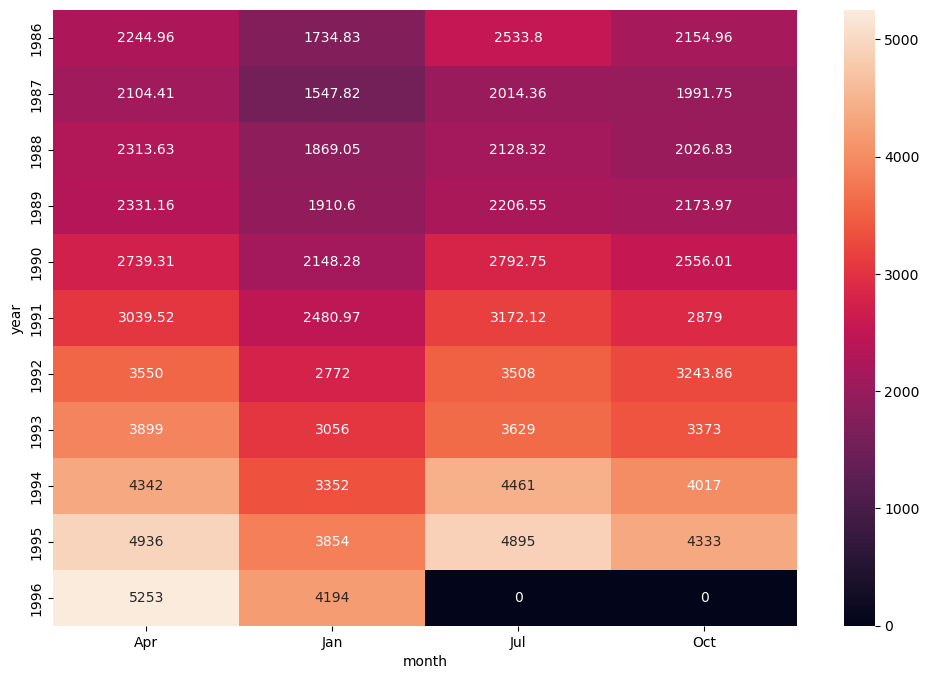

In [164]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df, values="Sales", index="year", columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt="g")
plt.show()

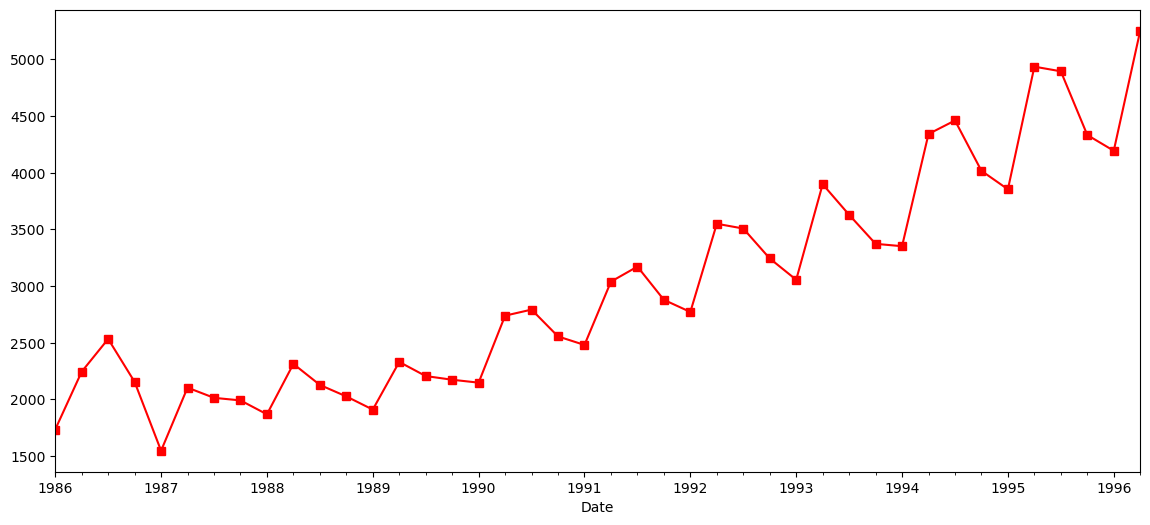

In [165]:
df1['Sales'].plot(figsize=(14,6), color='red', marker='s')
plt.show()

In [166]:
#We can see that there is an increasing Trend. So, Trend is not constant.
#Variance is also not constant.

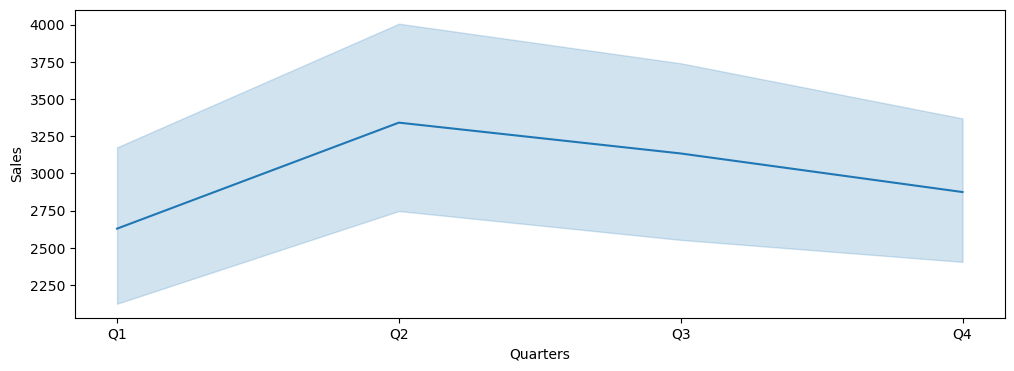

In [167]:
#Line Plot Using Quarters as Y axis and Sales as X axis
plt.figure(figsize=(12,4))
sns.lineplot(x="Quarters", y="Sales", data=df)
plt.show()

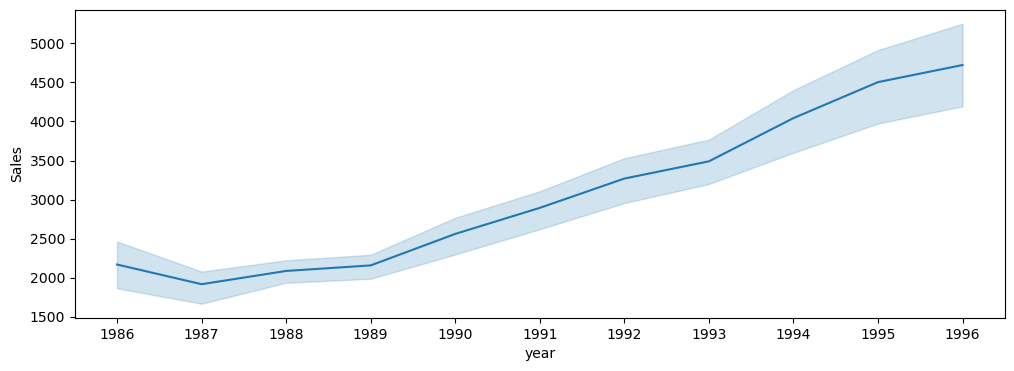

In [168]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

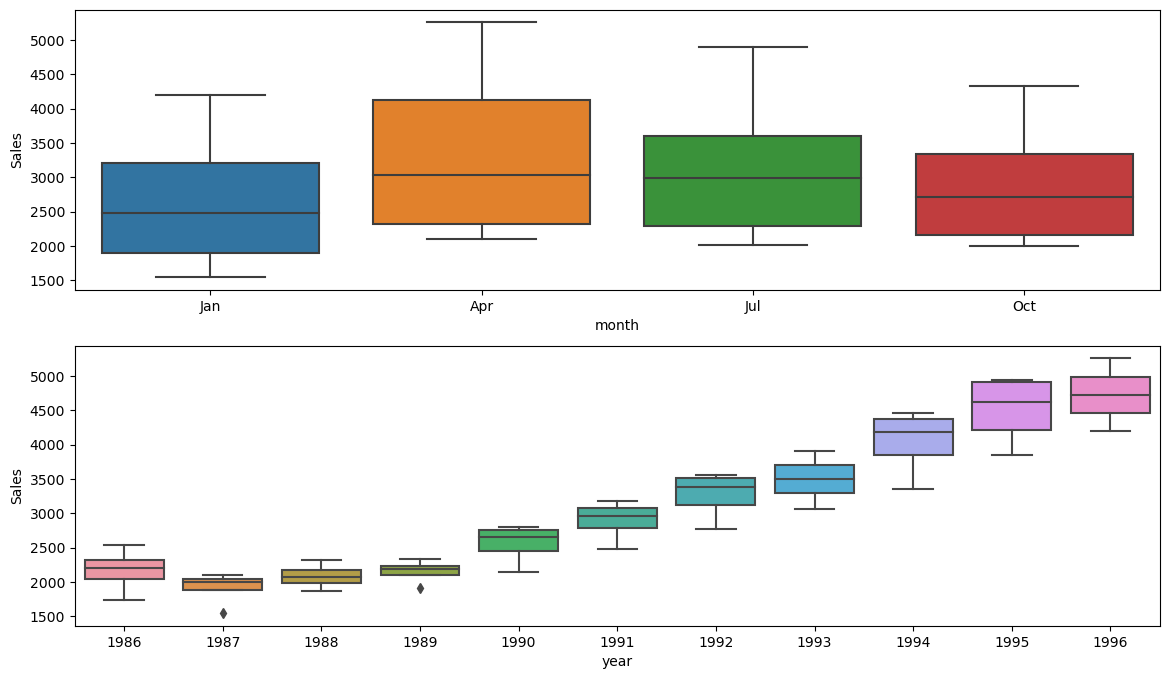

In [169]:
#Box Plot of Each Year by Quaterly Intervals
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)
plt.show()

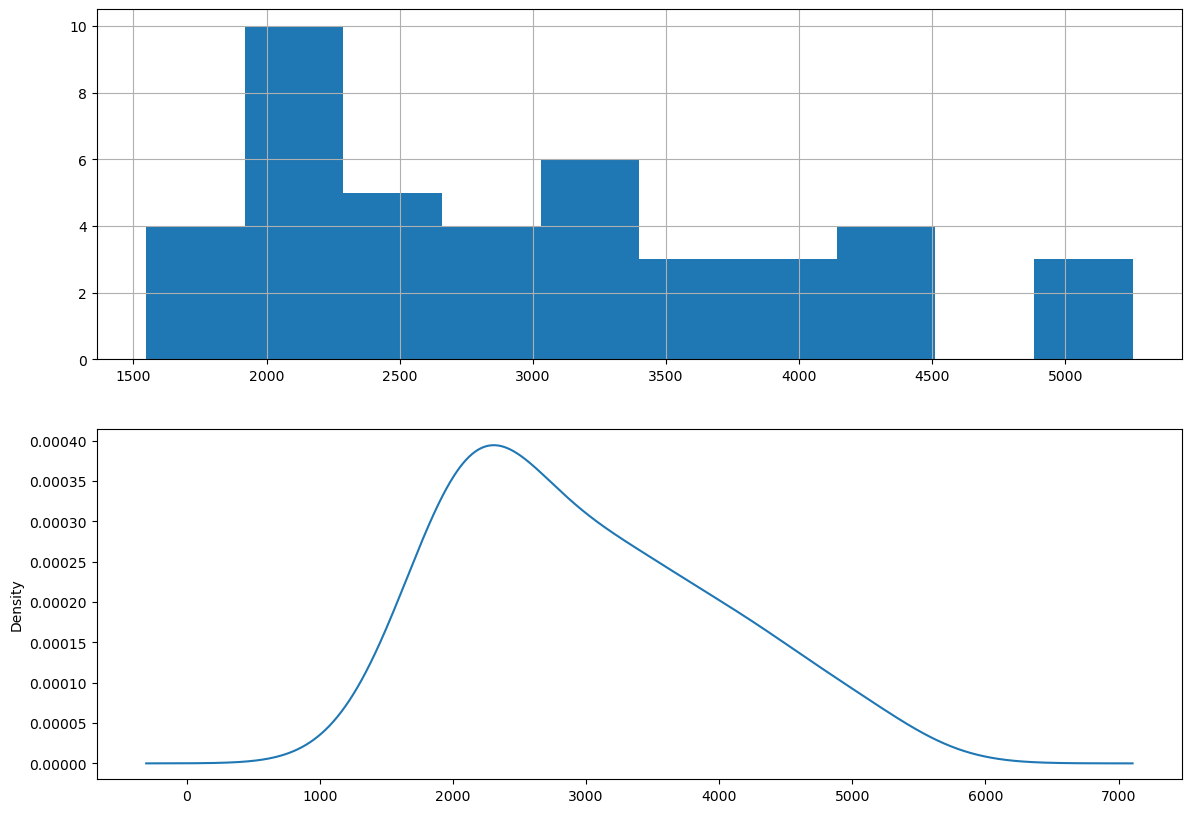

In [170]:
#Histogram and Density Plots
plt.figure(figsize=(14,10))
plt.subplot(211)
df.Sales.hist()
plt.subplot(212)
df.Sales.plot(kind='kde')
plt.show()

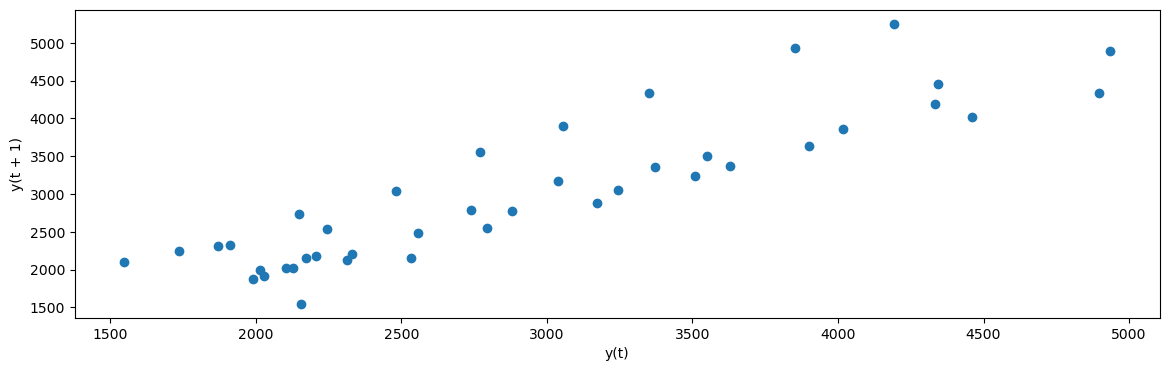

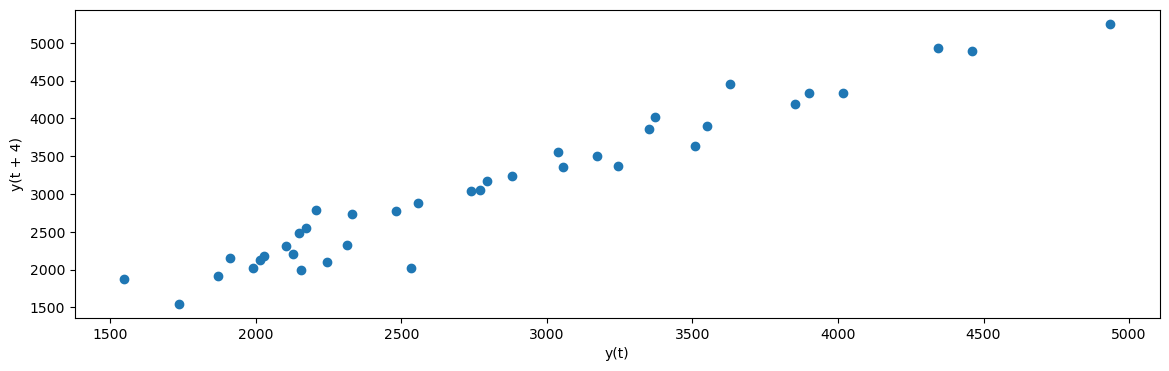

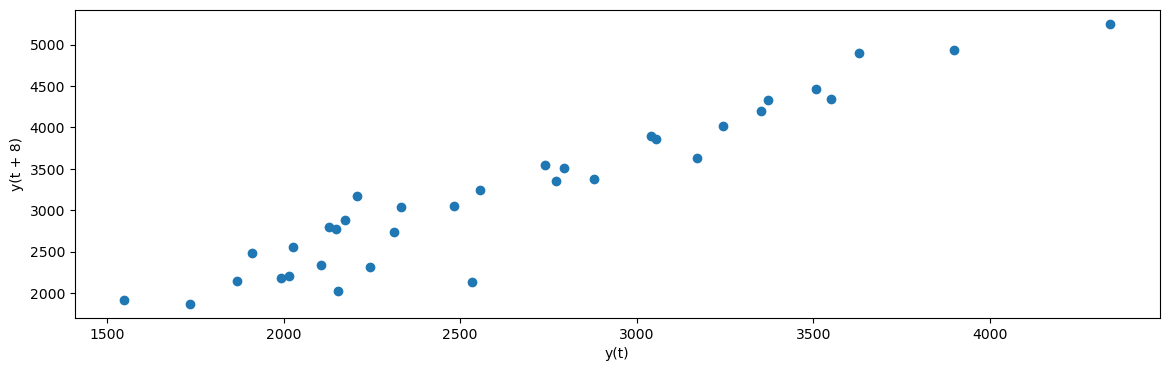

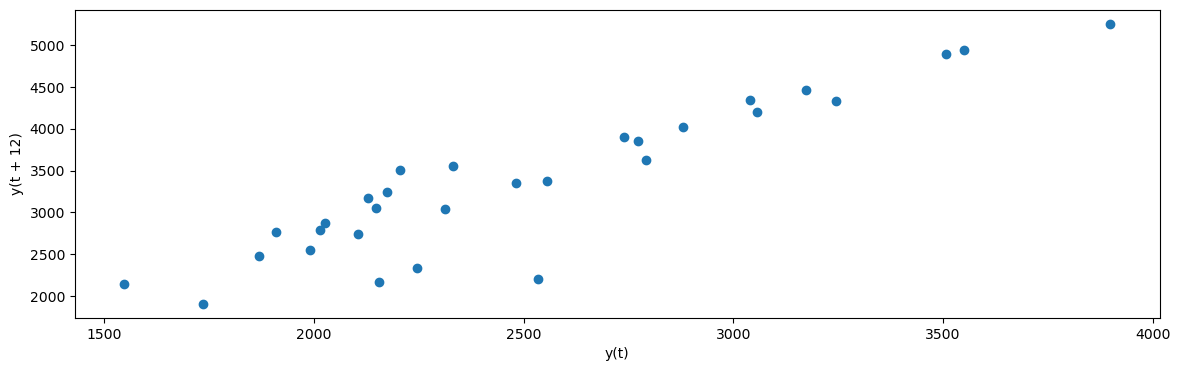

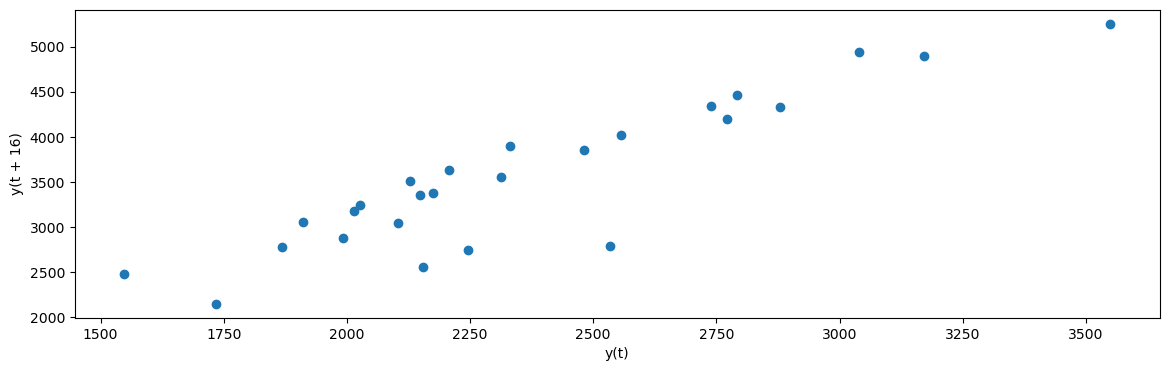

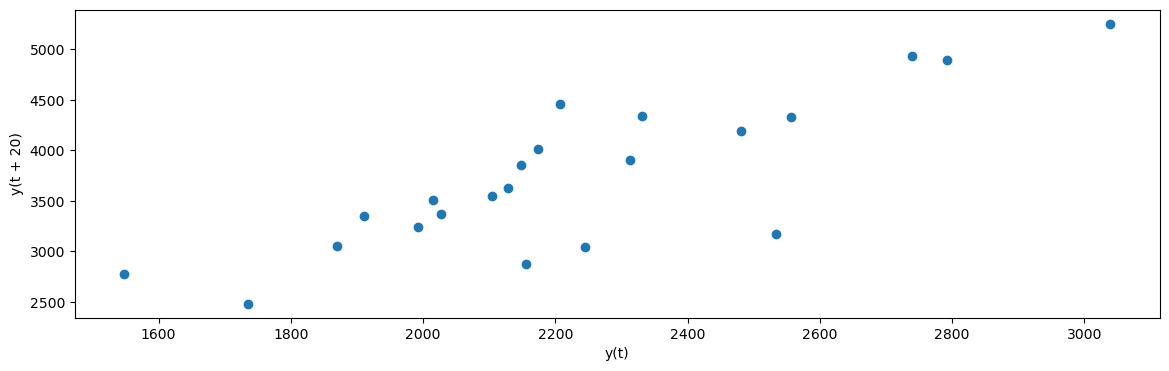

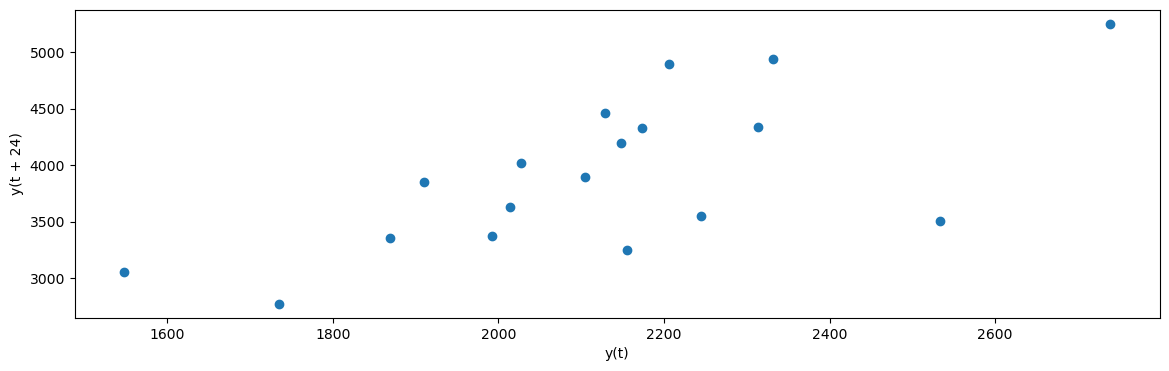

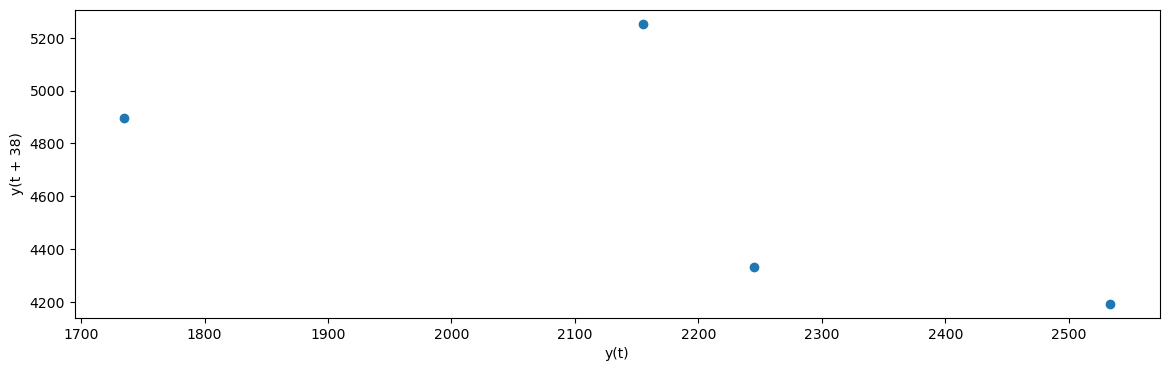

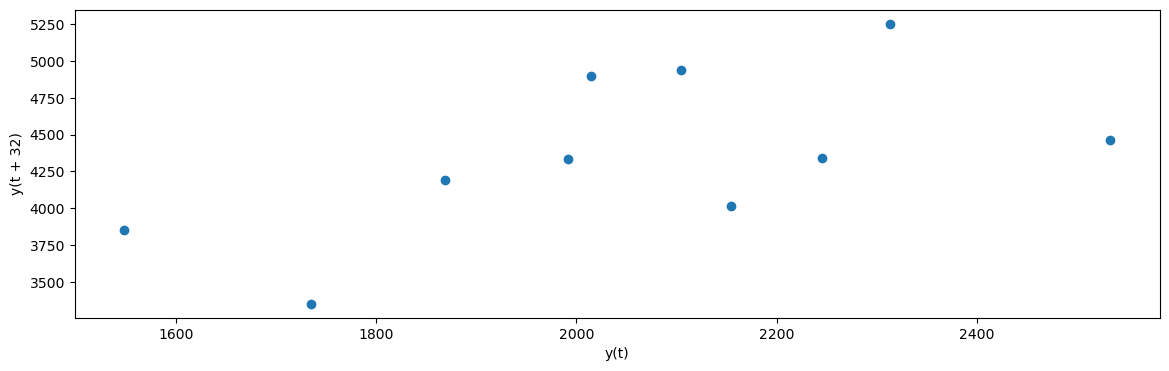

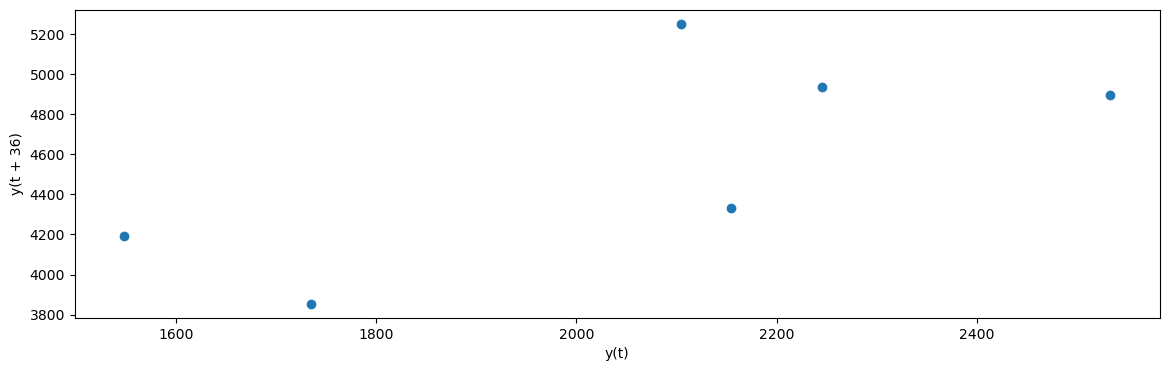

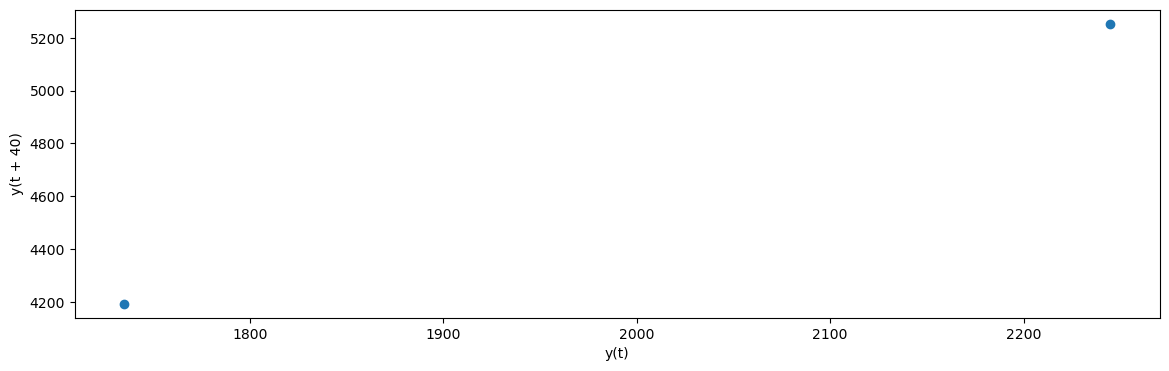

In [171]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    lag_plot(df.Sales, lag=i)
    plt.show()

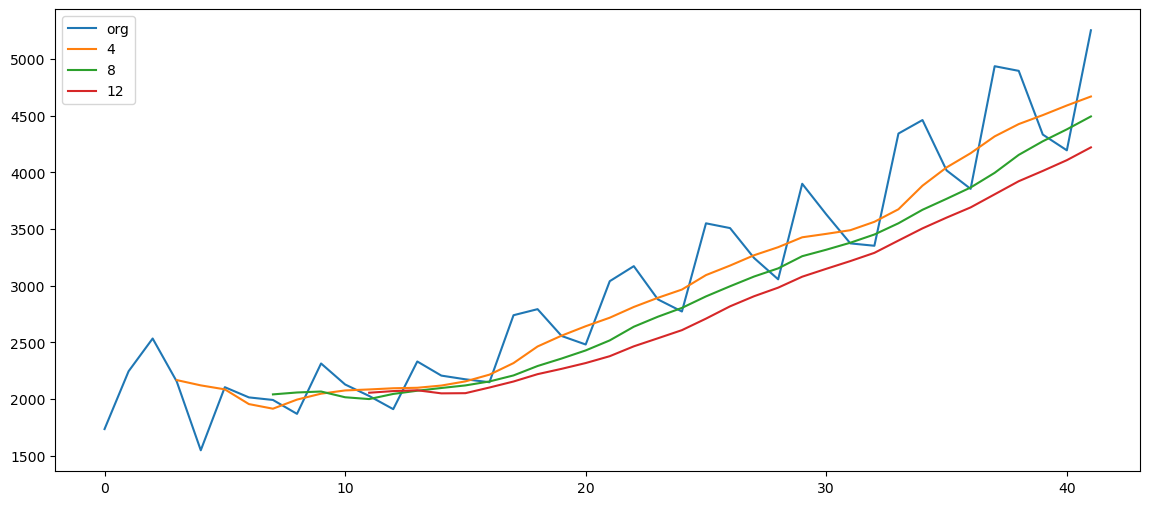

In [172]:
#Moving Average
plt.figure(figsize=(14,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

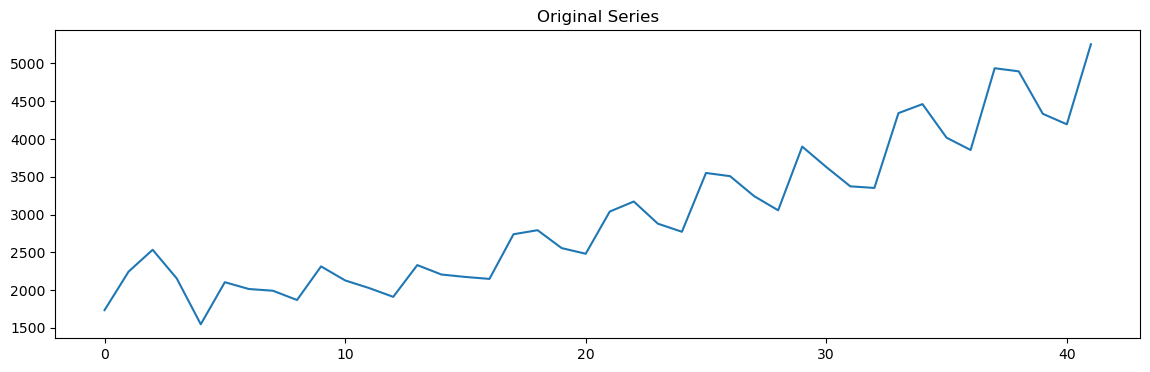

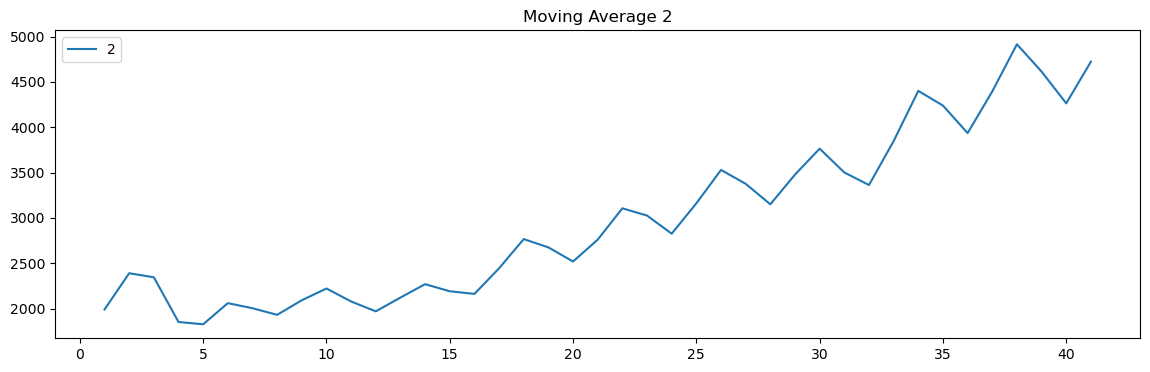

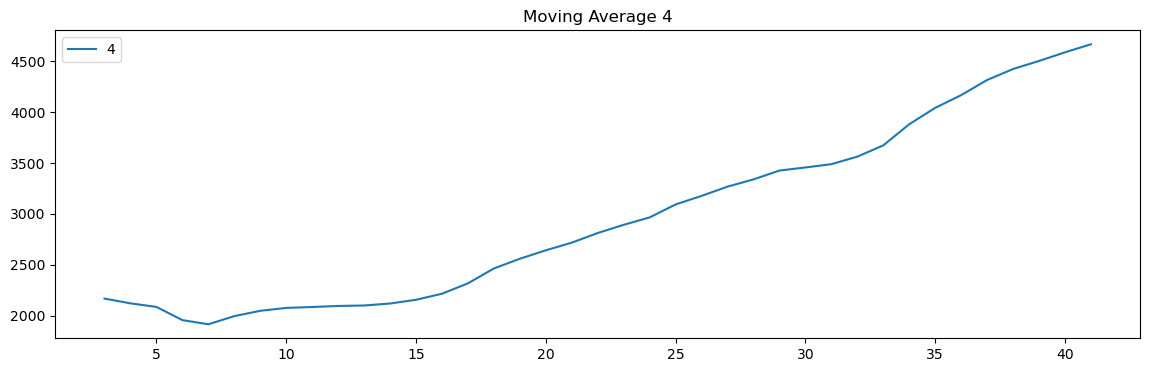

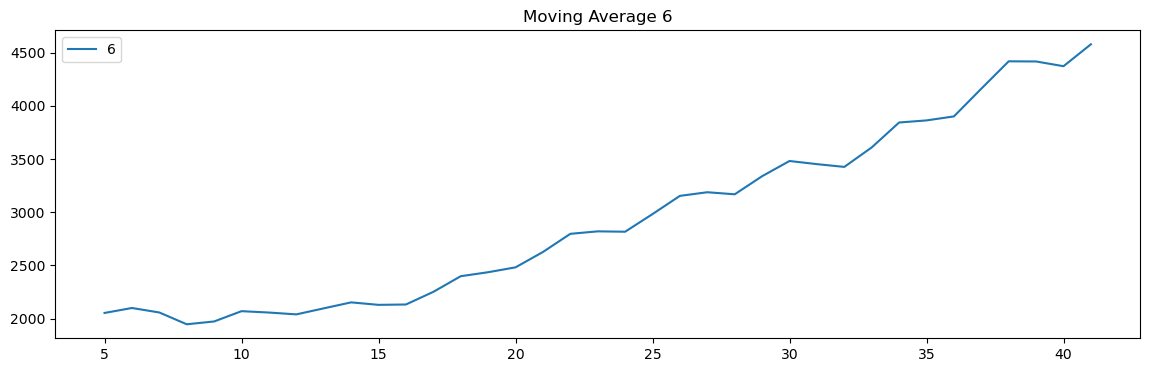

In [173]:
plt.figure(figsize=(14,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,7,2):
    plt.figure(figsize=(14,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

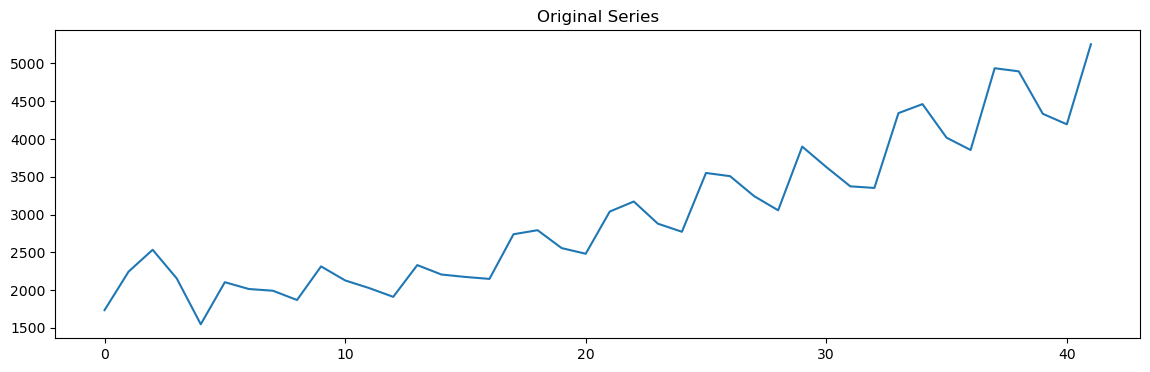

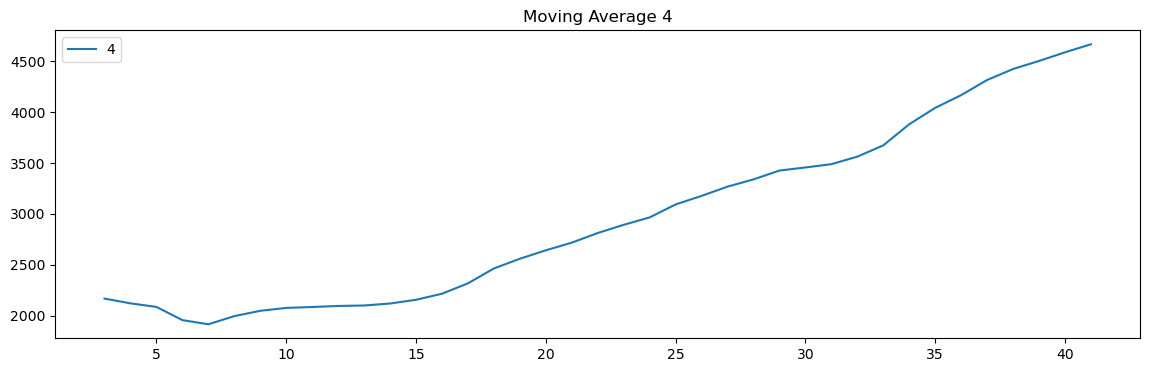

In [174]:
plt.figure(figsize=(14,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(14,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

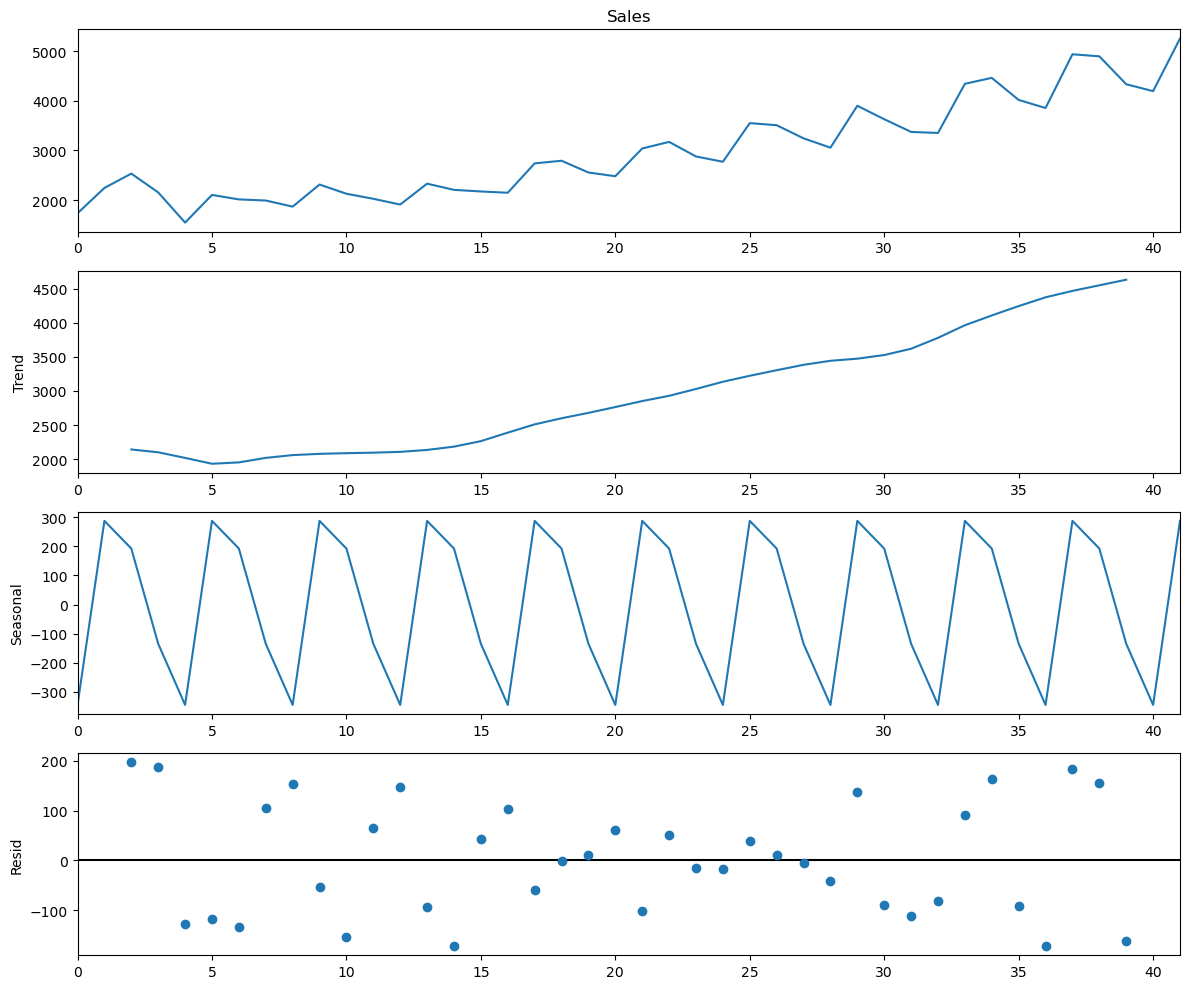

In [175]:
#Time series decomposition plot
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

In [176]:
#ACF plots and PACF plots

In [177]:
#ACF

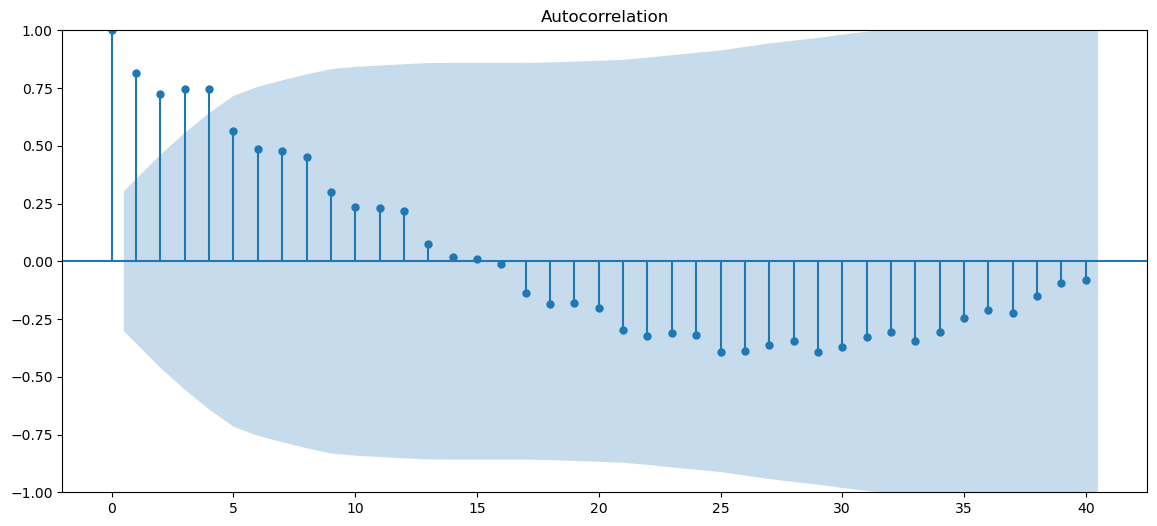

In [178]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(df.Sales,lags=40)
    plt.show()

In [179]:
#Autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation

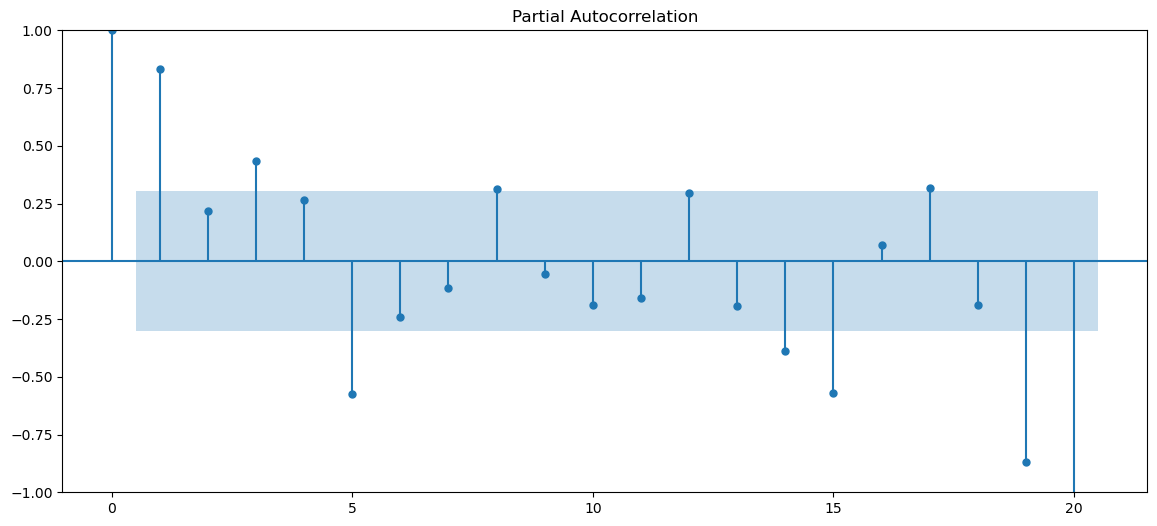

In [180]:
#PCF
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

In [181]:
#A partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

# Sampling

In [182]:
#Linear interpolation
   #UpSampling with respect to month

In [183]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996


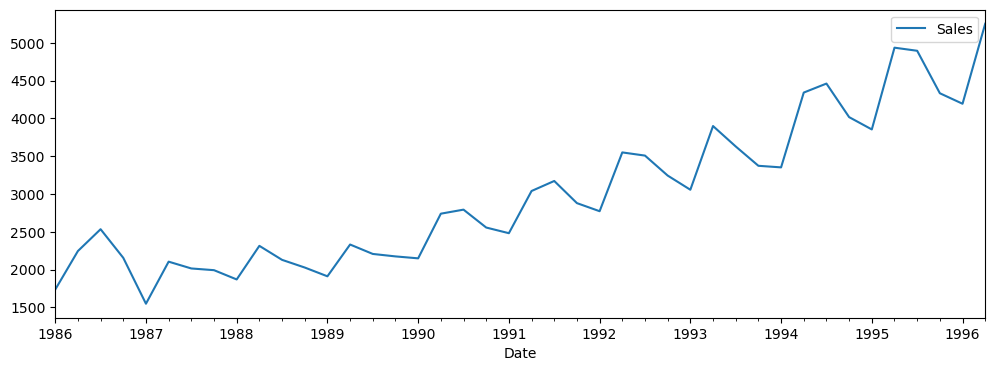

In [184]:
interpolated_month = upsampled_month.interpolate(method='linear')
print(interpolated_month.head(13))
interpolated_month.plot(figsize=(12,4))
plt.show()

In [185]:
interpolated_month

Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
...                 ...
1995-12-31  4240.333333
1996-01-31  4194.000000
1996-02-29  4547.000000
1996-03-31  4900.000000
1996-04-30  5253.000000

[124 rows x 1 columns]

In [186]:
visual = interpolated_month.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual[:2]

Sales       date  year  month  week  quarter day_of_week
0  1734.827000 1986-01-31  1986      1     5        1      Friday
1  1904.871666 1986-02-28  1986      2     9        1      Friday

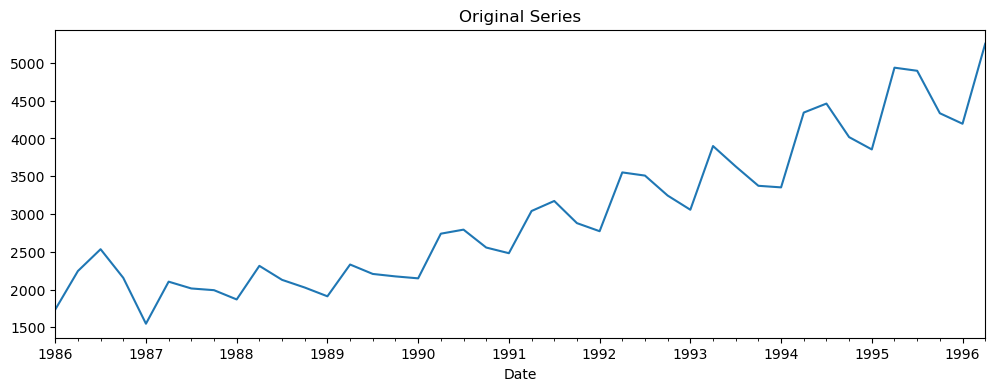

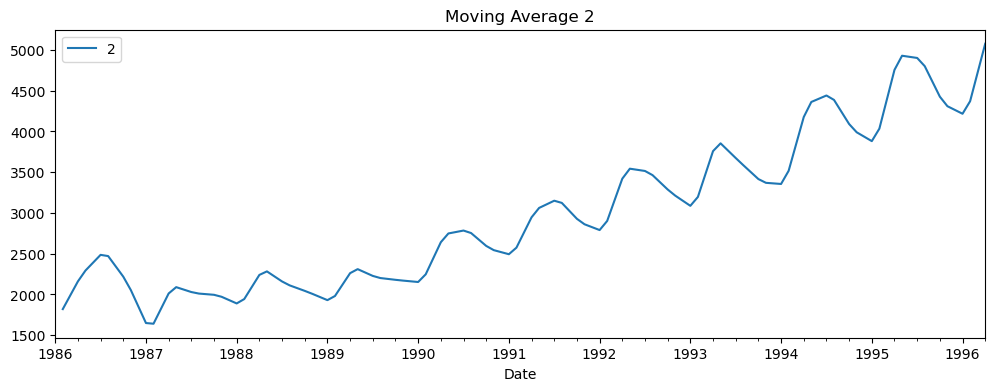

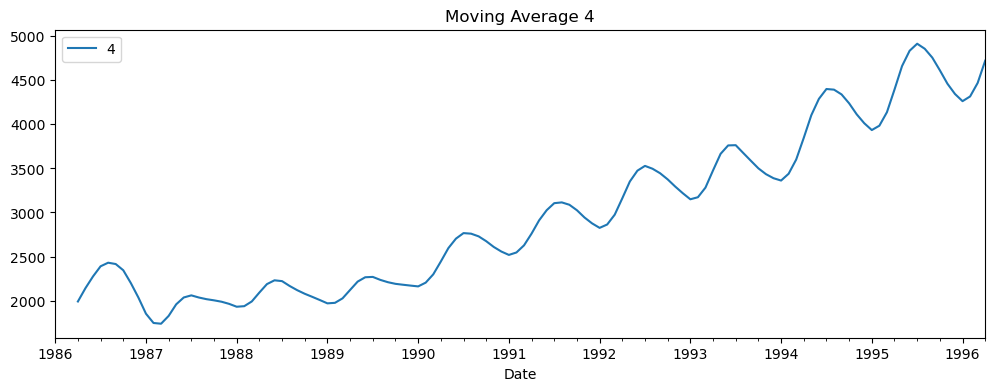

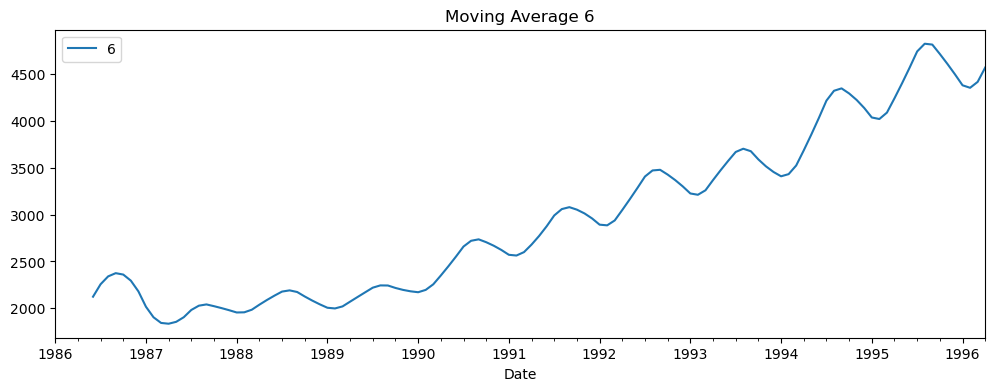

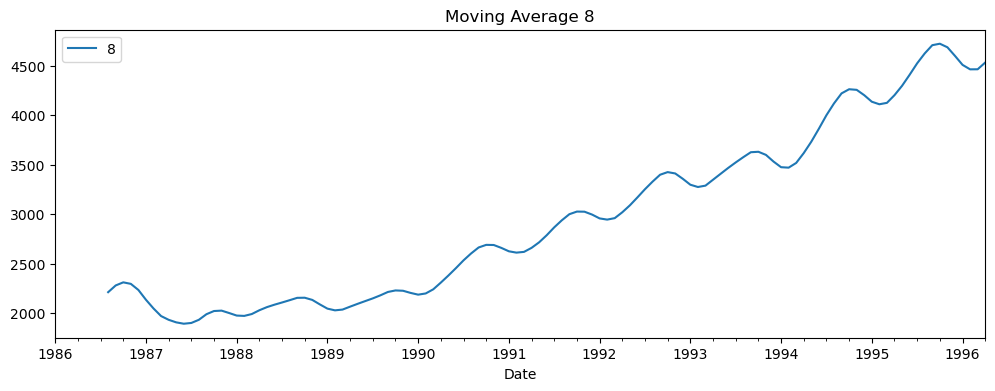

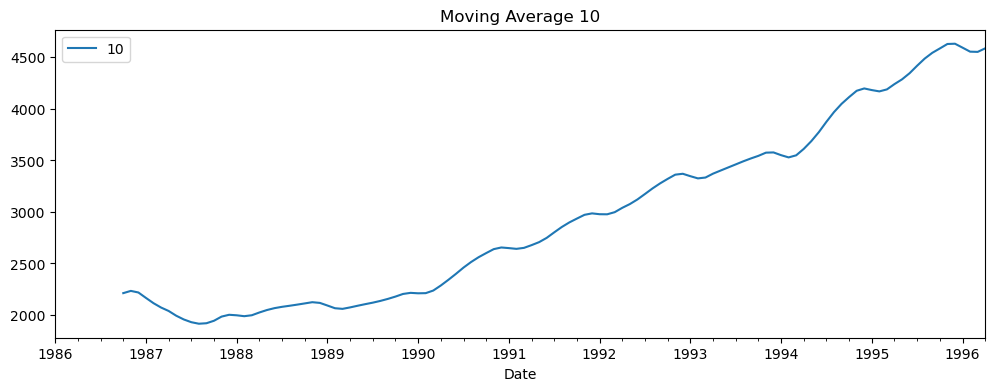

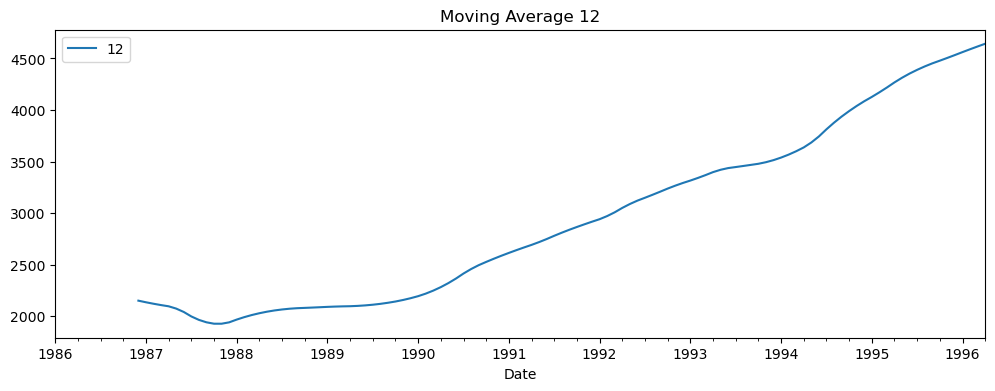

In [187]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13,2):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

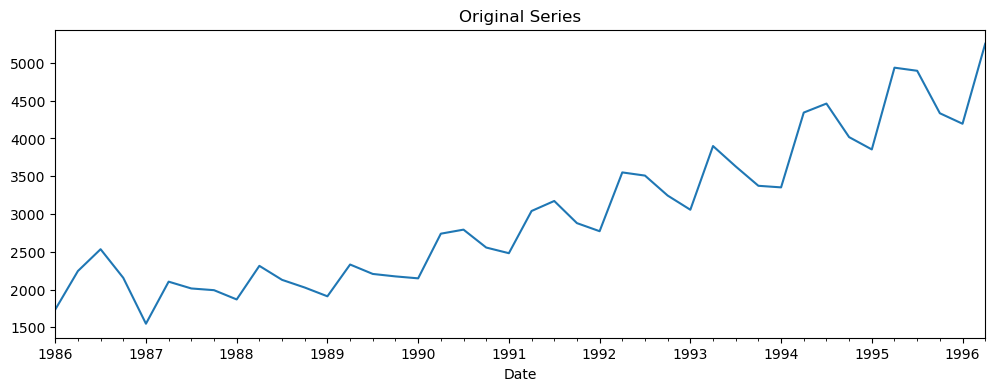

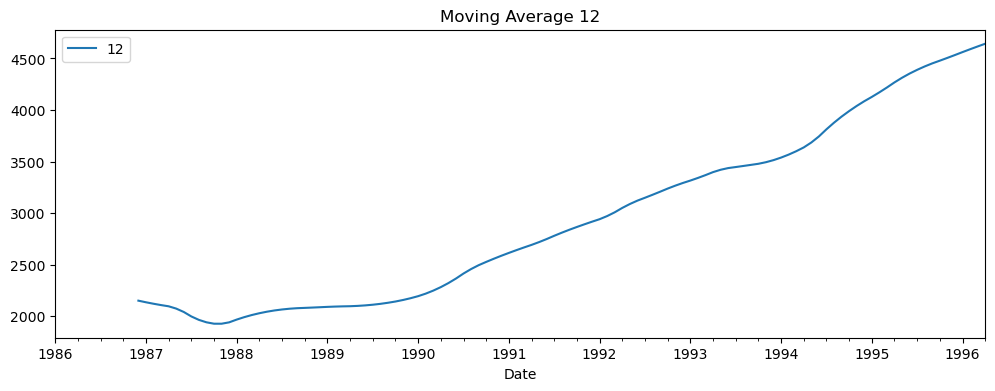

In [188]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

# Time Series Decomposition
1. Seasonality
2. Trend

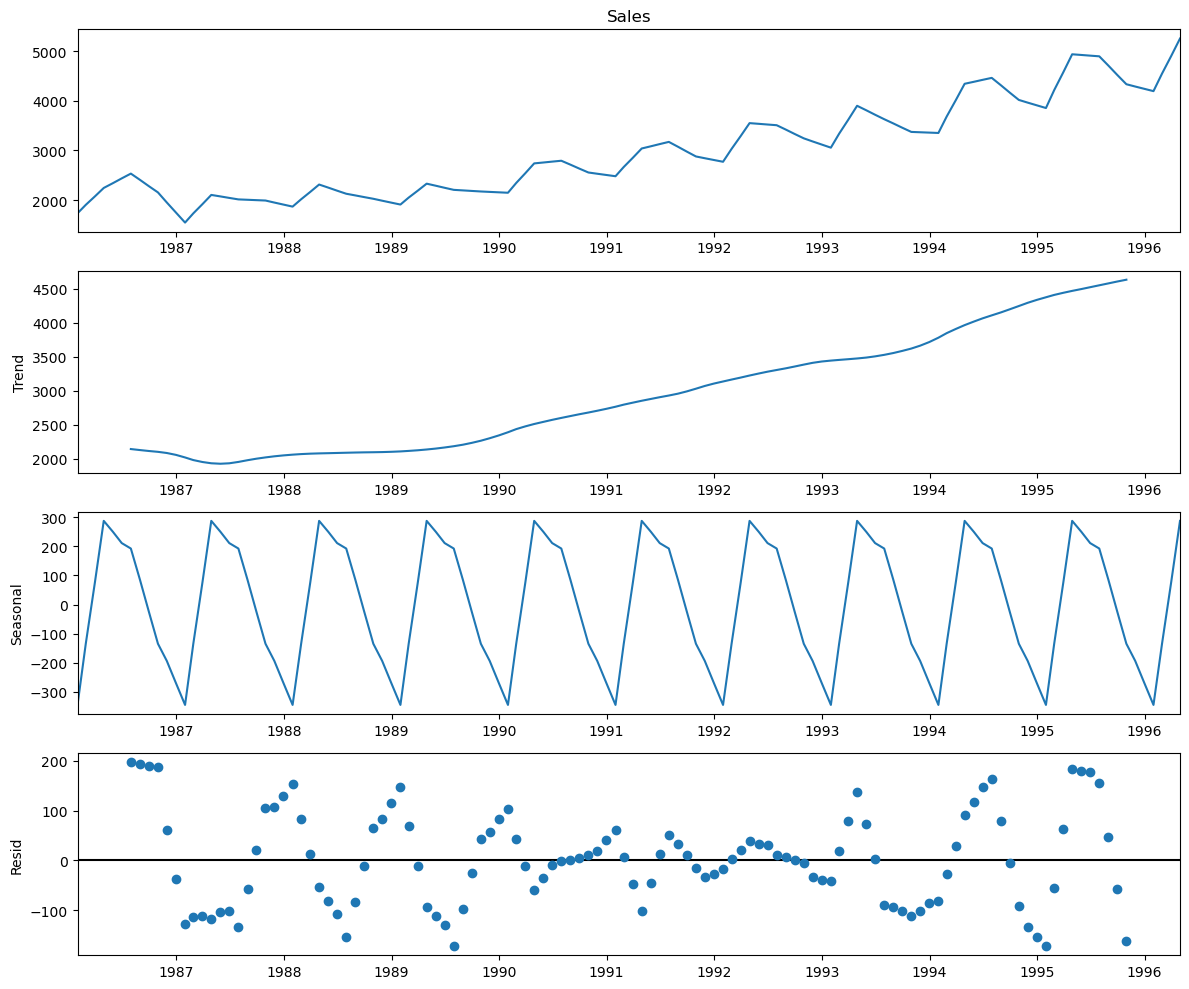

In [189]:
#Additive Seasonal Decomposition
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

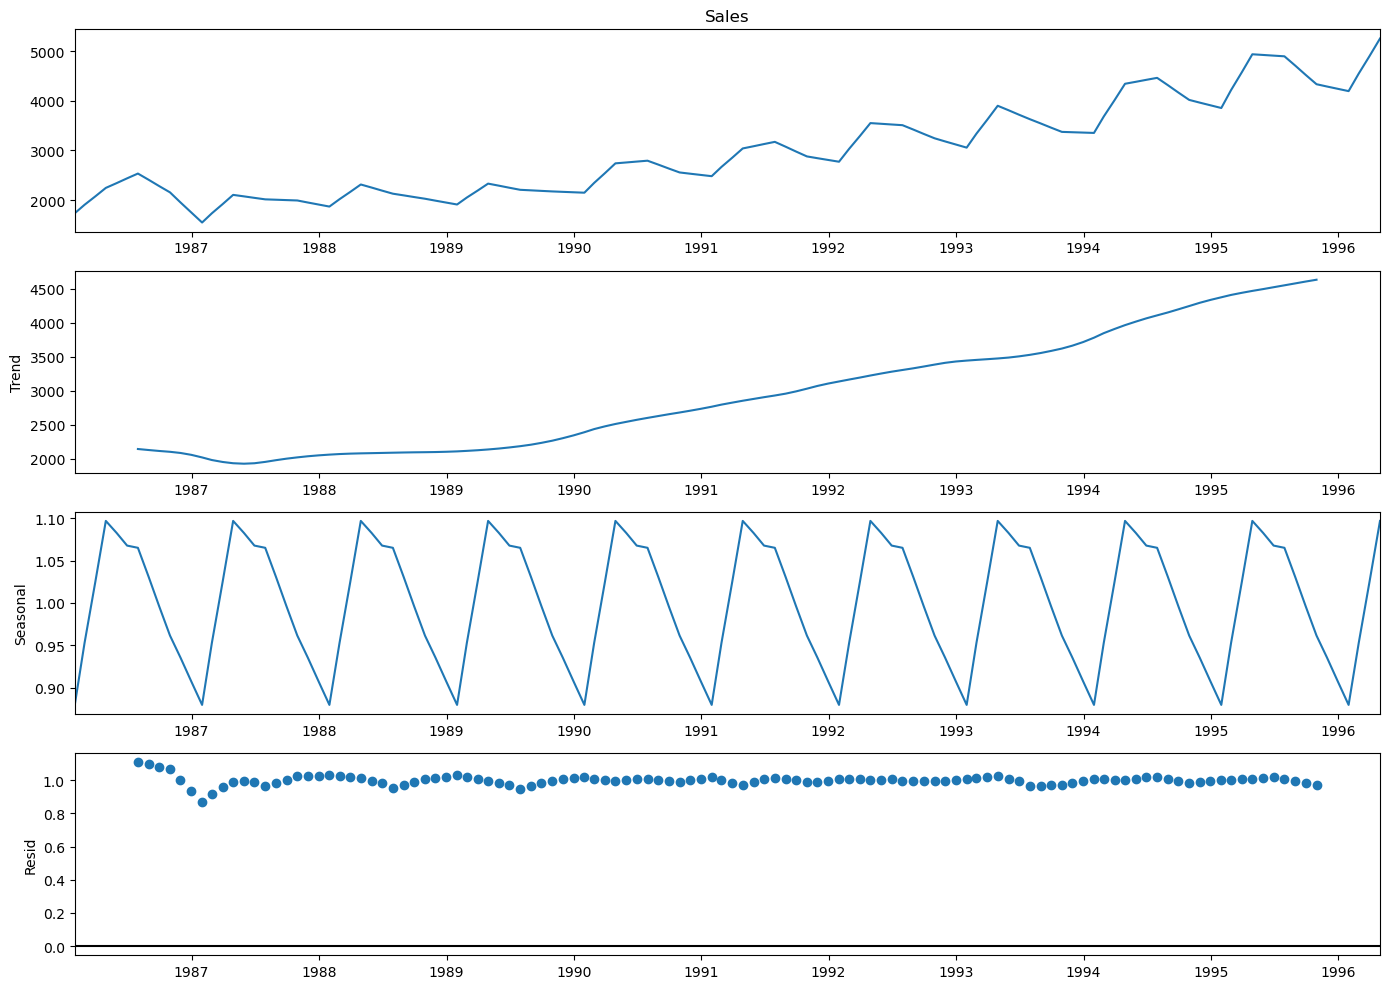

In [190]:
#Multiplicative Seasonal Decomposition
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [191]:
#Seasonal -

#Varies from 0.8 to 1.2
#The value in the Y-axis has to be multiplied to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is 1.2 and the trend value is 100. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.

# Splitting Train and Test Data

In [192]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

In [193]:
print('Train :',train_data.index.min(),train_data.index.max(),'\n',
'Test :',test_data.index.min(),test_data.index.max())

Train : 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test : 1994-05-31 00:00:00 1996-04-30 00:00:00


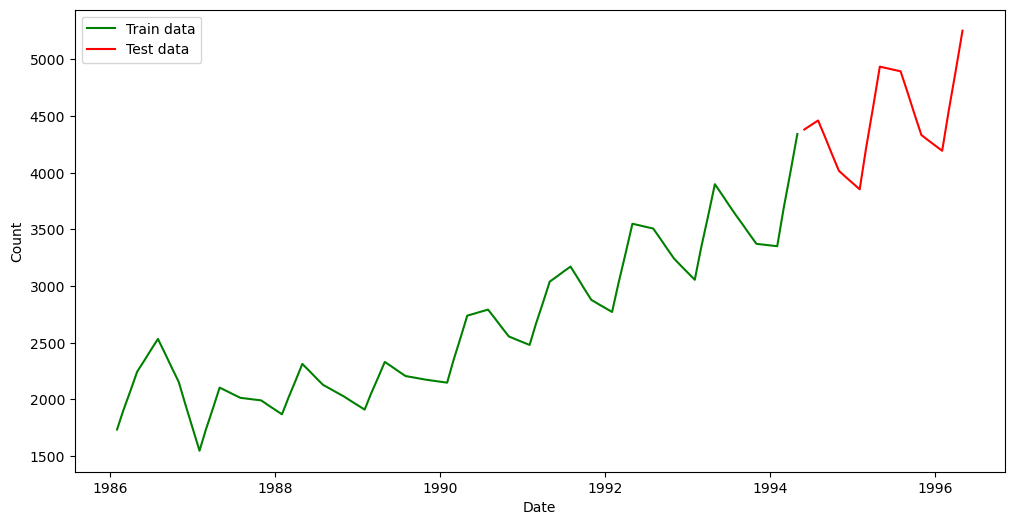

In [194]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.show()

In [195]:
#Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Exponential Method

In [196]:
#Simple Exponential Method
 #Using Forecast Attribute

In [197]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 6.620373886579517 
 Train Root Mean Squared Error = 129.78414718502933 
 Test Root Mean Squared Error  = 382.4477417207024


In [198]:
#Using Predict Attribute
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 6.620373886579517 
 Train Root Mean Squared Error = 129.78414718502933 
 Test Root Mean Squared Error  = 382.4477417207024


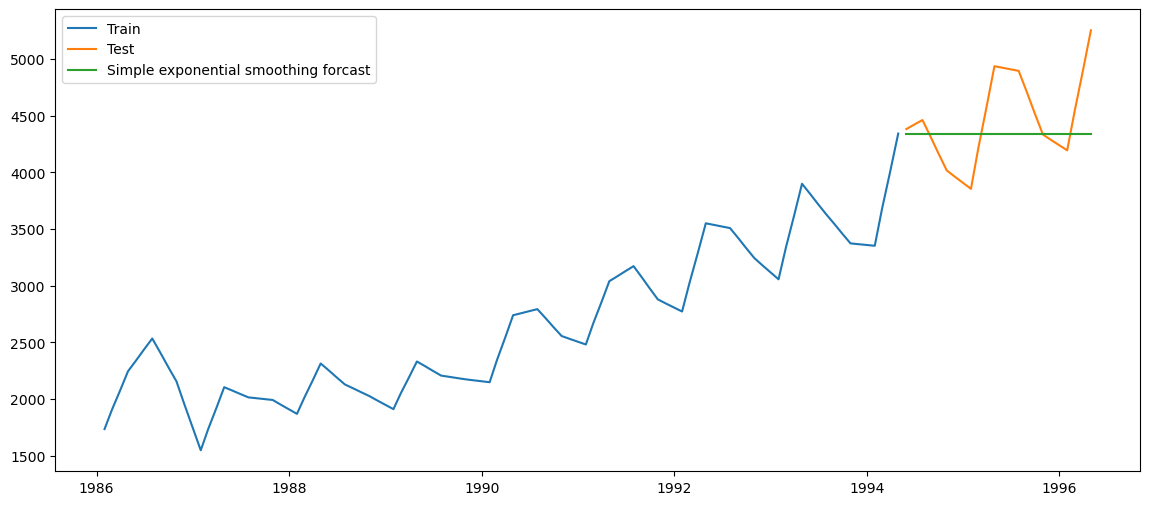

In [199]:
#Difference between predict and forecast attribute
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [200]:
#No seasonality captures.
#Most recent observation gets higher weightages than the older ones for forecasting.

In [201]:
#Holt method (Double Exponential)
  #Captures both Level and Trend .

In [202]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 89.49462512277046 
 Train Root Mean Squared Error = 106.04918278537214 
 Test Root Mean Squared Error  = 4549.90795083935


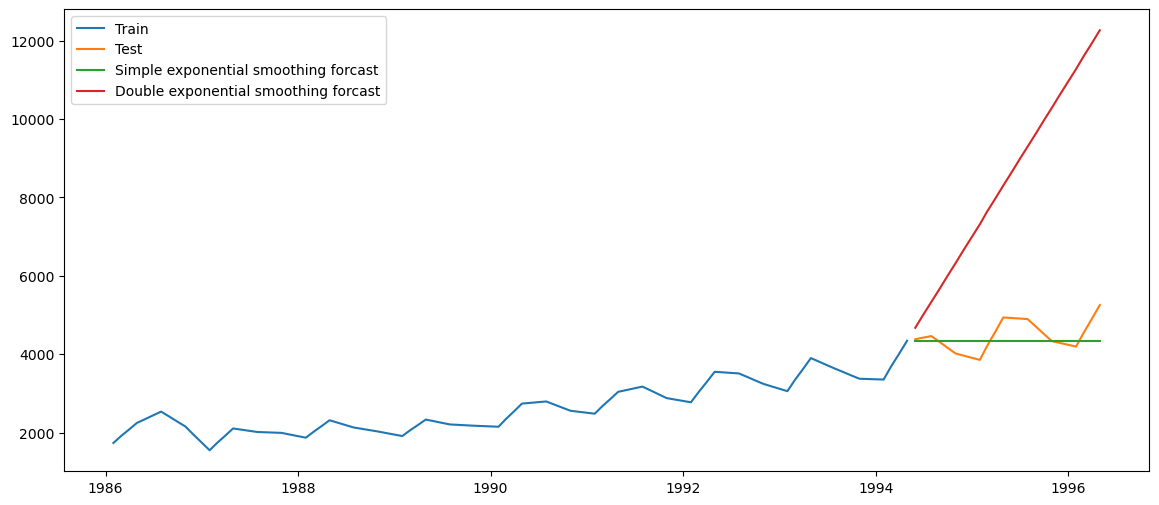

In [203]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [204]:
#We can see that we are able to capture the trend of the data but the level is on another level.
#We were not able to capture the seasonality.

In [205]:
#Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
#Captures Level, Trend and Seasonality.

In [207]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 37.82406870055411 
 Train Root Mean Squared Error = 45.97599540803602 
 Test Root Mean Squared Error  = 1938.6377946243854


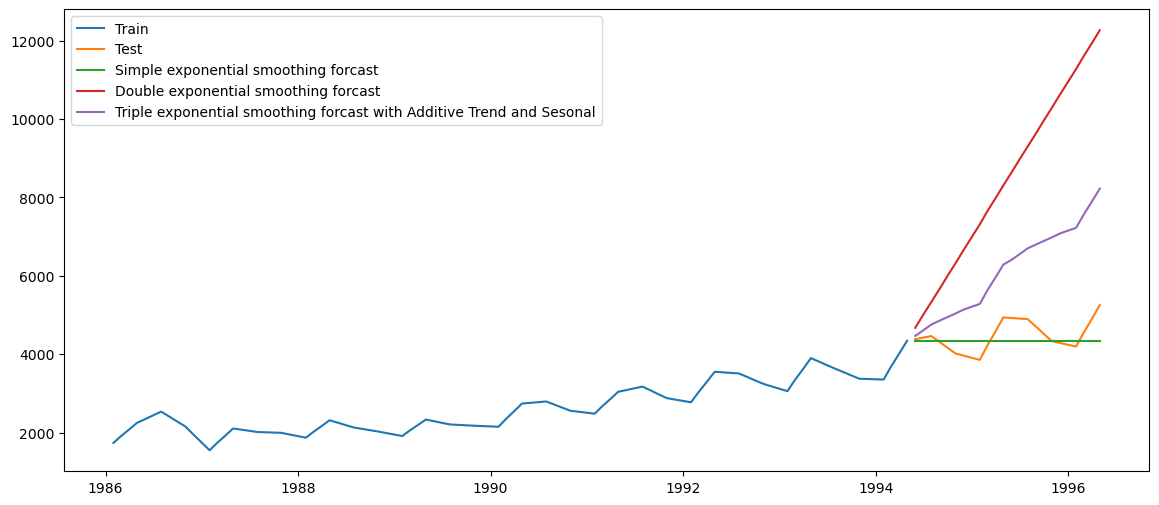

In [208]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

In [209]:
#It captures the trend, which we can see that the forecasted values are higher level than the test level.
#It also captures the seasonality.
#The peak of the forecasted value is higher than the actual.

In [210]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error   = 3.636542243525484 
 Train Root Mean Squared Error = 40.85891607687442 
 Test Root Mean Squared Error  = 210.00140597756265


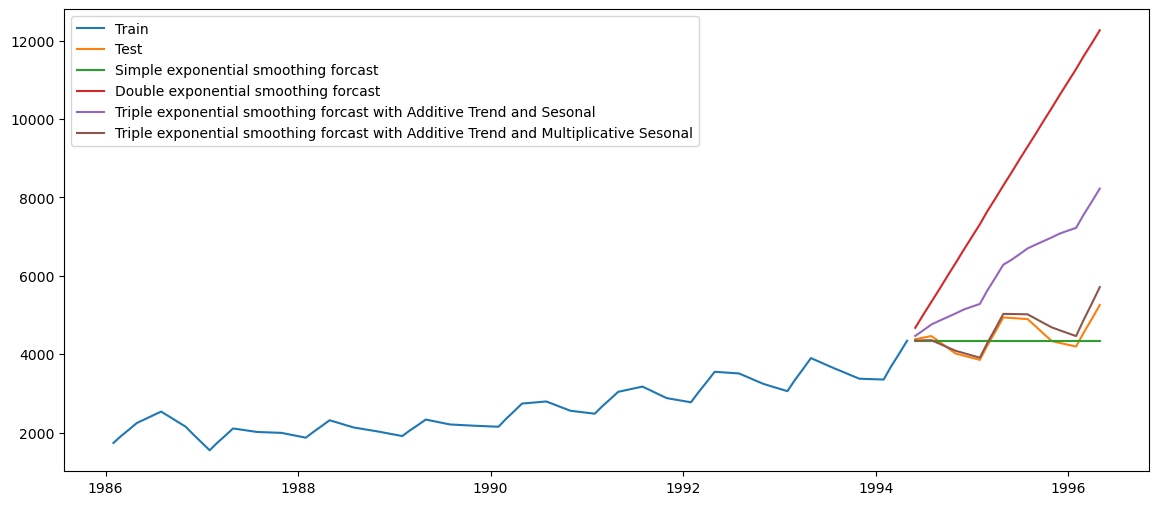

In [211]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

In [212]:
#We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

In [213]:
#Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error   = 5.227066115525063 
 Train Root Mean Squared Error = 169.71546347942615 
 Test Root Mean Squared Error  = 270.84004809136763


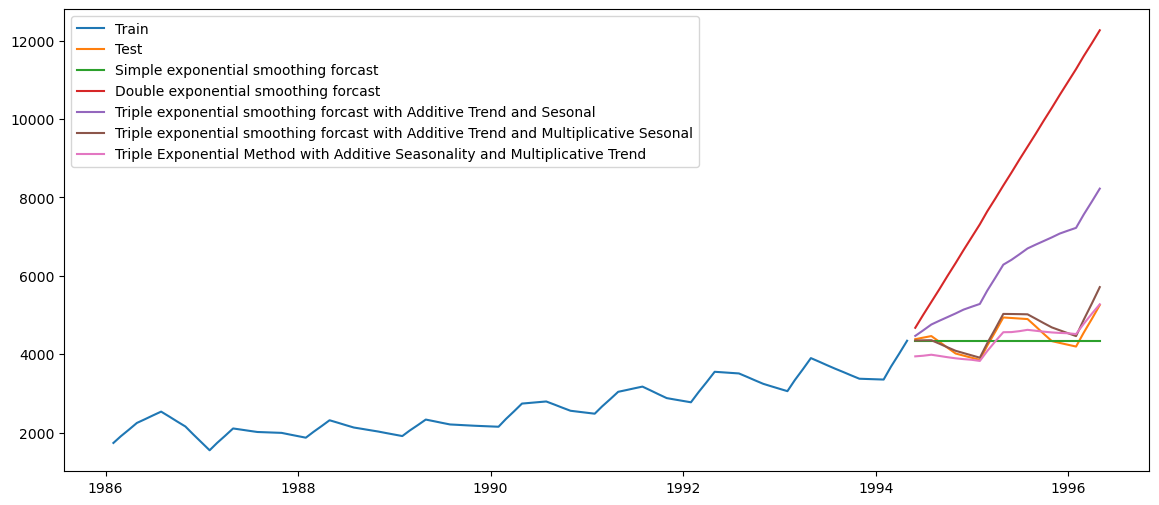

In [214]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

In [215]:
#Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error   = 6.308444220296387 
 Train Root Mean Squared Error = 40.06681930340377 
 Test Root Mean Squared Error  = 366.46433545020244


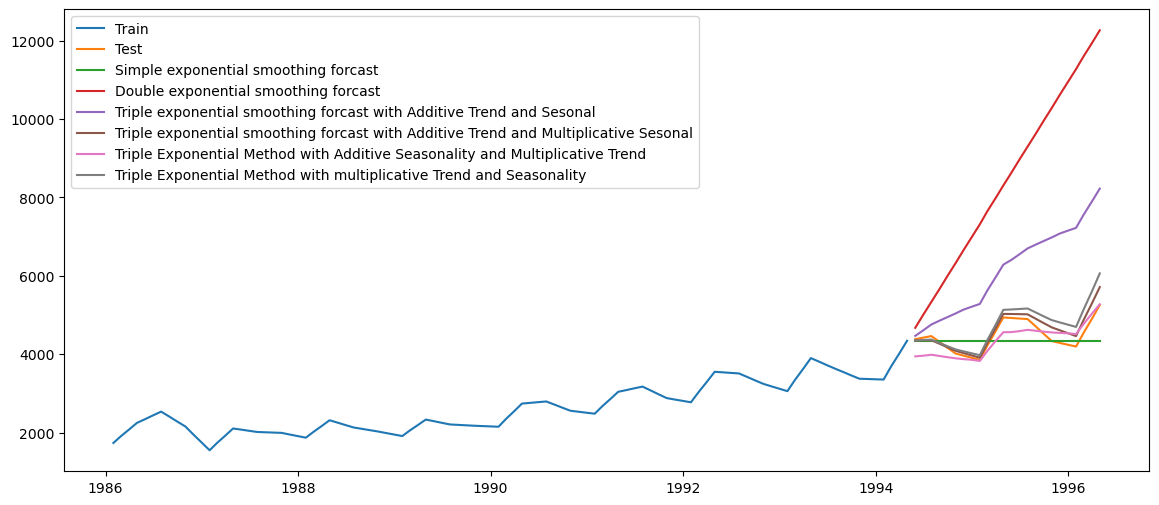

In [216]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [218]:
#Comparing the results
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul"]),
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  Triple_Exp_Mul_Add   40.858916      3.636542        210.001406
1  Triple_Exp_Add_Mul  169.715463      5.227066        270.840048
2      Triple_Exp_Mul   40.066819      6.308444        366.464335
3          Simple_Exp  129.784147      6.620374        382.447742
4      Triple_Exp_Add   45.975995     37.824069       1938.637795
5          Double_Exp  106.049183     89.494625       4549.907951

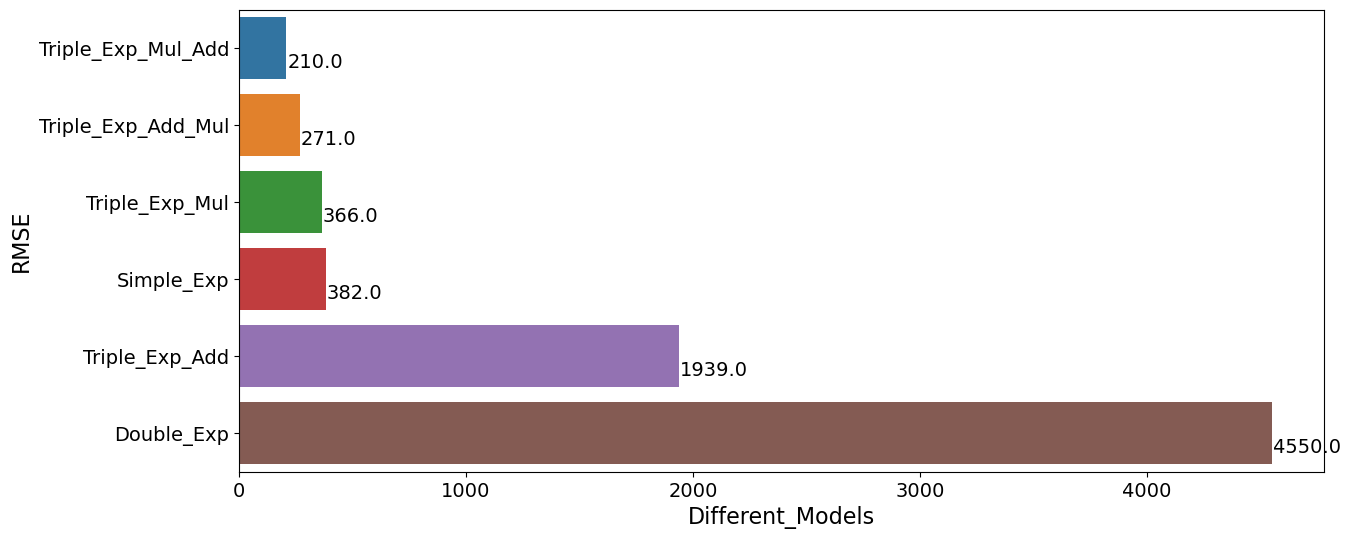

In [219]:
#Visualizing Model Performance
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

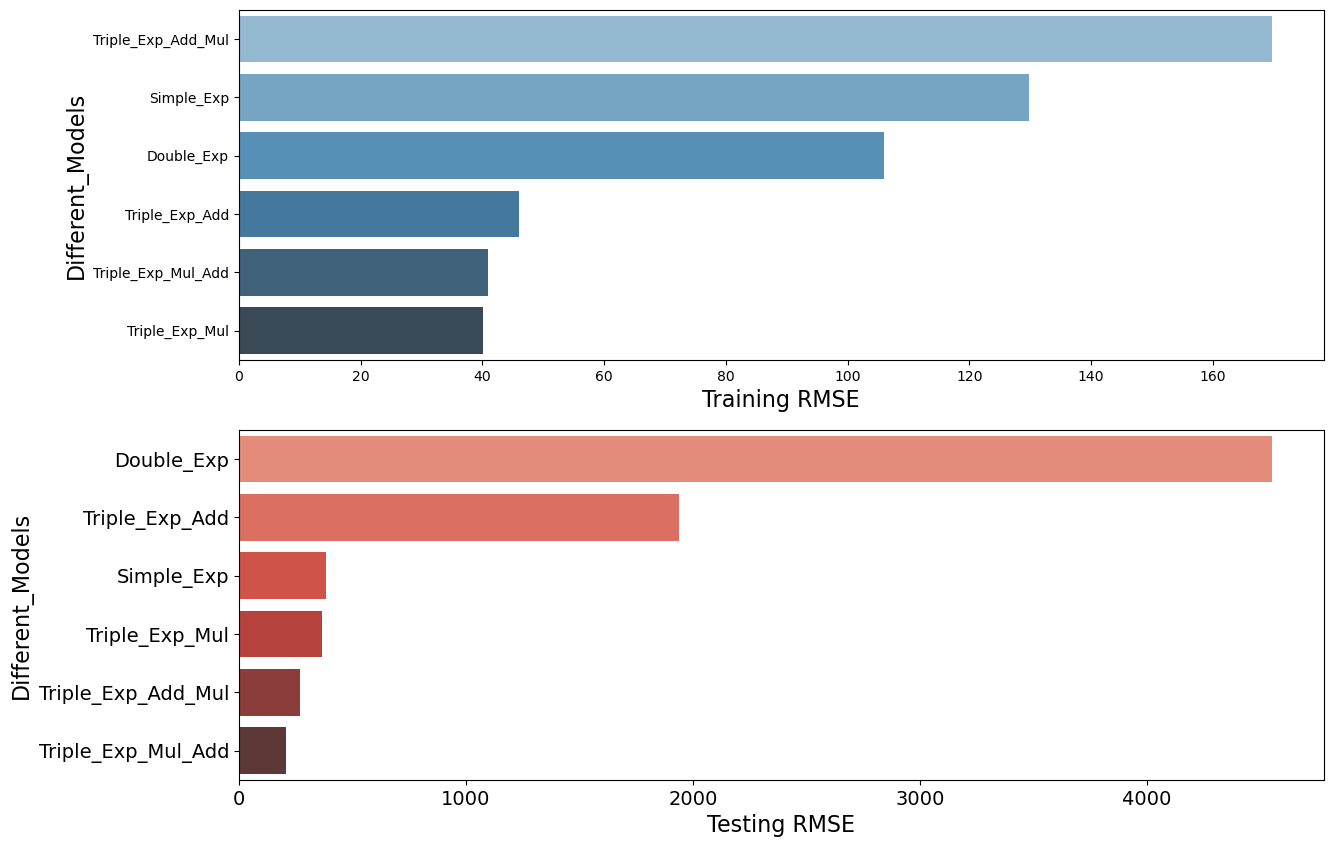

In [220]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models', size=16)

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models', size=16)

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

In [222]:
#Stationary vs Non-stationary Time Series
  #Test of Stationarity
    #As we have quarterly data the window size for moving average is equal to 4

In [223]:
def test_stationarity(timeseries):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

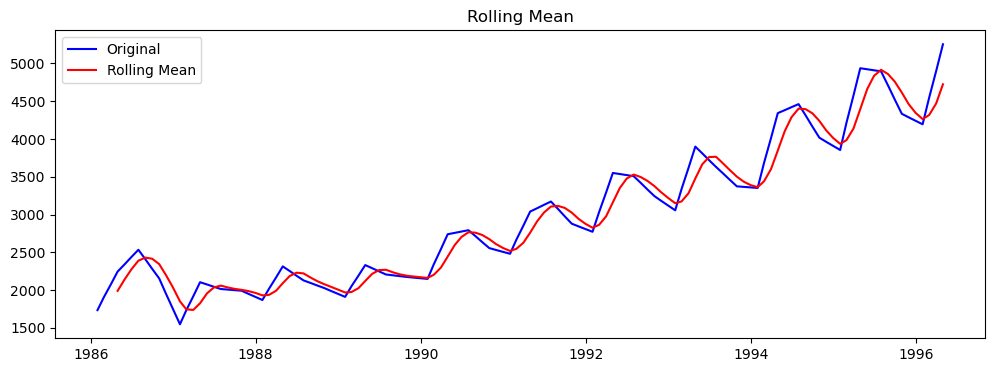

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [224]:
#Augmented Dicky Fuller Test
plt.figure(figsize=(12,4))
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [225]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [226]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


# Feature Scaling

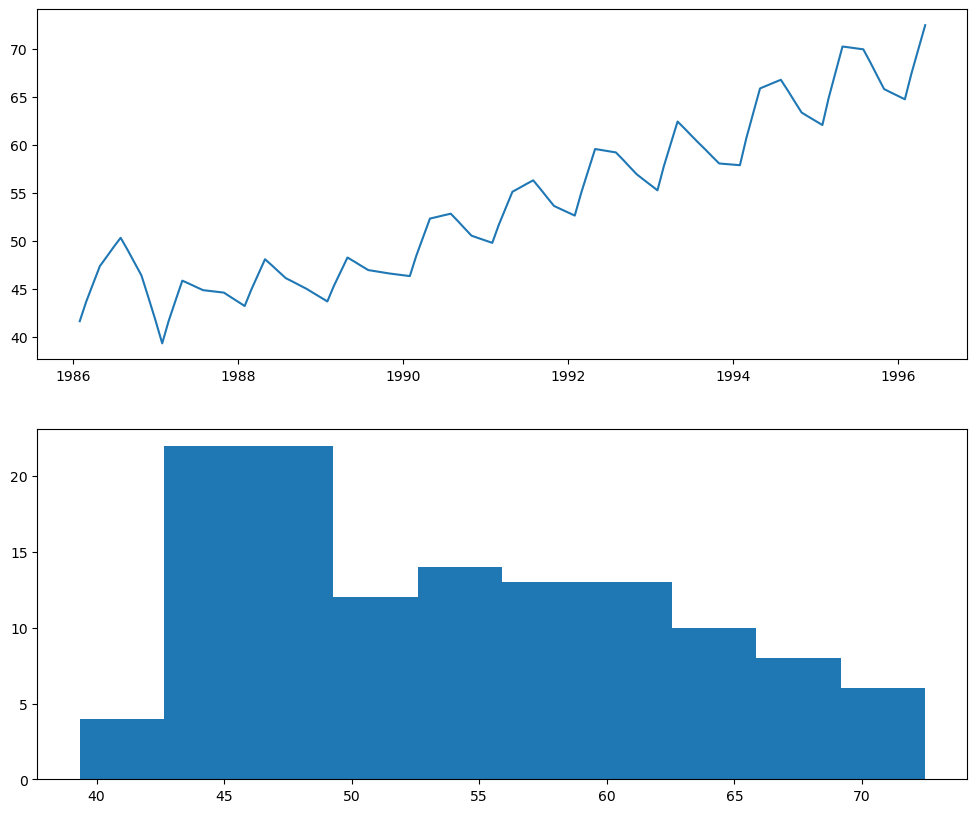

In [227]:
#1. Square Root Transform
square_root = pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

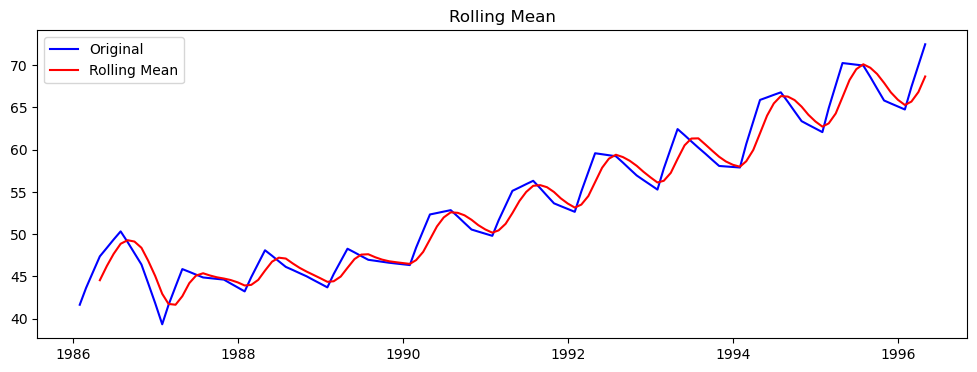

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [228]:
plt.figure(figsize=(12,4))
test_stationarity(square_root)

In [229]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


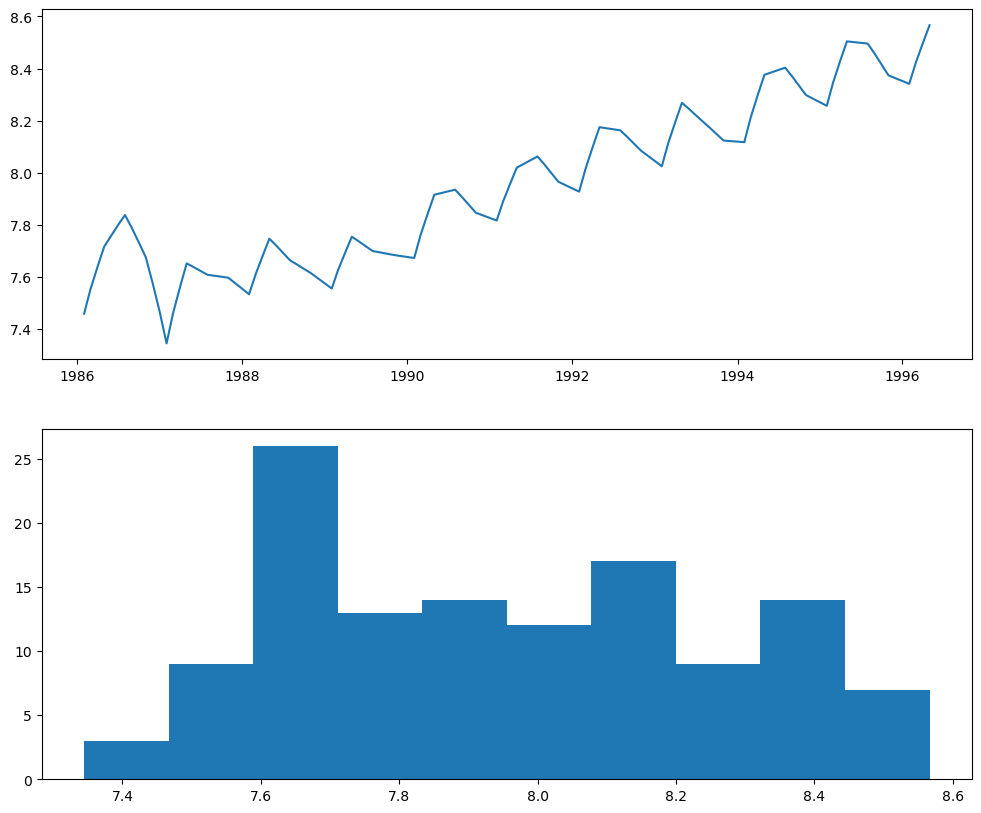

In [230]:
#2. Log Transform
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])

# Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()


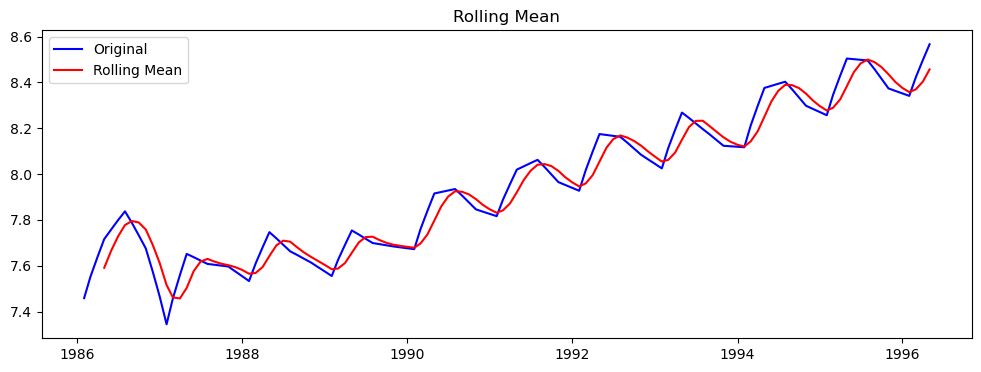

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [231]:
plt.figure(figsize=(12,4))
test_stationarity(log)

In [232]:
adf_test(log.Sales)

Fail to reject the null hypothesis
Data is non-stationary


In [233]:
#Hence, the Time series data is Non-Stationary

In [234]:
#3. Converting Non-Stationary Time Series into Stationary

In [236]:
#Box Cox Transformation

Sales
Date                
1986-01-31  7.458663
1986-02-28  7.552170
1986-03-31  7.637676
1986-04-30  7.716443
1986-05-31  7.758437

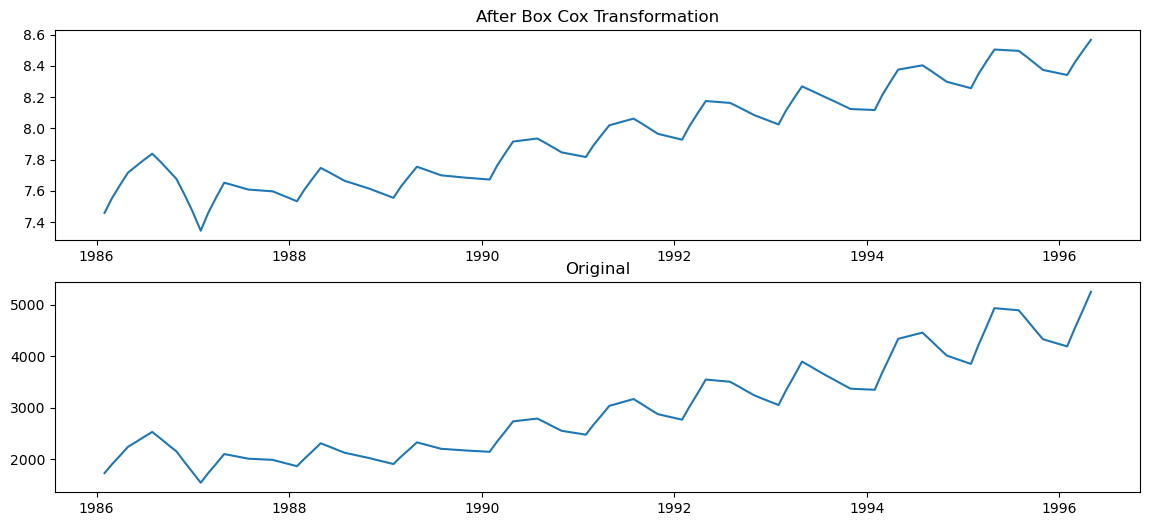

In [237]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

In [238]:
#We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar.
#But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing for making the mean constant.

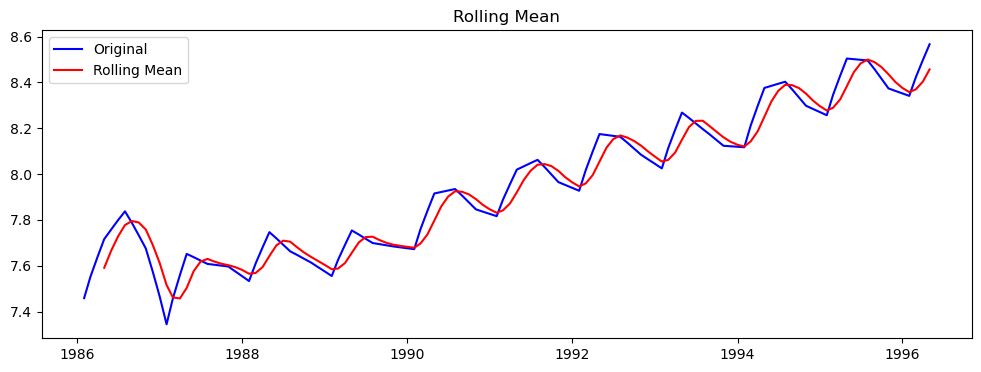

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [239]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox)

In [240]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


In [241]:
#Differencing of the Box-Cox Transformation

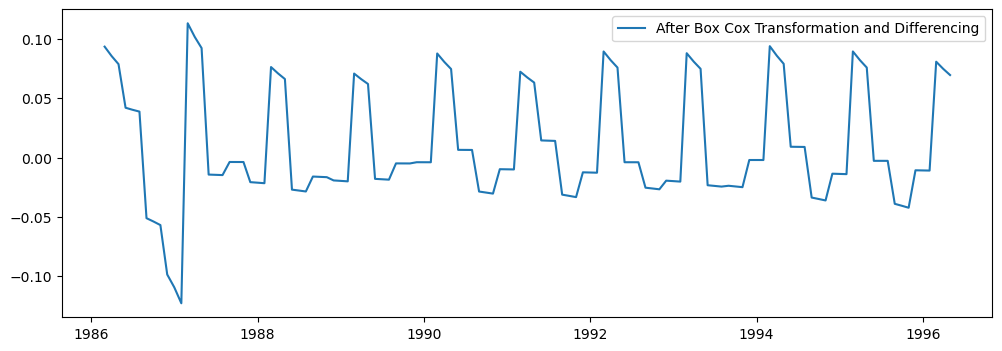

In [242]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

# 
We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation.
It is a horizontal trend.
The mean became constant. The mean is zero.
Also, the variance is almost constant.

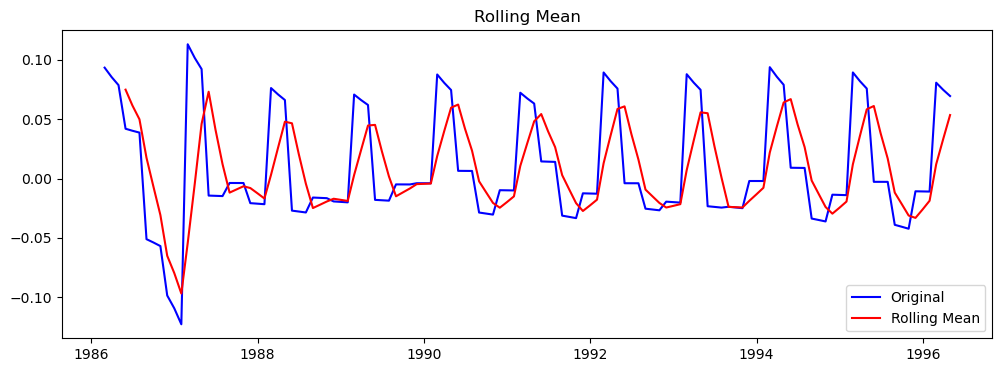

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [243]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox_diff)

In [244]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


# 
Finally, Our Series is now stationary for AR Forecasting

In [245]:
#Building The Time Series Forecasting with Optimal Value using ARIMA
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

In [246]:
#ARIMA Hyperparameter Tuning
# Grid search ARIMA parameters for a time series
# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [249]:
# Evaluate parameters
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Sales, p_values, d_values, q_values)

Best ARIMA(3, 0, 2) RMSE=0.028


In [250]:
#Inverse transformation of the Box-Cox Differencing
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()

# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Sales[0])

# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

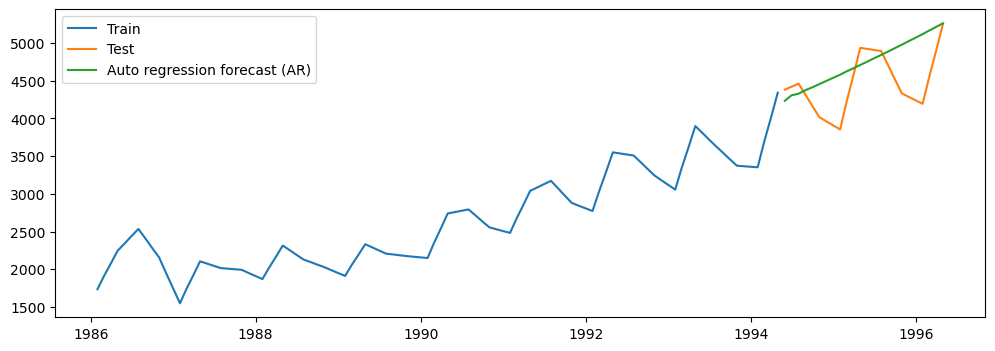

In [251]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

We can see that we have done moderately well.
No Seasonality captured. Only Trend has been captured

# Model Evaluation

In [252]:
#RMSE
rmse_arima = np.sqrt(mean_squared_error(test_data.Sales, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

455.62

In [253]:
#MAPE
mape_arima = round(np.mean(np.abs((test_data.Sales - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_arima

8.57

We can see that AR model has done reasonably good job but not better than Holt's method.
We souldn't compare it with Holt's method. Because Holt's method captures seasonality

In [254]:
#Analysing Residuals
model_residual = model_fit.resid
model_residual.mean()

0.00022546452265170152

In [255]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


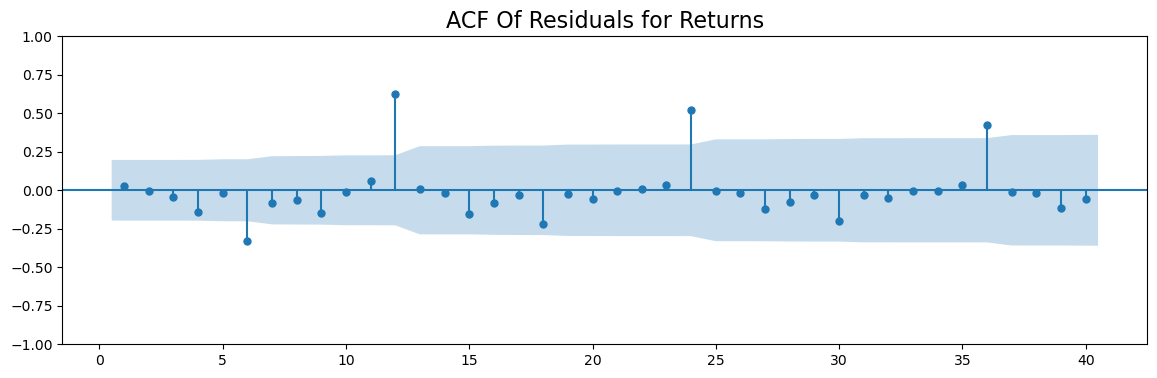

In [256]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

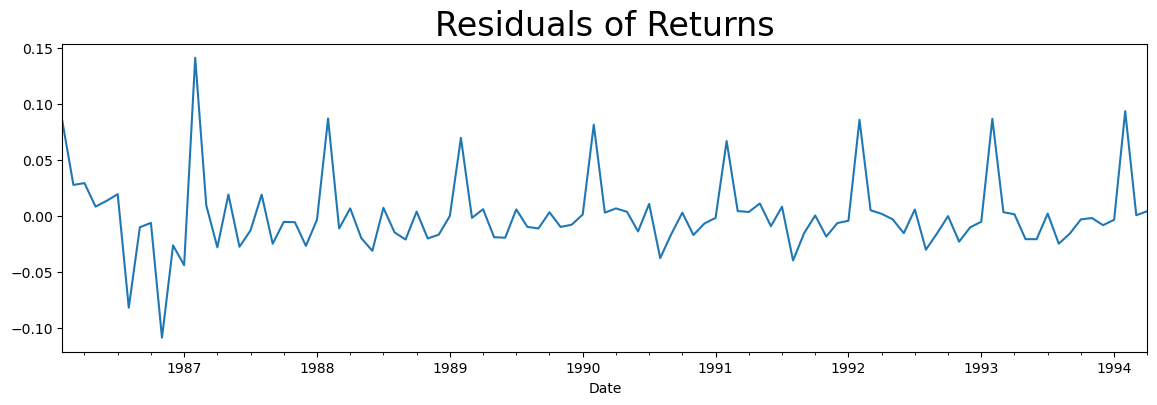

In [257]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

In [258]:
#SARIMA

In [259]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [260]:
#Inverse Transformation of the Differencing Box-Cox Transformation
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

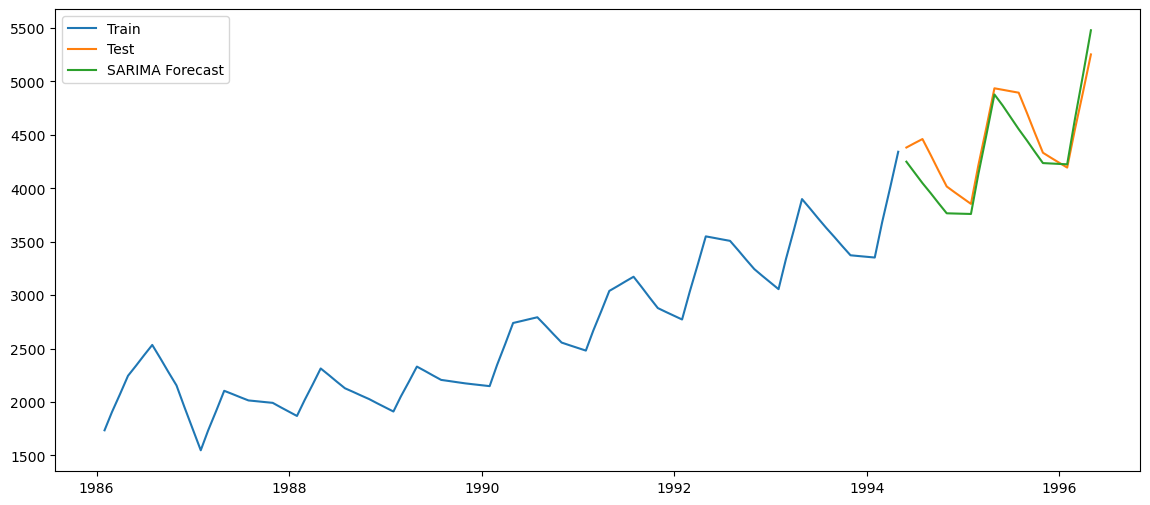

In [261]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

# Model Evaluation

In [262]:
#RMSE
rmse_sarima = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_sarima

206.61

In [263]:
#MAPE
mape_sarima = round(np.mean(np.abs((test_data.Sales - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_sarima

3.94

SARIMA method has done reasonably well as it captures seasonality.
The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. 

In [264]:
#Analysing Residuals
model_residual = model_fit.resid
model_residual.mean()

0.03703966844162099

In [265]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


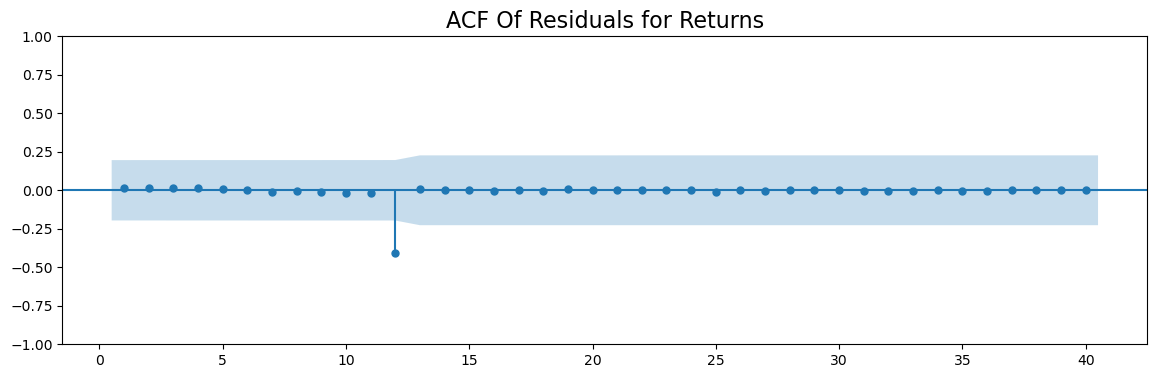

In [266]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

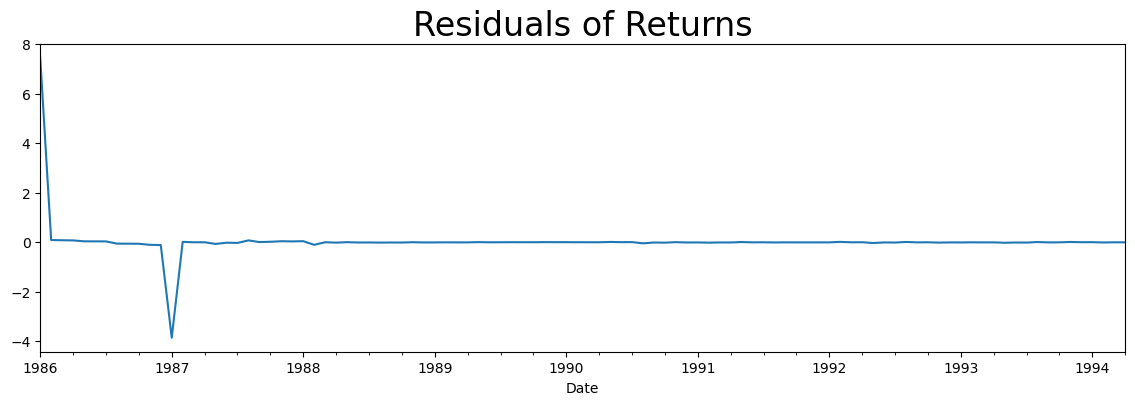

In [267]:
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

In [268]:
#Creating model with differente Transformation Technique

In [269]:
#Comparing Results
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_Additive","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Multiplicative","ARIMA","SARIMA"]),
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_arima,rmse_sarima])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models    MAPE(%)  RMSE_Values
0                     SARIMA   3.940000   206.610000
1         Triple_Exp_Mul_Add   3.636542   210.001406
2         Triple_Exp_Add_Mul   5.227066   270.840048
3  Triple_Exp_Multiplicative   6.308444   366.464335
4         Simple_Exponential   6.620374   382.447742
5                      ARIMA   8.570000   455.620000
6        Triple_Exp_Additive  37.824069  1938.637795
7         Double_Exponential  89.494625  4549.907951

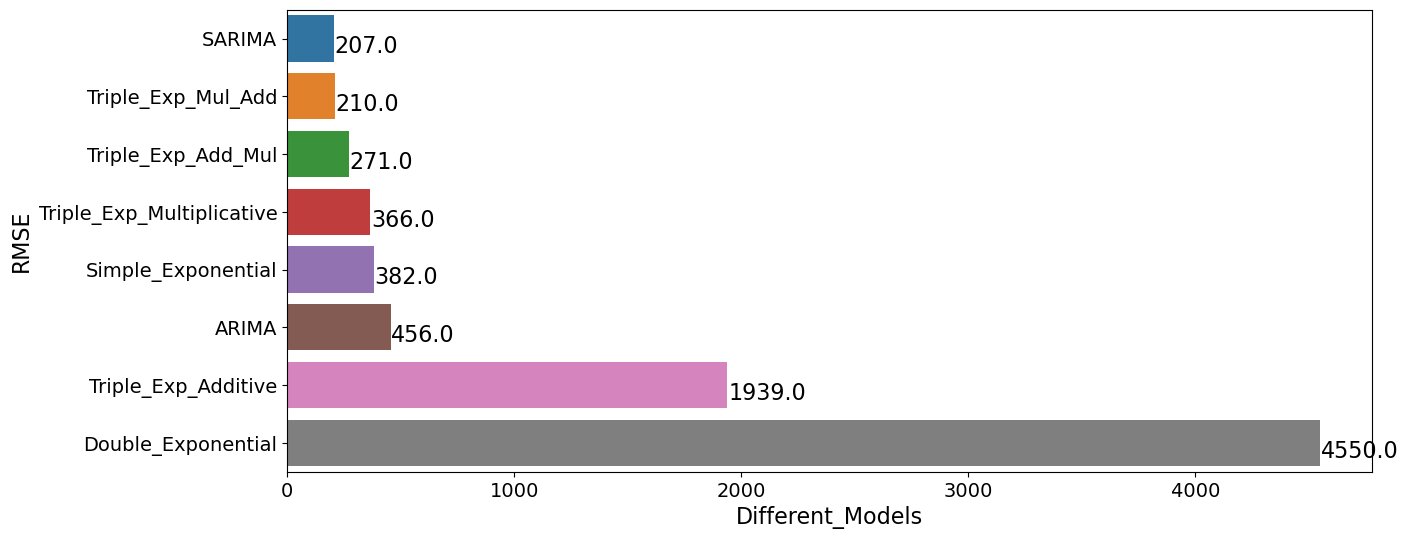

In [270]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 16)

plt.show()

The Sarima Model did very well as compared to other methods and Models
Even in methods such as Triple Exponential Smoothing (Holts-Winters Method) taking Seasonality as Multiplicative and Trend as Additive gave the second best restult in this case


In [271]:
#Model Preprocessing for Model Driven Techniques

In [272]:
#Creating Dummy Variables of the Categorical Feature Month of Date Time feature

In [273]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

Date        Sales    t  t_squared month  year  Jan  Feb  Mar  Apr  \
0   1986-01-31  1734.827000    1          1   Jan  1986    1    0    0    0   
1   1986-02-28  1904.871666    2          4   Feb  1986    0    1    0    0   
2   1986-03-31  2074.916332    3          9   Mar  1986    0    0    1    0   
3   1986-04-30  2244.960999    4         16   Apr  1986    0    0    0    1   
4   1986-05-31  2341.242330    5         25   May  1986    0    0    0    0   
..         ...          ...  ...        ...   ...   ...  ...  ...  ...  ...   
119 1995-12-31  4240.333333  120      14400   Dec  1995    0    0    0    0   
120 1996-01-31  4194.000000  121      14641   Jan  1996    1    0    0    0   
121 1996-02-29  4547.000000  122      14884   Feb  1996    0    1    0    0   
122 1996-03-31  4900.000000  123      15129   Mar  1996    0    0    1    0   
123 1996-04-30  5253.000000  124      15376   Apr  1996    0    0    0    1   

     May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
0      0    0    0    0    0    0    0    0   7.458663  
1      0    0    0    0    0    0    0    0   7.552170  
2      0    0    0    0    0    0    0    0   7.637676  
3      0    0    0    0    0    0    0    0   7.716443  
4      1    0    0    0    0    0    0    0   7.758437  
..   ...  ...  ...  ...  ...  ...  ...  ...        ...  
119    0    0    0    0    0    0    0    1   8.352397  
120    0    0    0    0    0    0    0    0   8.341410  
121    0    0    0    0    0    0    0    0   8.422223  
122    0    0    0    0    0    0    0    0   8.496990  
123    0    0    0    0    0    0    0    0   8.566555  

[124 rows x 19 columns]

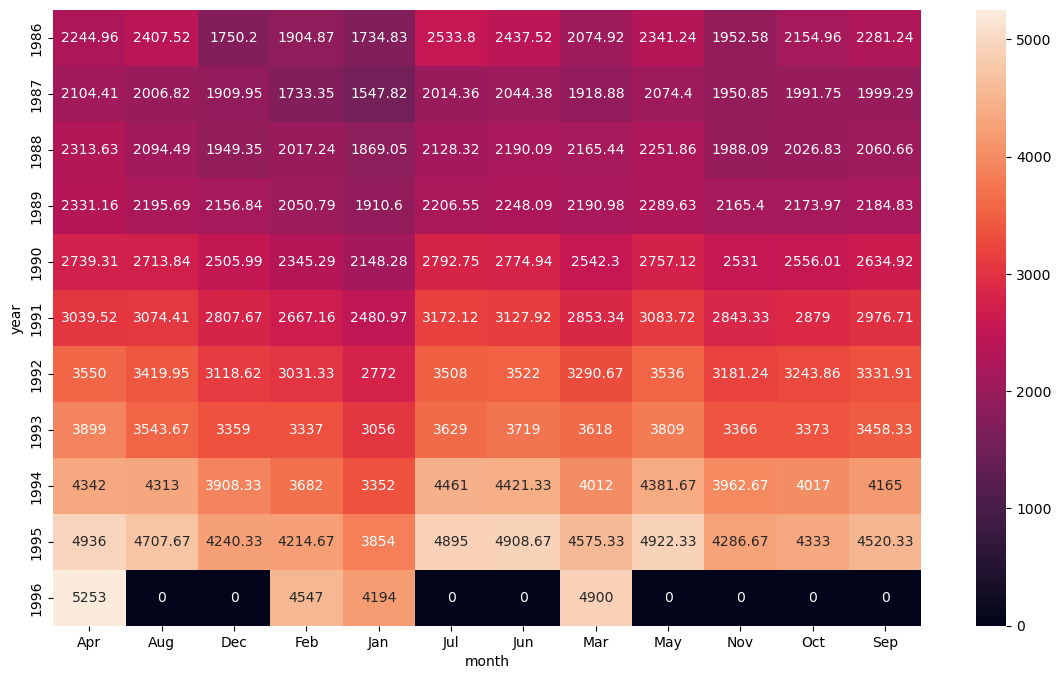

In [274]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

# Splitting data into train and test

In [275]:
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [276]:
train_data

Date        Sales    t  t_squared month  year  Jan  Feb  Mar  Apr  \
0  1986-01-31  1734.827000    1          1   Jan  1986    1    0    0    0   
1  1986-02-28  1904.871666    2          4   Feb  1986    0    1    0    0   
2  1986-03-31  2074.916332    3          9   Mar  1986    0    0    1    0   
3  1986-04-30  2244.960999    4         16   Apr  1986    0    0    0    1   
4  1986-05-31  2341.242330    5         25   May  1986    0    0    0    0   
..        ...          ...  ...        ...   ...   ...  ...  ...  ...  ...   
95 1993-12-31  3359.000000   96       9216   Dec  1993    0    0    0    0   
96 1994-01-31  3352.000000   97       9409   Jan  1994    1    0    0    0   
97 1994-02-28  3682.000000   98       9604   Feb  1994    0    1    0    0   
98 1994-03-31  4012.000000   99       9801   Mar  1994    0    0    1    0   
99 1994-04-30  4342.000000  100      10000   Apr  1994    0    0    0    1   

    May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
0     0    0    0    0    0    0    0    0   7.458663  
1     0    0    0    0    0    0    0    0   7.552170  
2     0    0    0    0    0    0    0    0   7.637676  
3     0    0    0    0    0    0    0    0   7.716443  
4     1    0    0    0    0    0    0    0   7.758437  
..  ...  ...  ...  ...  ...  ...  ...  ...        ...  
95    0    0    0    0    0    0    0    1   8.119399  
96    0    0    0    0    0    0    0    0   8.117312  
97    0    0    0    0    0    0    0    0   8.211211  
98    0    0    0    0    0    0    0    0   8.297045  
99    0    0    0    0    0    0    0    0   8.376090  

[100 rows x 19 columns]

In [277]:
test_data

Date        Sales    t  t_squared month  year  Jan  Feb  Mar  Apr  \
100 1994-05-31  4381.666667  101      10201   May  1994    0    0    0    0   
101 1994-06-30  4421.333333  102      10404   Jun  1994    0    0    0    0   
102 1994-07-31  4461.000000  103      10609   Jul  1994    0    0    0    0   
103 1994-08-31  4313.000000  104      10816   Aug  1994    0    0    0    0   
104 1994-09-30  4165.000000  105      11025   Sep  1994    0    0    0    0   
105 1994-10-31  4017.000000  106      11236   Oct  1994    0    0    0    0   
106 1994-11-30  3962.666667  107      11449   Nov  1994    0    0    0    0   
107 1994-12-31  3908.333333  108      11664   Dec  1994    0    0    0    0   
108 1995-01-31  3854.000000  109      11881   Jan  1995    1    0    0    0   
109 1995-02-28  4214.666667  110      12100   Feb  1995    0    1    0    0   
110 1995-03-31  4575.333333  111      12321   Mar  1995    0    0    1    0   
111 1995-04-30  4936.000000  112      12544   Apr  1995    0    0    0    1   
112 1995-05-31  4922.333333  113      12769   May  1995    0    0    0    0   
113 1995-06-30  4908.666667  114      12996   Jun  1995    0    0    0    0   
114 1995-07-31  4895.000000  115      13225   Jul  1995    0    0    0    0   
115 1995-08-31  4707.666667  116      13456   Aug  1995    0    0    0    0   
116 1995-09-30  4520.333333  117      13689   Sep  1995    0    0    0    0   
117 1995-10-31  4333.000000  118      13924   Oct  1995    0    0    0    0   
118 1995-11-30  4286.666667  119      14161   Nov  1995    0    0    0    0   
119 1995-12-31  4240.333333  120      14400   Dec  1995    0    0    0    0   
120 1996-01-31  4194.000000  121      14641   Jan  1996    1    0    0    0   
121 1996-02-29  4547.000000  122      14884   Feb  1996    0    1    0    0   
122 1996-03-31  4900.000000  123      15129   Mar  1996    0    0    1    0   
123 1996-04-30  5253.000000  124      15376   Apr  1996    0    0    0    1   

     May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
100    1    0    0    0    0    0    0    0   8.385184  
101    0    1    0    0    0    0    0    0   8.394197  
102    0    0    1    0    0    0    0    0   8.403128  
103    0    0    0    1    0    0    0    0   8.369389  
104    0    0    0    0    1    0    0    0   8.334472  
105    0    0    0    0    0    1    0    0   8.298291  
106    0    0    0    0    0    0    1    0   8.284672  
107    0    0    0    0    0    0    0    1   8.270866  
108    0    0    0    0    0    0    0    0   8.256867  
109    0    0    0    0    0    0    0    0   8.346326  
110    0    0    0    0    0    0    0    0   8.428435  
111    0    0    0    0    0    0    0    0   8.504311  
112    1    0    0    0    0    0    0    0   8.501538  
113    0    1    0    0    0    0    0    0   8.498758  
114    0    0    1    0    0    0    0    0   8.495970  
115    0    0    0    1    0    0    0    0   8.456948  
116    0    0    0    0    1    0    0    0   8.416341  
117    0    0    0    0    0    1    0    0   8.374015  
118    0    0    0    0    0    0    1    0   8.363265  
119    0    0    0    0    0    0    0    1   8.352397  
120    0    0    0    0    0    0    0    0   8.341410  
121    0    0    0    0    0    0    0    0   8.422223  
122    0    0    0    0    0    0    0    0   8.496990  
123    0    0    0    0    0    0    0    0   8.566555

# Building Ordinary Square Model

In [278]:
#1. Linear Model
linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668943

In [279]:
#2. Exponential Model
exp = smf.ols('log_sales~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

530.3268025099009

In [280]:
#3. Quadratic Model
quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_quad))**2))
rmse_quad

371.29418344986647

In [281]:
#4. Additive seasonality
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483788

In [282]:
#5. Additive Seasonality Quadratic
add_sea_quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.80498810372768

In [283]:
#6. Multiplicative Seasonality
mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

1904.7944171920326

In [284]:
#7. Multiplicative Additive Seasonality
mul_add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(test_data))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea 

396.41978173827204

In [285]:
#Compare the Results
data = {"Models":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad","RMSE_Add_Sea","RMSE_Add_Sea_Quad","RMSE_Mult_Sea","RMSE_Mult_Add_Sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [286]:
e = table_rmse.append(table_evaluation)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

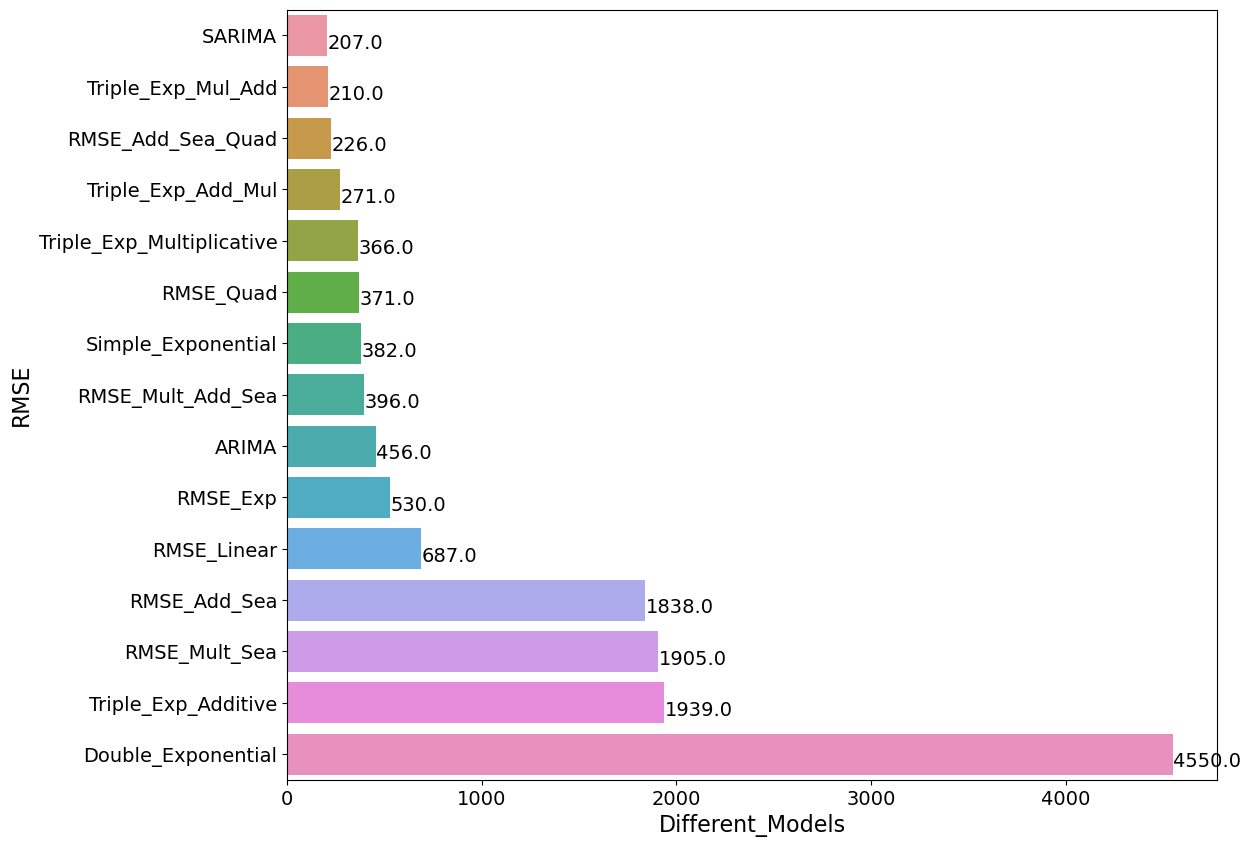

In [287]:
f, axe = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)

plt.show()

Triple Exponential Method with Multiplicative Seasonality and Additive Trend
The best model we have got so far with the lowest RMSE and lowest MAPE.